# **Modelo de predicción del precio del banano**

## **Diagnóstico de Overfitting/Underfitting**

# **Carga y exploración del dataset**

Cargar datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()
df = pd.read_excel('precio_ecuador.xlsx')

Saving precio_ecuador.xlsx to precio_ecuador (1).xlsx


Creación de fecha y lags (rezagos)

In [ ]:
# Crear Fecha con base en Año y Semana
df['Fecha'] = pd.to_datetime(
    df['Año'].astype(str) + df['Semana'].astype(str) + '1',
    format='%G%V%u'
)
df = df.sort_values('Fecha').reset_index(drop=True)

# Crear 5 lags
for i in range(1, 6):
    df[f"Precio_t-{i}"] = df["Precio"].shift(i)
df = df.dropna().reset_index(drop=True)

Creación de variables y división temporal

In [ ]:
features = [col for col in df.columns if col.startswith("Precio_t-")]
target = "Precio"

from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
X_all = scaler_X.fit_transform(df[features])
y_all = df[target].values  # <- sin escalar para MAPE correcto

n = len(X_all)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, X_val, X_test = X_all[:train_end], X_all[train_end:val_end], X_all[val_end:]
y_train, y_val, y_test = y_all[:train_end], y_all[train_end:val_end], y_all[val_end:]

Creación de métricas y funciones

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit, learning_curve, validation_curve
from math import sqrt

def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(MAPE, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=5)

def metrics_report(y_true, y_pred, label=""):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = MAPE(y_true, y_pred)
    print(f"{label} -> RMSE: {rmse:.3f} | MAE: {mae:.3f} | MAPE: {mape:.2f}%")
    return rmse, mae, mape

# **Sistema de monitoreo/Curvas de aprendizaje y validación**

Modelos Ridge, MLP y XGB

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

models = {
    "Ridge": Ridge(alpha=0.4655),
    "MLP": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1500, random_state=42),
    "XGB": XGBRegressor(
        n_estimators=300, max_depth=3, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, tree_method='gpu_hist', random_state=42
    )
}

Curvas de aprendizaje y validación Ridge, MLP, XGB

In [ ]:
# Curva de aprendizaje

def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=tscv, scoring=mape_scorer,
        train_sizes=np.linspace(0.2, 1.0, 5), n_jobs=-1, shuffle=False
    )
    train_mape = -train_scores.mean(axis=1)
    val_mape   = -val_scores.mean(axis=1)

    plt.figure(figsize=(9,5), dpi=300)
    plt.plot(train_sizes, train_mape, 'o-', label='Train MAPE', color='C0')
    plt.plot(train_sizes, val_mape,   'o-', label='Validation MAPE', color='C3')
    plt.title(f"Learning Curve (MAPE) - {title}")
    plt.xlabel("Tamaño de entrenamiento"); plt.ylabel("MAPE (%)")
    plt.grid(alpha=0.3); plt.legend(); plt.show()

# Curva de validación

def plot_validation_curve_param(model, X, y, param_name, param_range, title):
    train_scores, val_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range,
        cv=tscv, scoring=mape_scorer, n_jobs=-1
    )
    train_mape = -train_scores.mean(axis=1)
    val_mape   = -val_scores.mean(axis=1)

    plt.figure(figsize=(9,5), dpi=300)
    plt.plot(param_range, train_mape, 'o-', label='Train MAPE', color='C0')
    plt.plot(param_range, val_mape,   'o-', label='Validation MAPE', color='C3')
    plt.xscale('log')
    plt.title(f"Validation Curve (MAPE) - {title} [{param_name}]")
    plt.xlabel(param_name); plt.ylabel("MAPE (%)")
    plt.grid(alpha=0.3); plt.legend(); plt.show()

Entrenar y evaluar Ridge, MLP, XGB


===== Ridge =====


Ridge (TEST) -> RMSE: 1.285 | MAE: 0.997 | MAPE: 11.54%


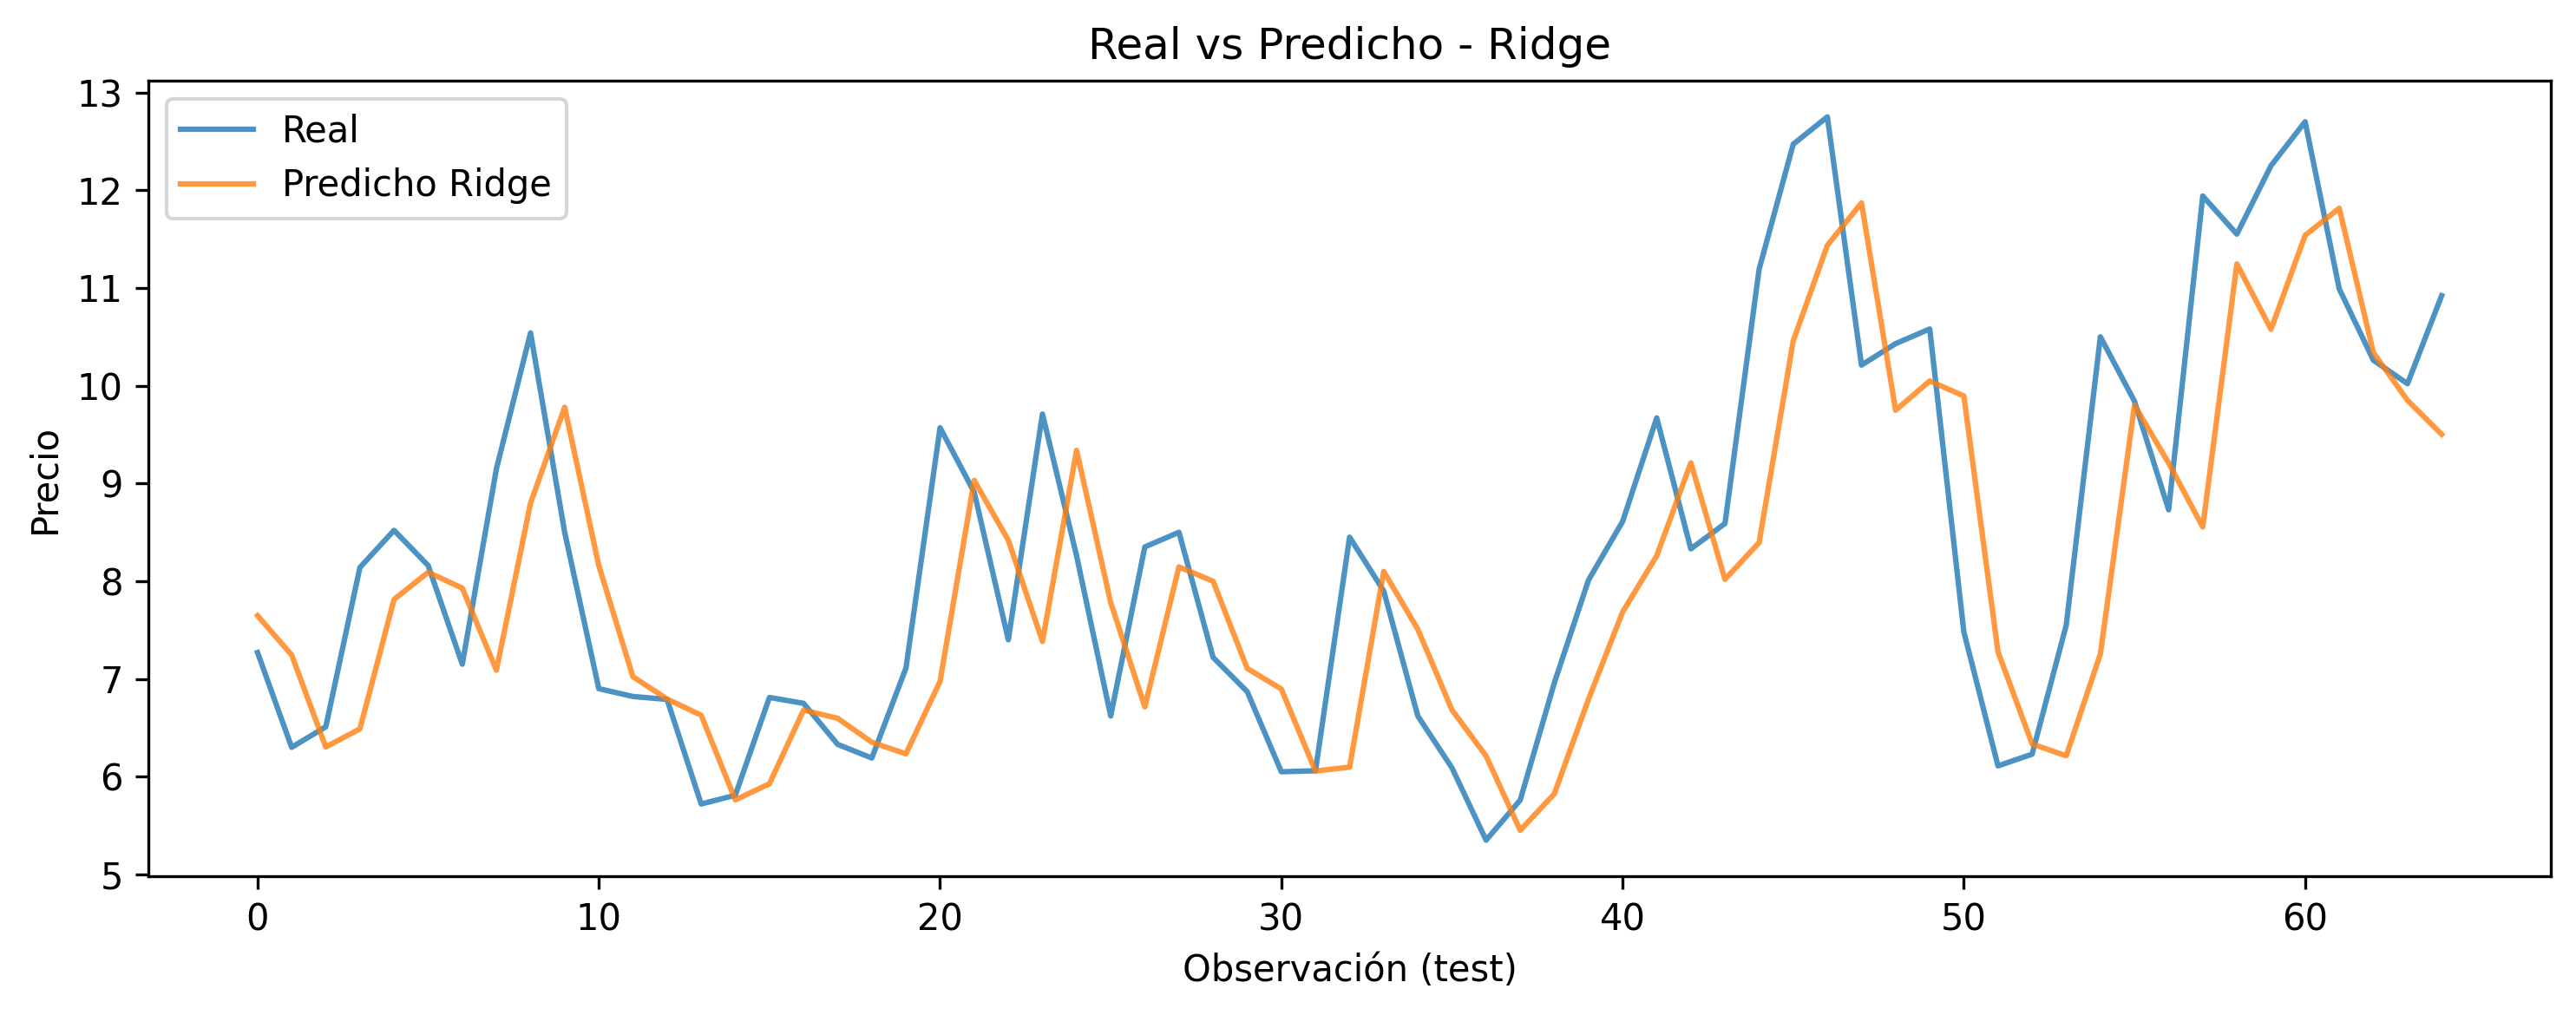


===== MLP =====


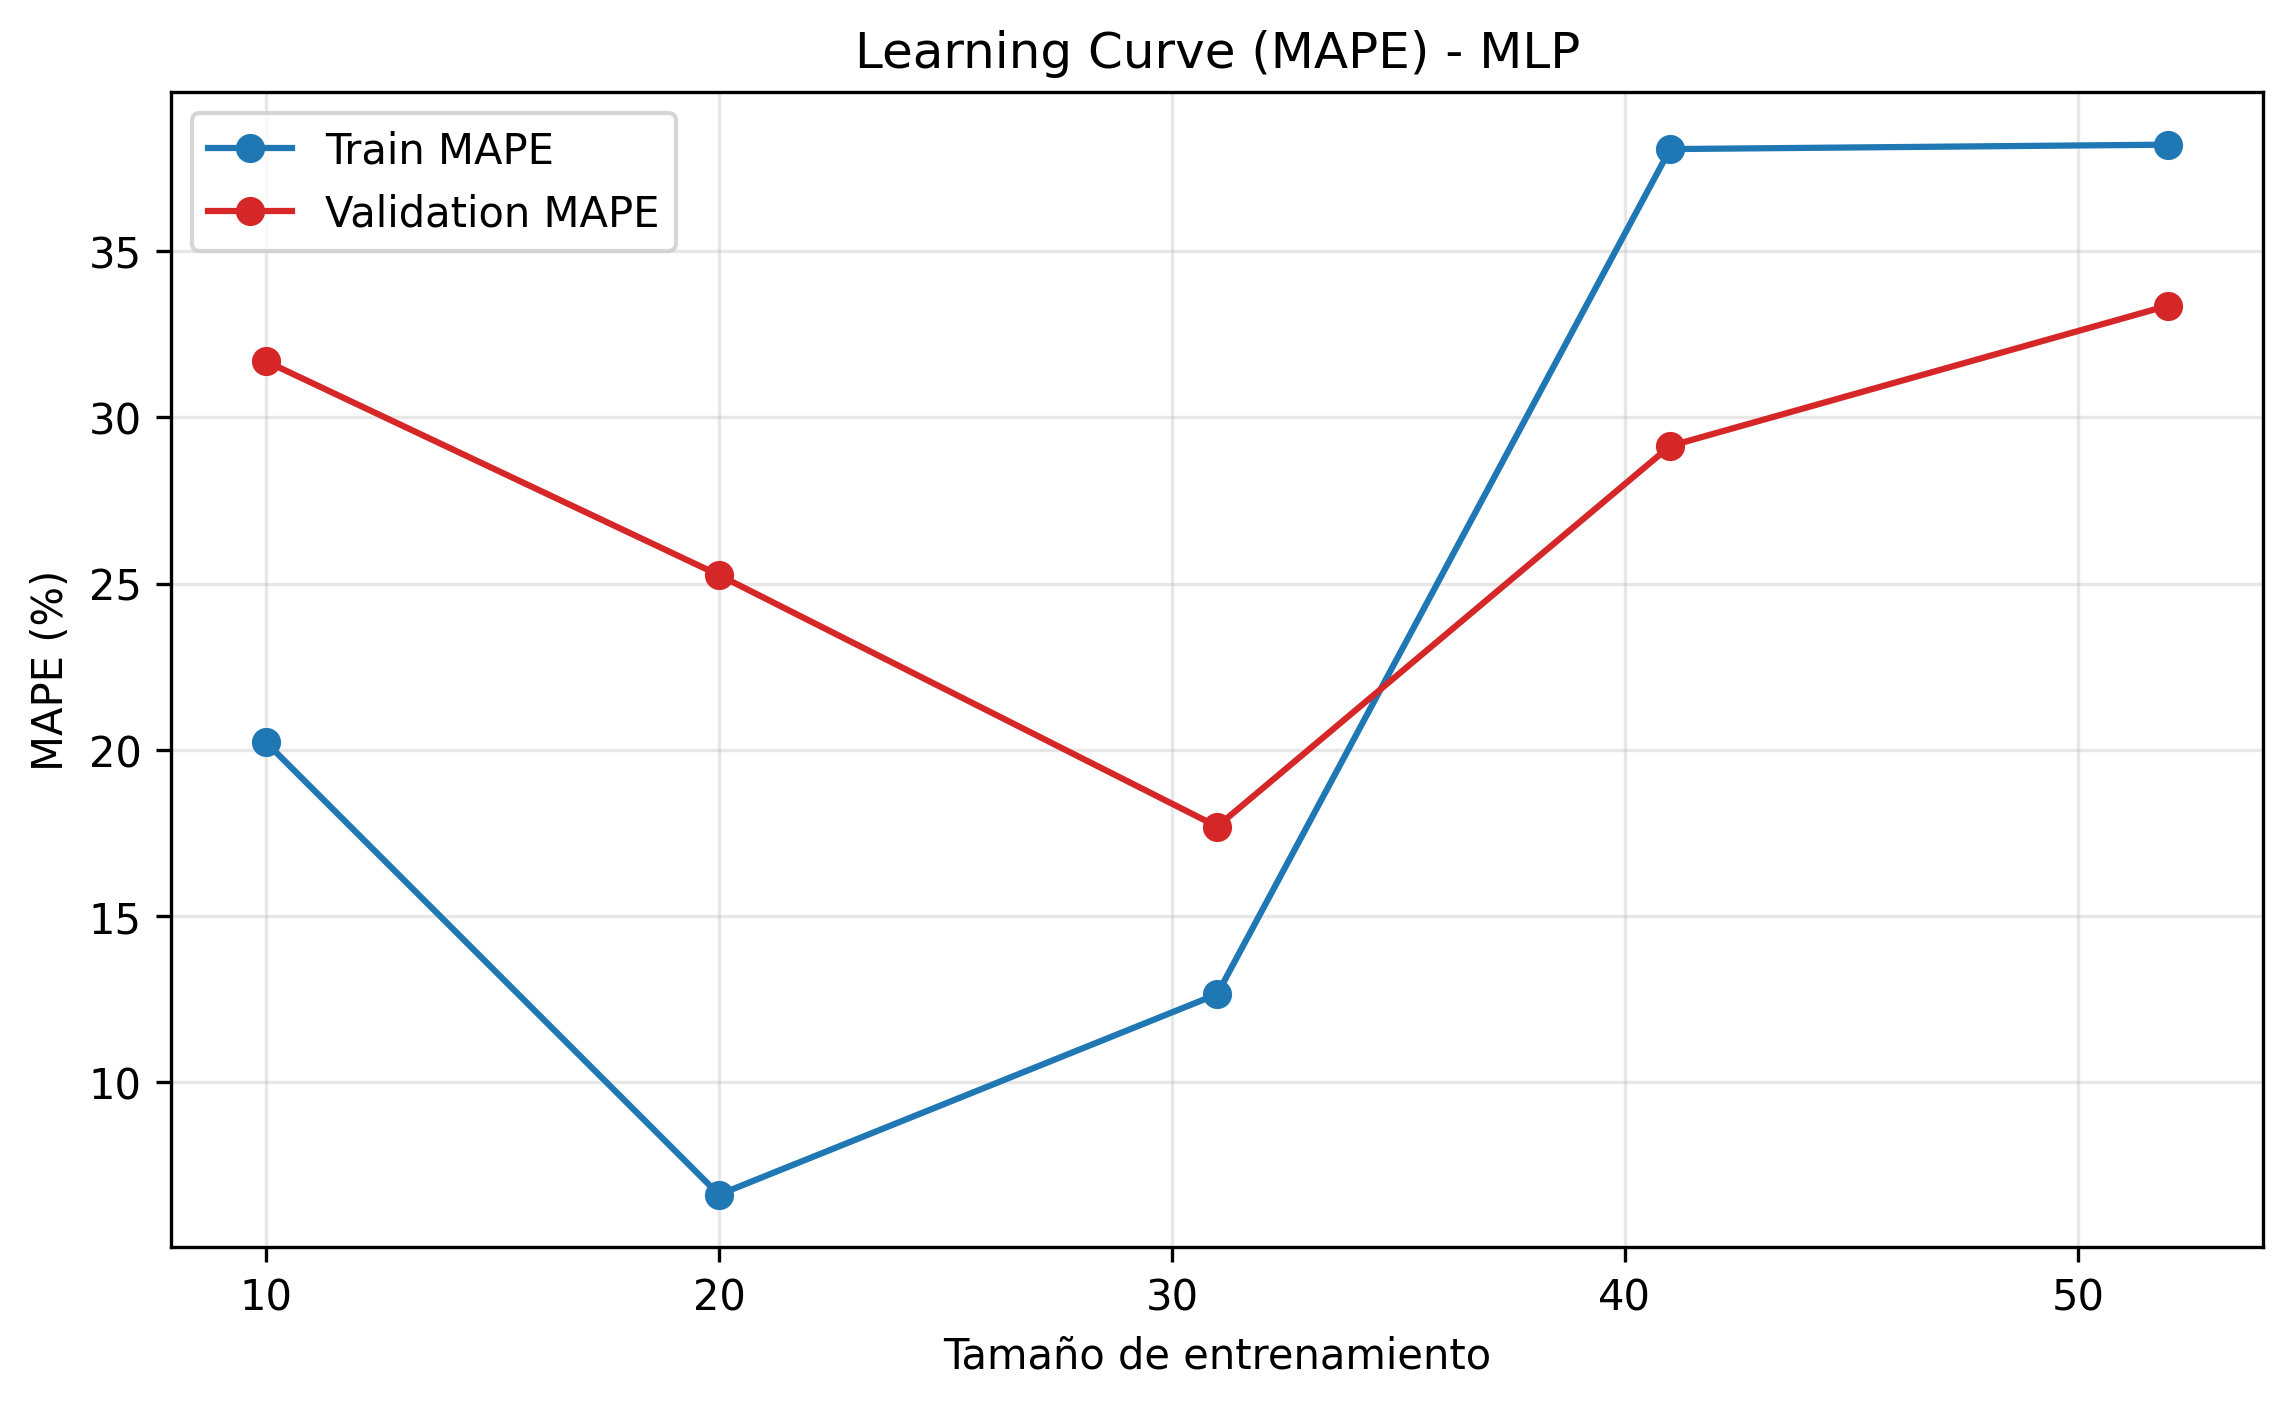

MLP (TEST) -> RMSE: 1.250 | MAE: 1.012 | MAPE: 11.80%


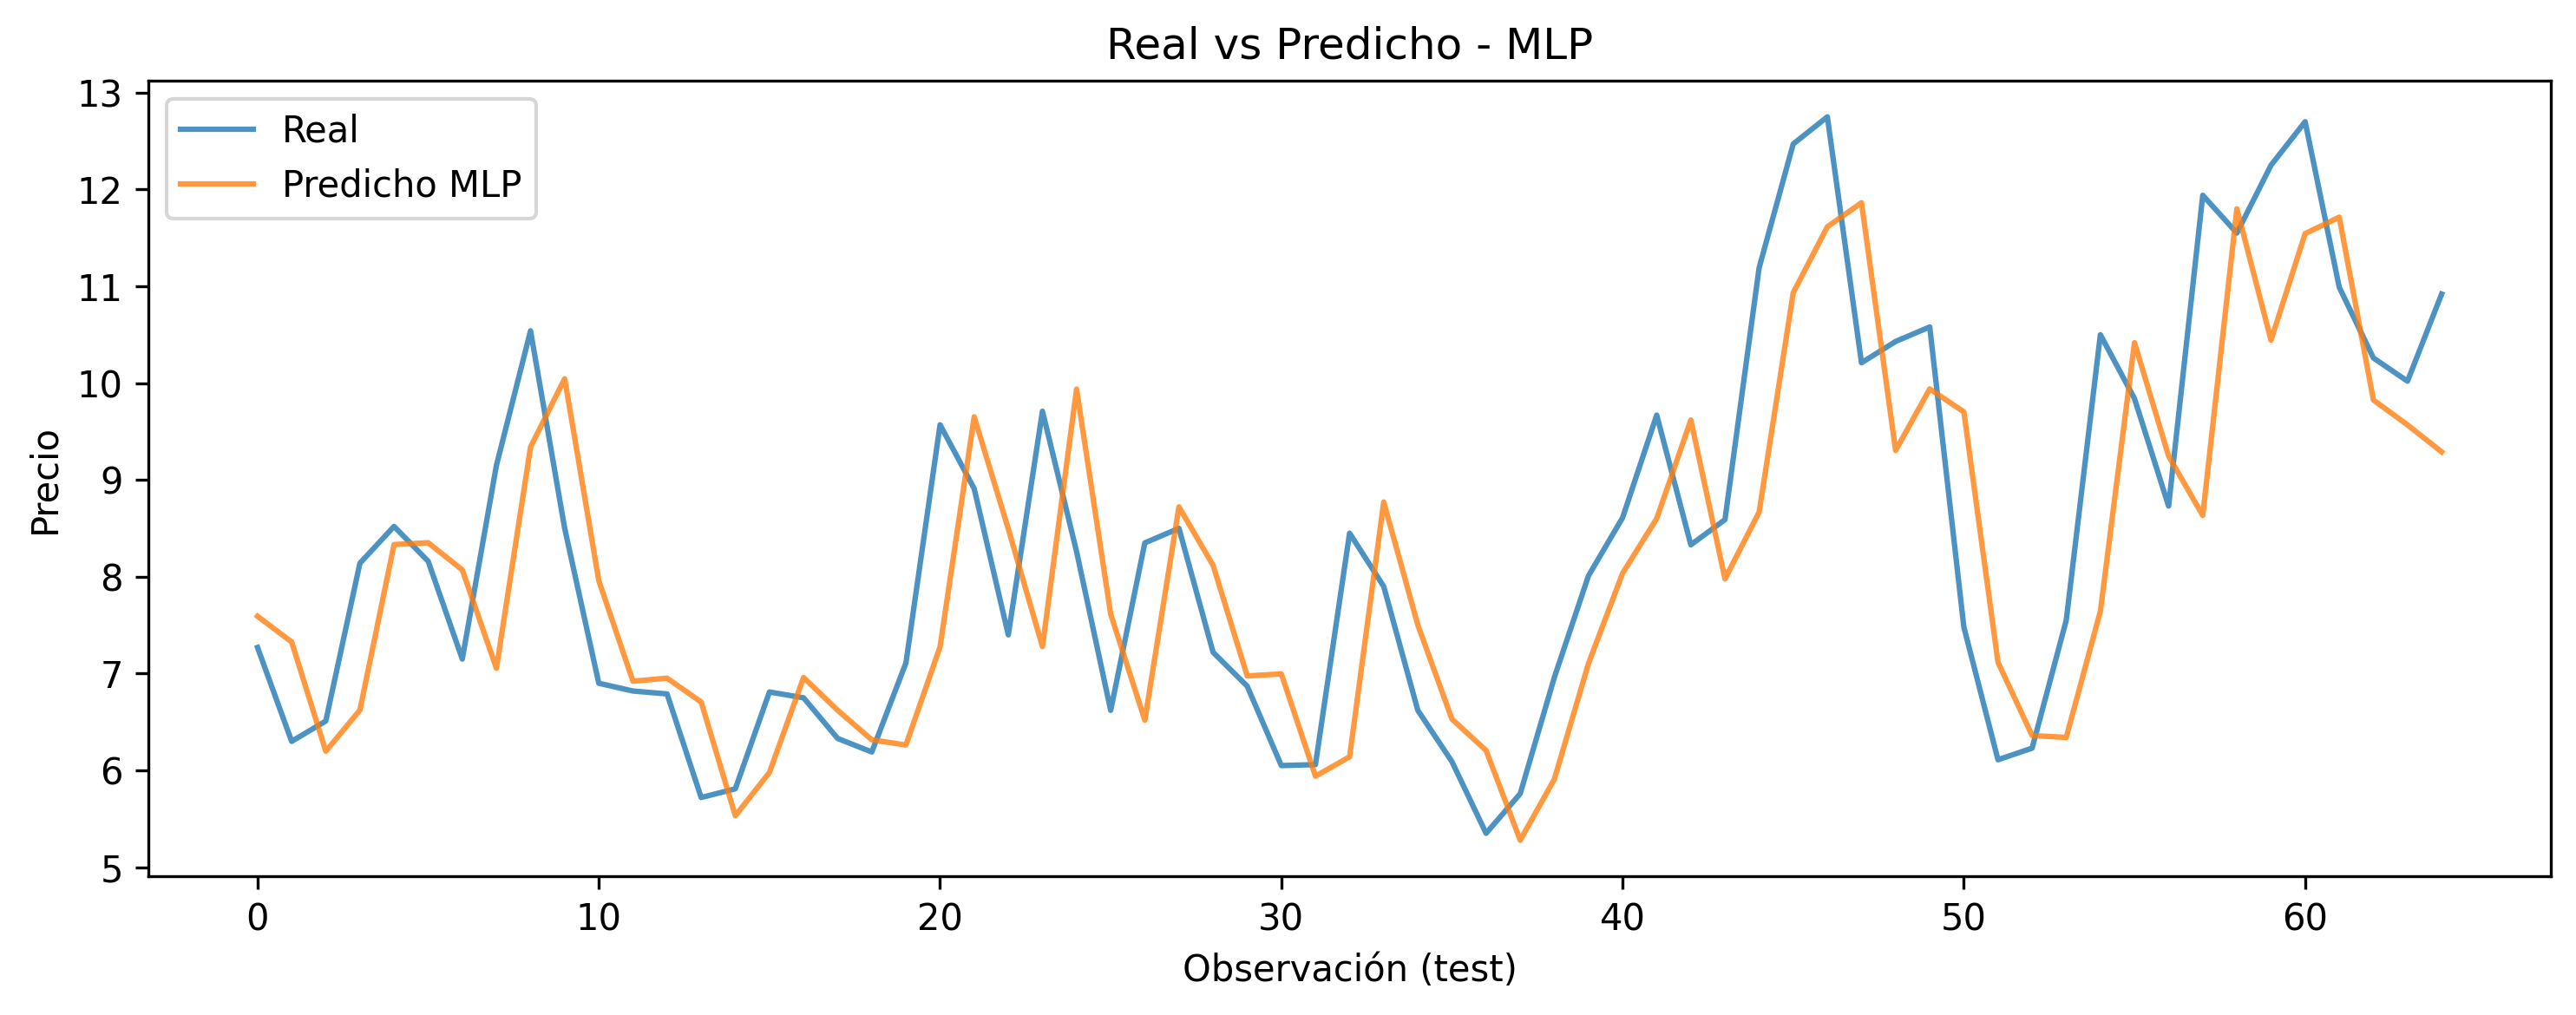


===== XGB =====


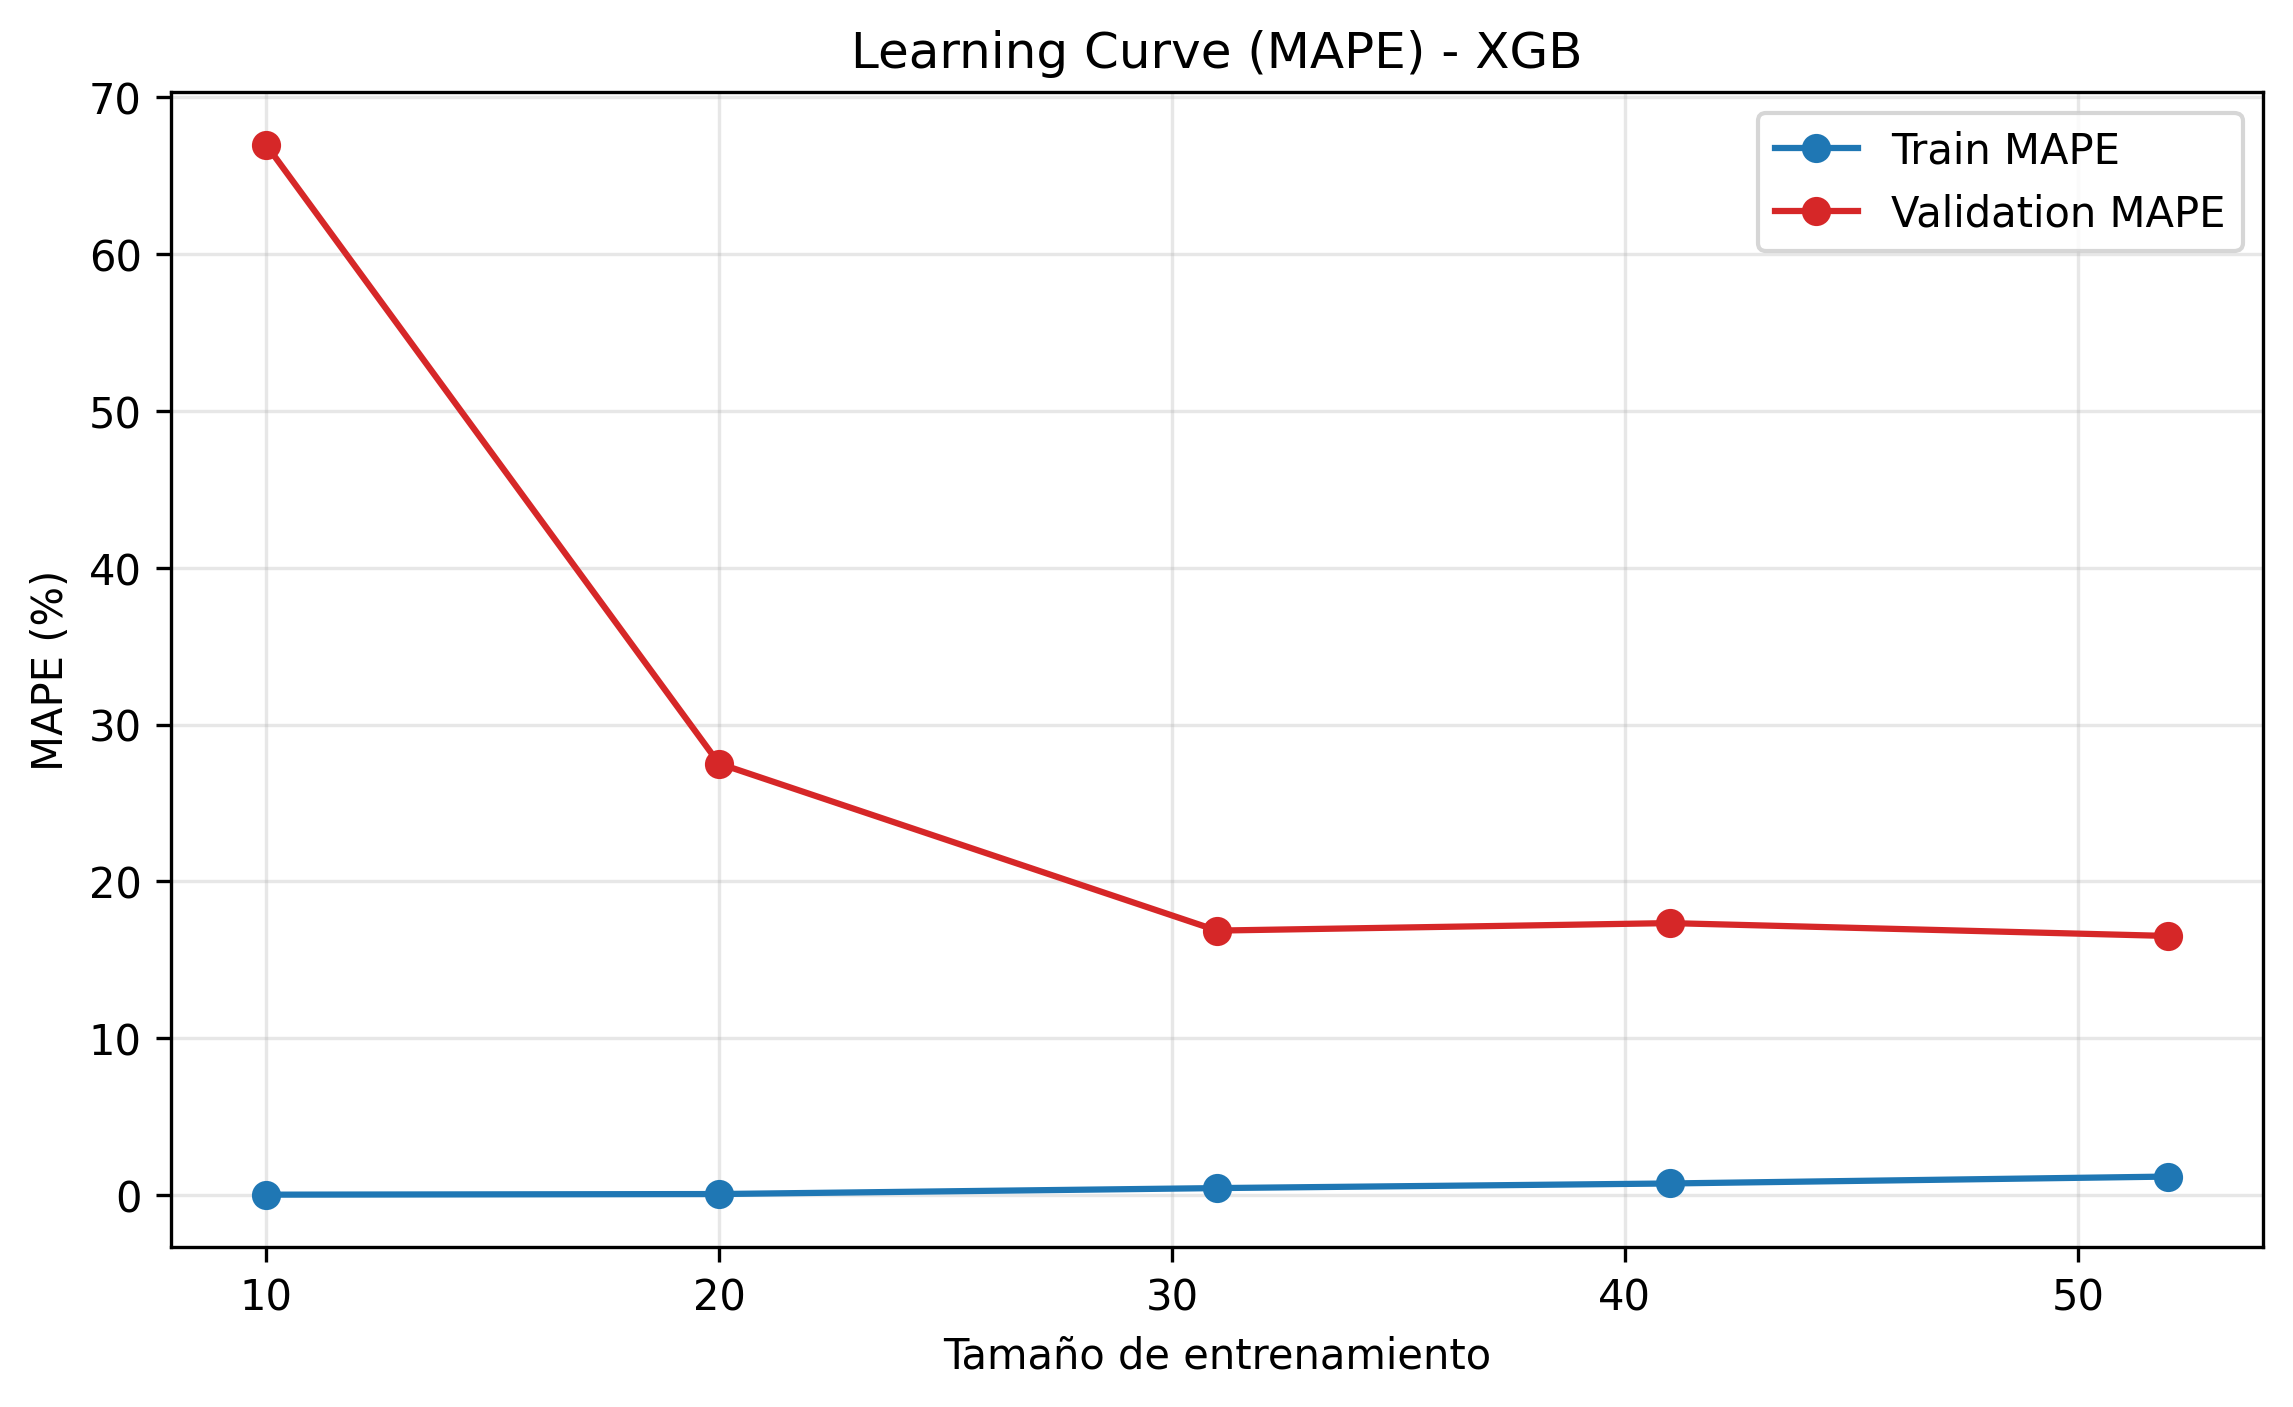

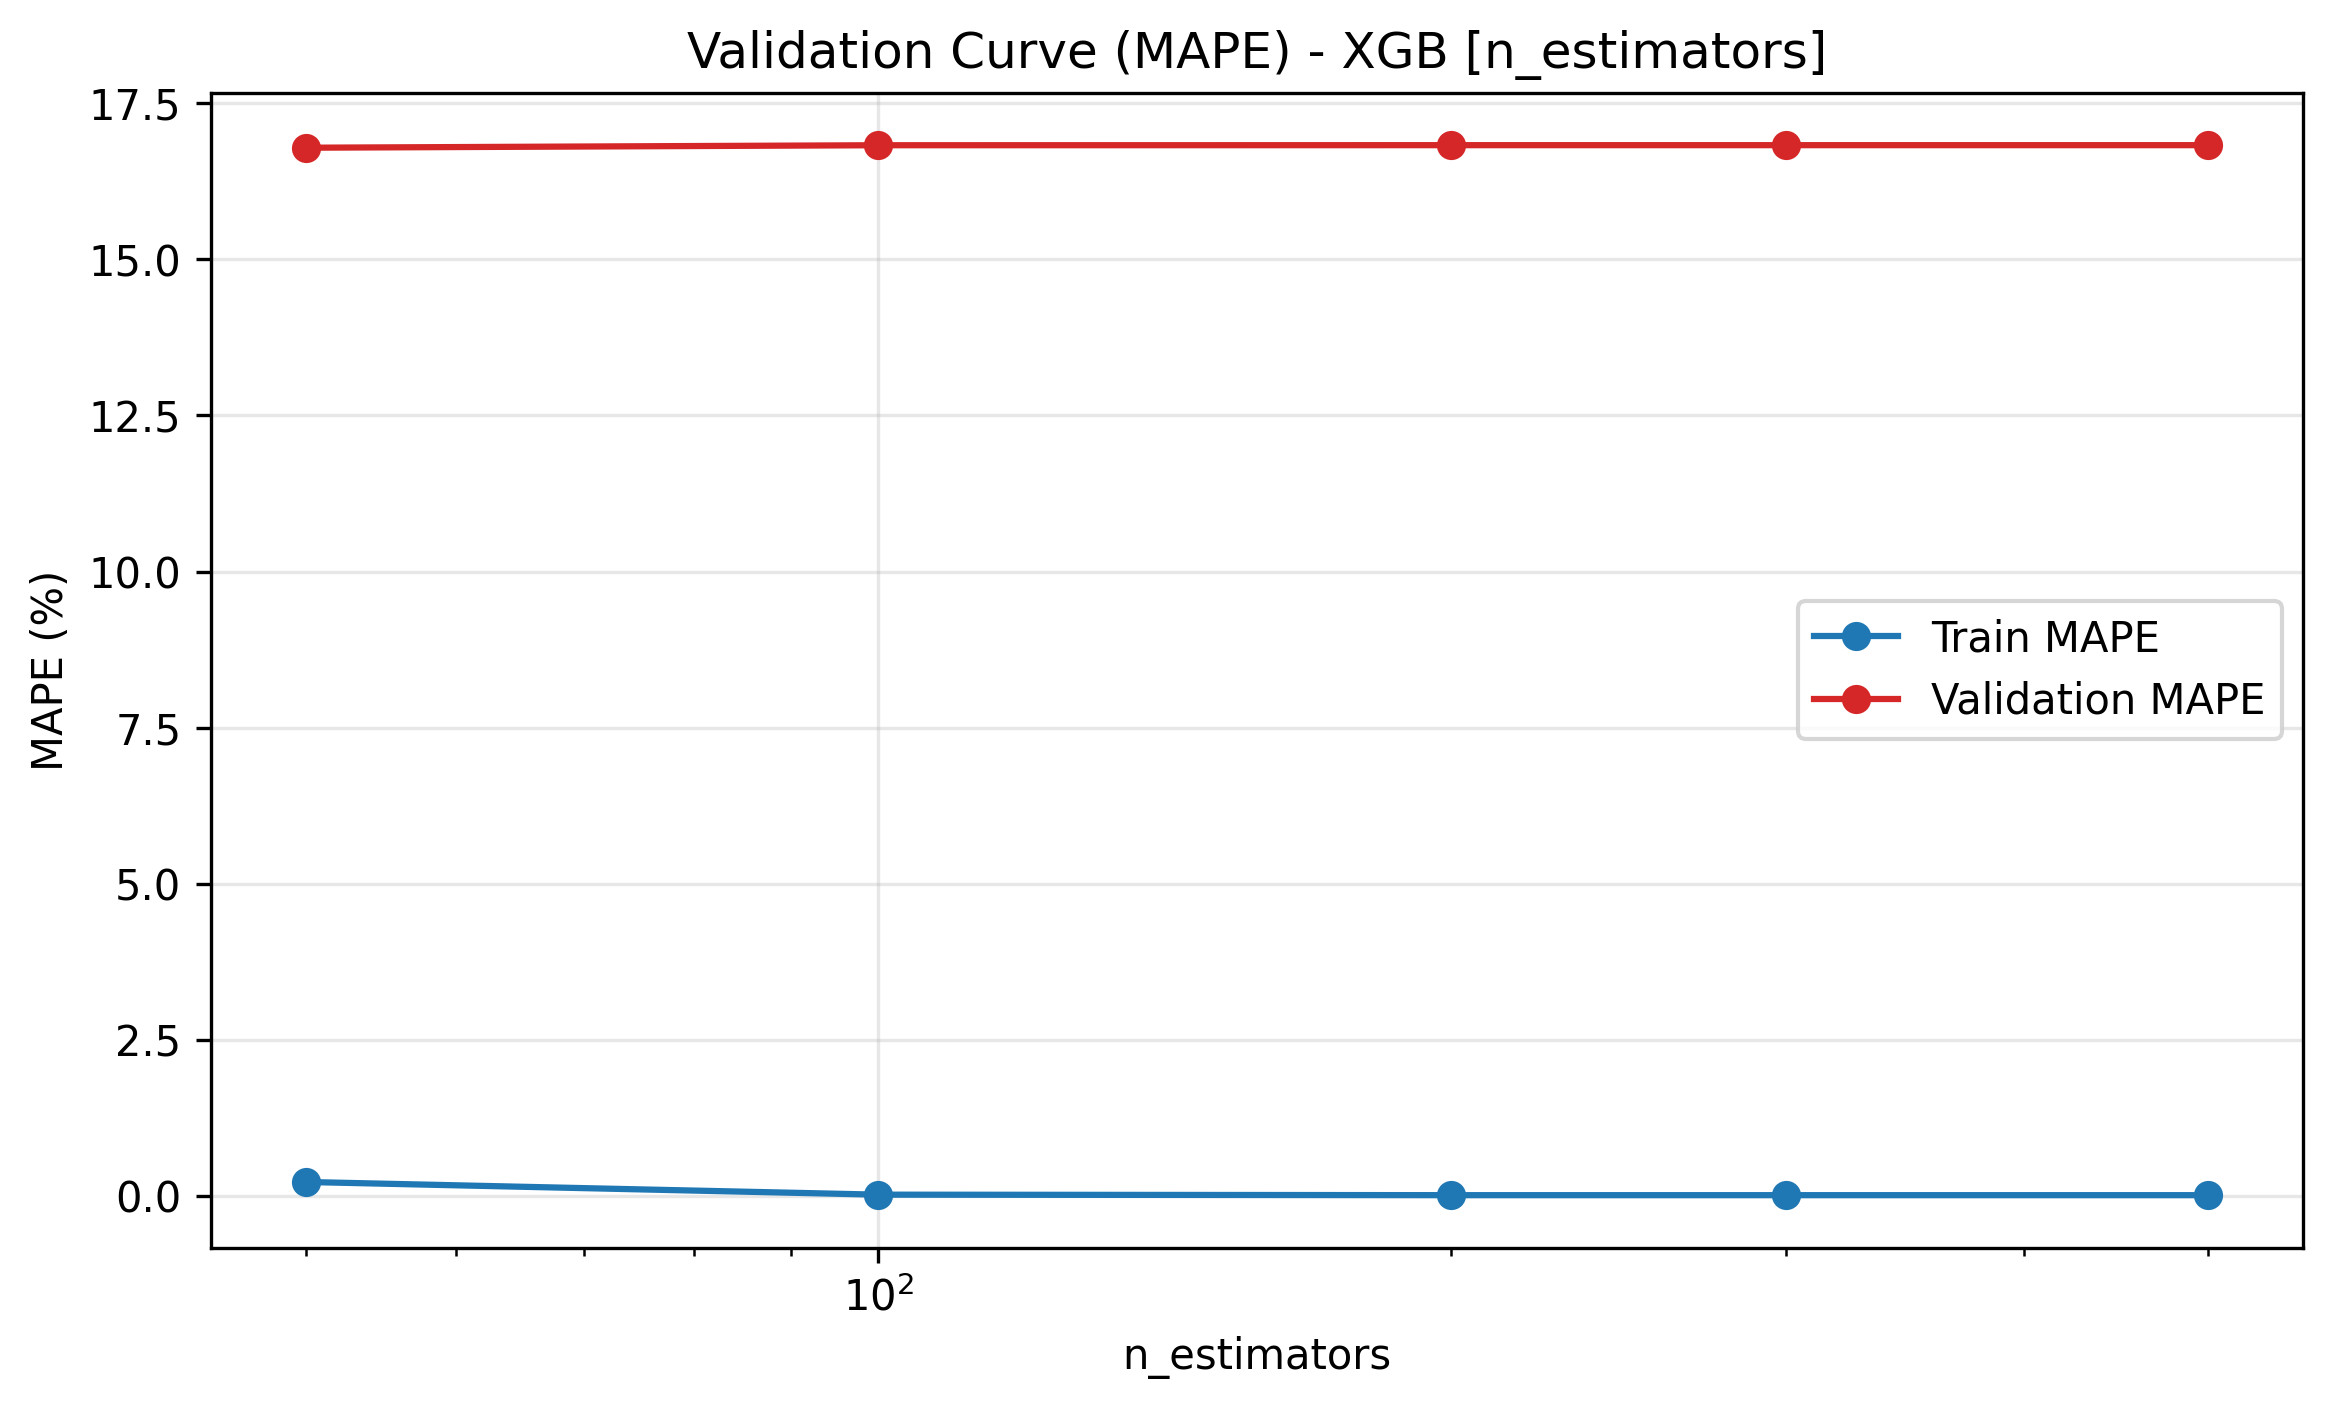

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:03:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [05:03:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


XGB (TEST) -> RMSE: 1.413 | MAE: 1.147 | MAPE: 13.65%


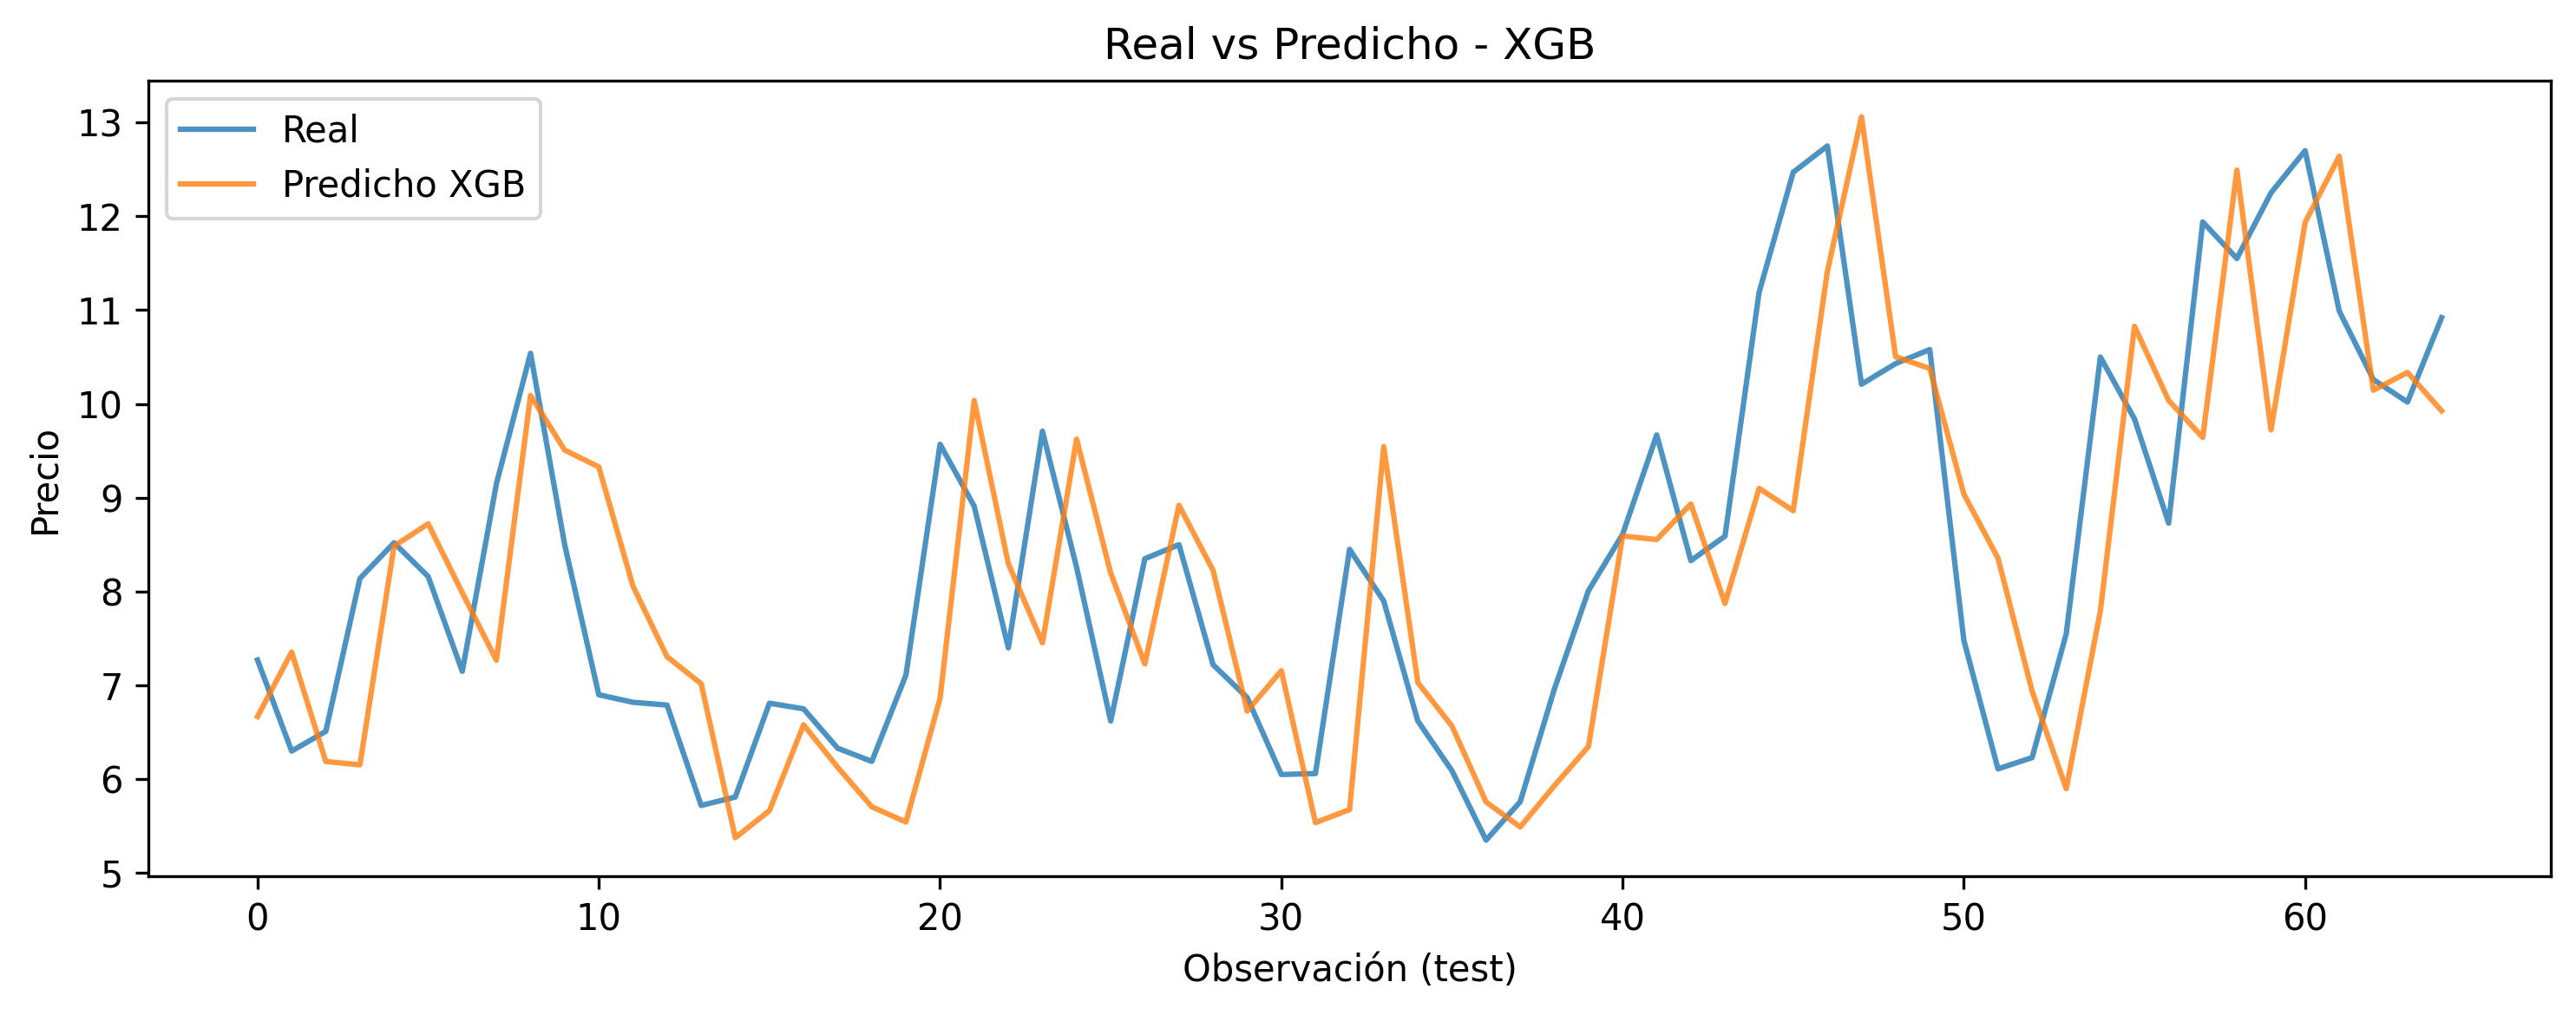

In [ ]:
results = []
for name, model in models.items():
    print(f"\n===== {name} =====")
    plot_learning_curves(model, X_train, y_train, title=name)

    if name == 'Ridge':
        plot_validation_curve_param(Ridge(), X_train, y_train, "alpha", np.logspace(-4, 2, 8), title="Ridge")
    if name == 'XGB':
        plot_validation_curve_param(XGBRegressor(tree_method='gpu_hist'), X_train, y_train, "n_estimators", [50,100,200,300,500], title="XGB")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse, mae, mape = metrics_report(y_test, y_pred, label=f"{name} (TEST)")

    plt.figure(figsize=(10,4), dpi=300)
    plt.plot(y_test, label='Real', alpha=0.8)
    plt.plot(y_pred, label=f'Predicho {name}', alpha=0.8)
    plt.title(f"Real vs Predicho - {name}")
    plt.xlabel("Observación (test)"); plt.ylabel("Precio")
    plt.legend(); plt.tight_layout(); plt.show()

    results.append([name, rmse, mae, mape])

Creación y entrenamiento Modelo base LSTM

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 43.1808 - val_loss: 56.0840 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 37.0874 - val_loss: 41.8706 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 25.1356 - val_loss: 7.8912 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9421 - val_loss: 3.4076 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2057 - val_loss: 4.0176 - learning_rate: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7694 - val_loss: 2.9593 - learning_rate: 0.0010
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6918 - val_loss: 2.9171 - learning_rate: 0.0010
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7997 - val_loss: 2.6027 - learning_rate: 0.0010
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9083 - val_loss: 2.4756 - learning_rate: 0.0010
Epoch 10/100
19/19 ━━━━━━

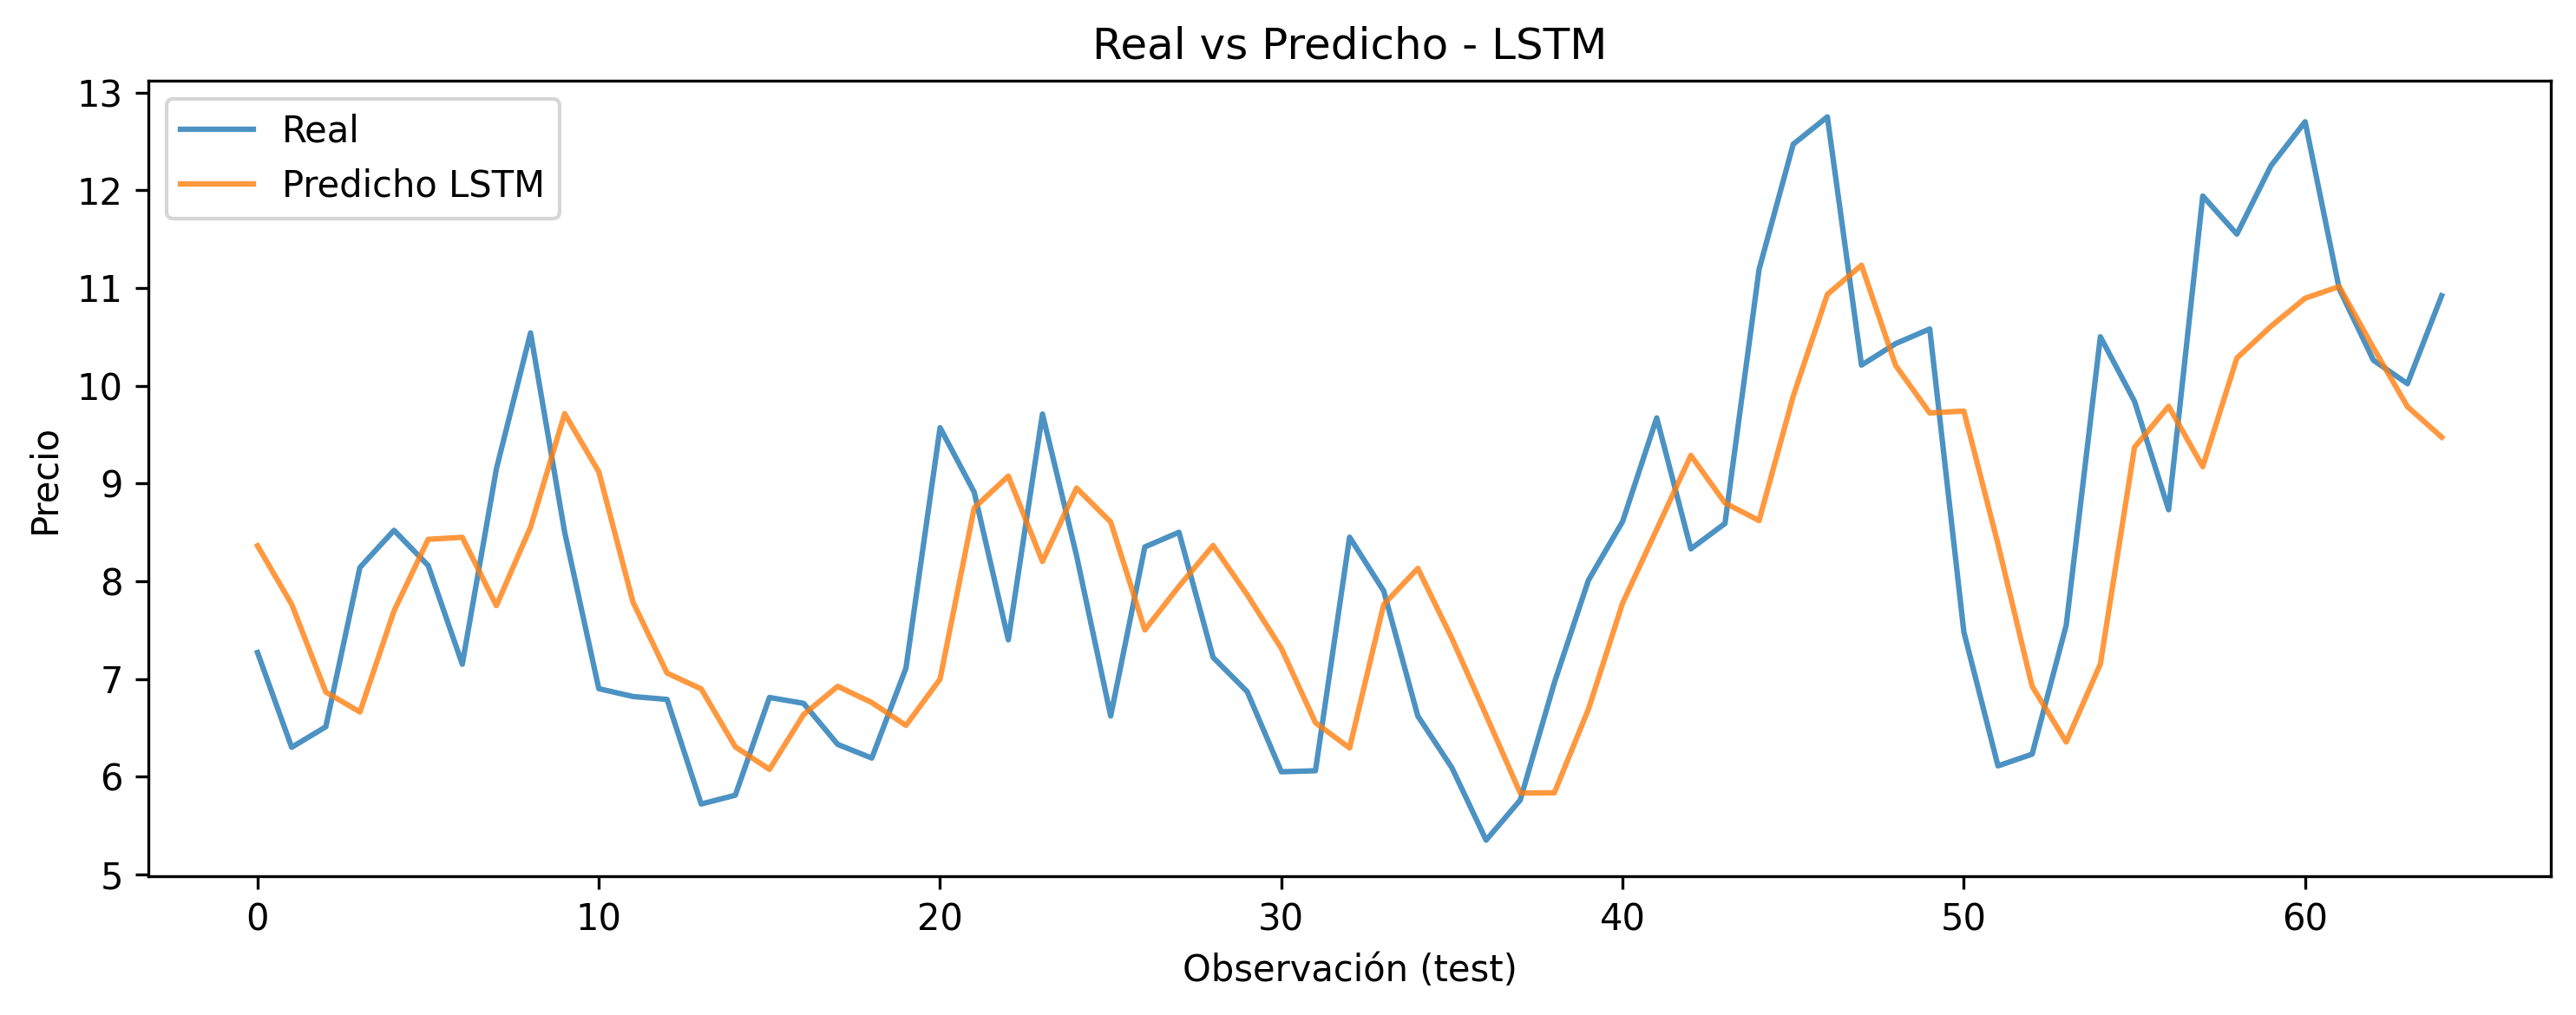

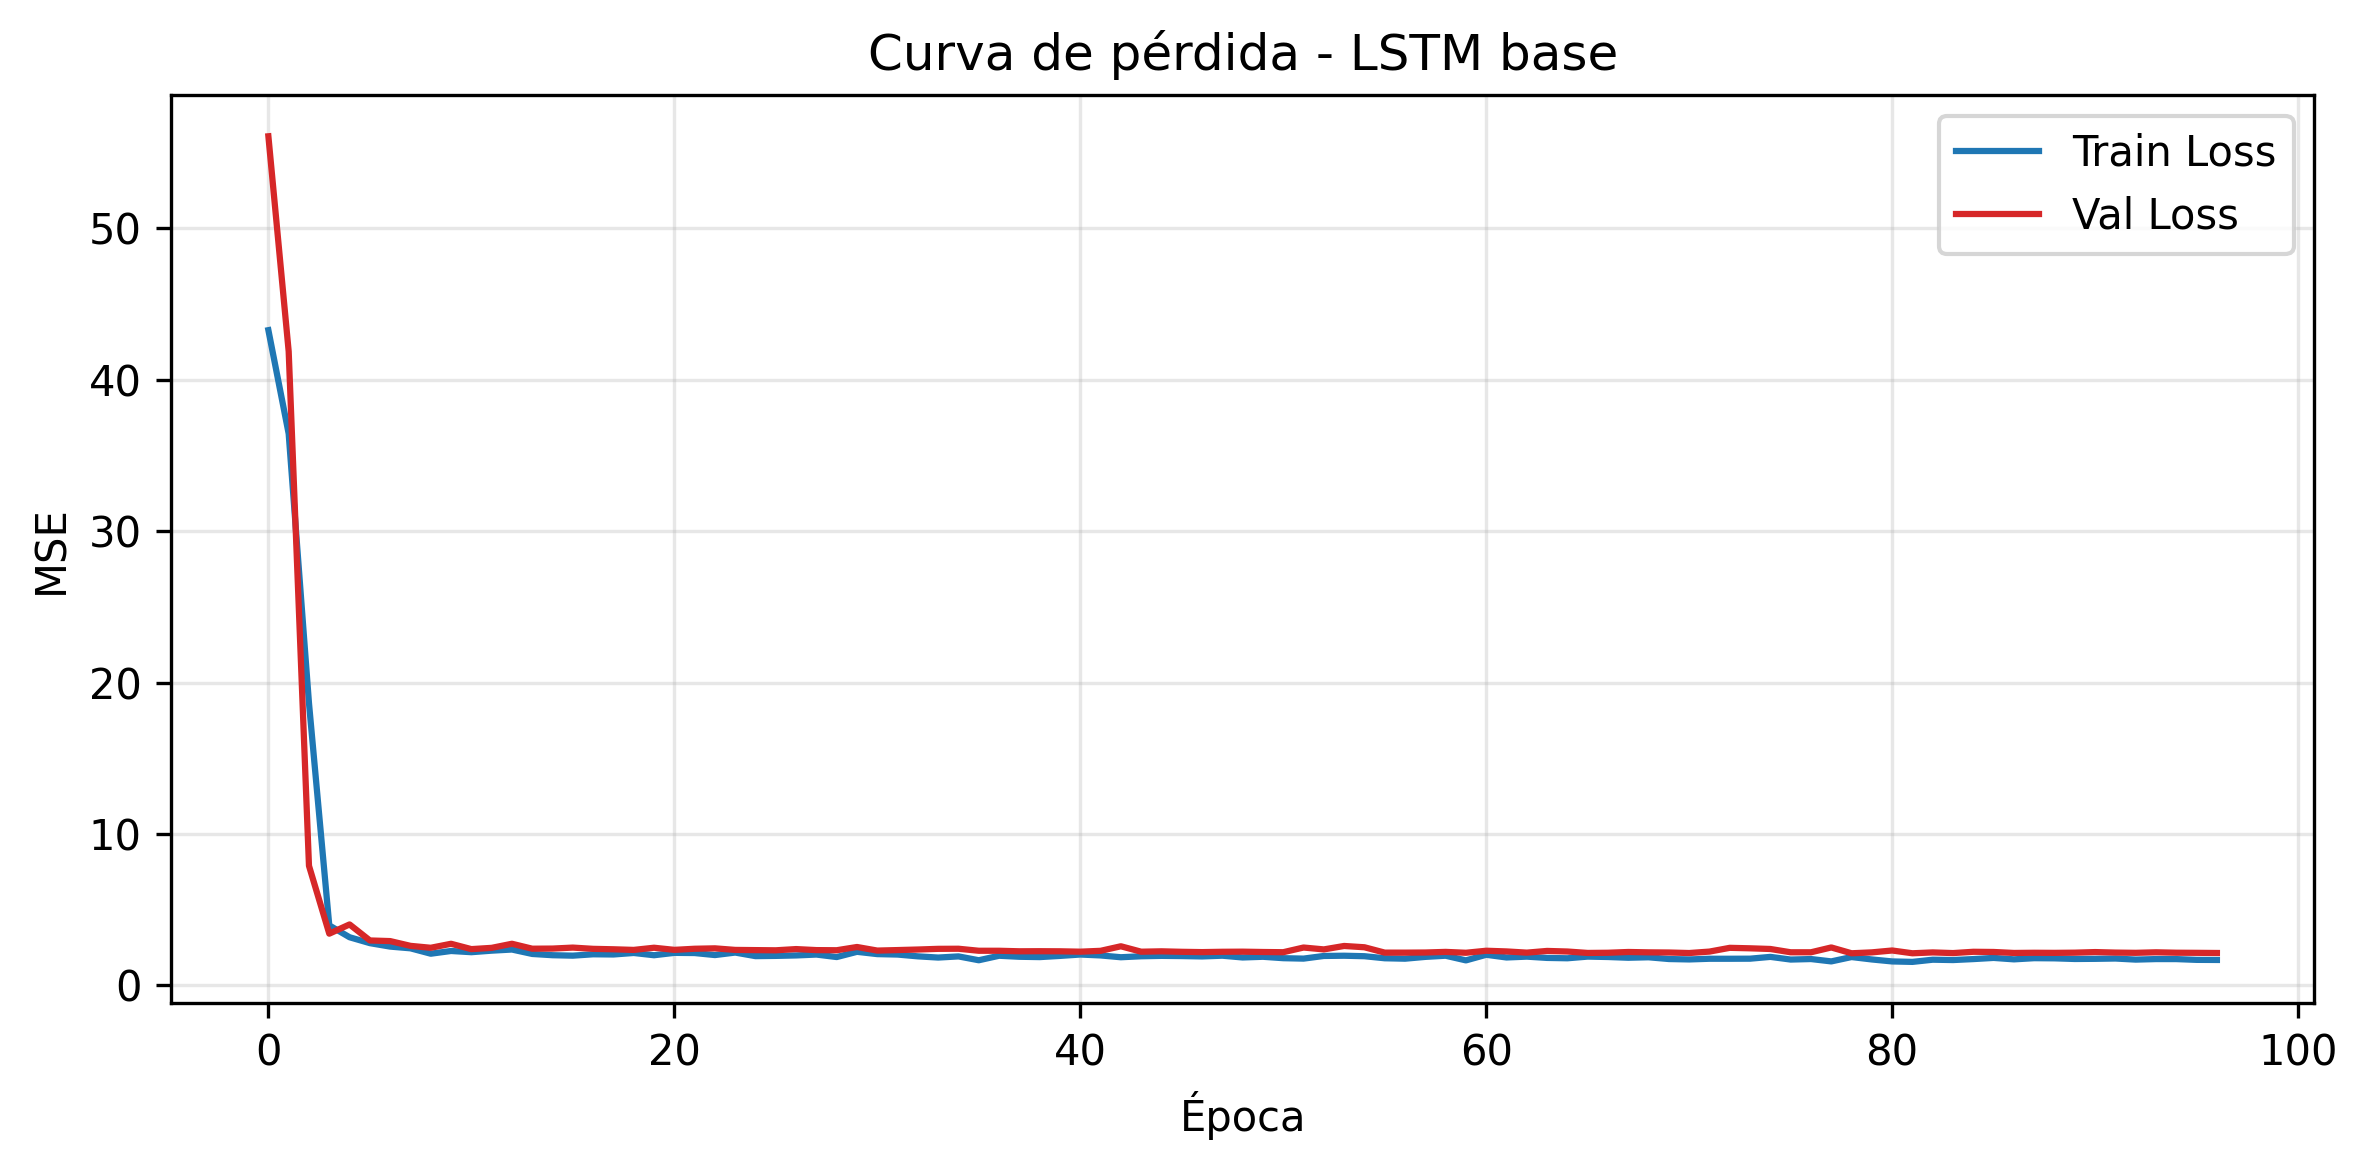

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Convertir X en secuencias 3D ---
def to_seq(X):
    return X.reshape((X.shape[0], X.shape[1], 1))

X_train_seq = to_seq(X_train)
X_val_seq   = to_seq(X_val)
X_test_seq  = to_seq(X_test)

# --- Crear modelo base ---
def build_lstm_model(units=50, dropout=0.2):
    model = Sequential([
        LSTM(units, activation='tanh', input_shape=(X_train_seq.shape[1], 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

# --- Entrenar modelo base ---
lstm_base = build_lstm_model()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=7, factor=0.5, verbose=1)
]

history = lstm_base.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=100,
    batch_size=16,
    verbose=1,
    callbacks=callbacks
)

# --- Evaluación en test ---
y_pred_lstm = lstm_base.predict(X_test_seq).flatten()
rmse_lstm, mae_lstm, mape_lstm = metrics_report(y_test, y_pred_lstm, label="LSTM (TEST)")

# --- Guardar resultados ---
results.append(["LSTM", rmse_lstm, mae_lstm, mape_lstm])

# --- Gráfico Real vs Predicho ---
plt.figure(figsize=(10,4), dpi=300)
plt.plot(y_test, label='Real', alpha=0.8)
plt.plot(y_pred_lstm, label='Predicho LSTM', alpha=0.8)
plt.title("Real vs Predicho - LSTM")
plt.xlabel("Observación (test)"); plt.ylabel("Precio")
plt.legend(); plt.tight_layout(); plt.show()

# --- Curva de pérdida ---
plt.figure(figsize=(8,4), dpi=300)
plt.plot(history.history['loss'], label='Train Loss', color='C0')
plt.plot(history.history['val_loss'], label='Val Loss', color='C3')
plt.title("Curva de pérdida - LSTM base")
plt.xlabel("Época"); plt.ylabel("MSE")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()



Comparación final

In [ ]:
df_res = pd.DataFrame(results, columns=['Modelo', 'RMSE', 'MAE', 'MAPE_%']).sort_values('MAPE_%')
print("\n=== Resultados (ordenado por MAPE) ===")
print(df_res.to_string(index=False))


=== Resultados (ordenado por MAPE) ===
Modelo     RMSE      MAE    MAPE_%
 Ridge 1.285269 0.996848 11.543667
   MLP 1.249967 1.012275 11.796643
   XGB 1.412902 1.146690 13.647472


# **Estrategia de mejora 1**

Carga de datos y utilidades

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from math import sqrt

# Modelos clásicos
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

# XGBoost (opcional con GPU)
HAS_XGB = True
try:
    from xgboost import XGBRegressor
except Exception:
    HAS_XGB = False
    print("⚠️ xgboost no disponible, se omitirá XGBRegressor.")

# LSTM (Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

Métricas y funciones auxiliares

In [ ]:
def MAPE(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    denom = np.maximum(np.abs(y_true), eps)        # evita división por cero
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

mape_scorer = make_scorer(MAPE, greater_is_better=False)

def report(y_true, y_pred, tag):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = MAPE(y_true, y_pred)
    print(f"{tag} -> RMSE: {rmse:.3f} | MAE: {mae:.3f} | MAPE: {mape:.2f}%")
    return rmse, mae, mape

def plot_learning_curve_mape(model, X, y, tscv, title):
    ts, tr_scores, va_scores = learning_curve(
        model, X, y, cv=tscv, scoring=mape_scorer,
        train_sizes=np.linspace(0.2, 1.0, 5), n_jobs=-1, shuffle=False
    )
    tr = -tr_scores.mean(axis=1)
    va = -va_scores.mean(axis=1)

    plt.figure(figsize=(9,5), dpi=300)
    plt.plot(ts, tr, 'o-', label='Train MAPE', color='C0')
    plt.plot(ts, va, 'o-', label='Validation MAPE', color='C3')
    plt.title(f"Learning Curve (MAPE) - {title}")
    plt.xlabel("Tamaño de entrenamiento"); plt.ylabel("MAPE (%)")
    plt.grid(alpha=0.3); plt.legend(); plt.show()

def plot_validation_curve_mape(model, X, y, param_name, param_range, tscv, title, log_scale=True):
    tr_scores, va_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range,
        cv=tscv, scoring=mape_scorer, n_jobs=-1
    )
    tr = -tr_scores.mean(axis=1)
    va = -va_scores.mean(axis=1)

    plt.figure(figsize=(9,5), dpi=300)
    plt.plot(param_range, tr, 'o-', label='Train MAPE', color='C0')
    plt.plot(param_range, va, 'o-', label='Val MAPE', color='C3')
    if log_scale: plt.xscale('log')
    plt.title(f"Validation Curve - {title} [{param_name}]")
    plt.xlabel(param_name); plt.ylabel("MAPE (%)")
    plt.grid(alpha=0.3); plt.legend(); plt.show()

Preparación de datos (Fecha, lags, split 70/15/15)

In [ ]:
# df = pd.read_excel('precio_ecuador.xlsx')  # <- ya lo tienes cargado
assert {'Año','Semana','Precio'}.issubset(df.columns), "Faltan columnas requeridas"

# Fecha (lunes de cada semana), ordenar
df['Fecha'] = pd.to_datetime(df['Año'].astype(str) + df['Semana'].astype(str) + '1', format='%G%V%u')
df = df.sort_values('Fecha').reset_index(drop=True)

# Generar lags (objetivo sin escalar)
N_LAGS = 5
for i in range(1, N_LAGS+1):
    df[f'Precio_t-{i}'] = df['Precio'].shift(i)
df = df.dropna().reset_index(drop=True)

features = [c for c in df.columns if c.startswith('Precio_t-')]
target   = 'Precio'

# Escalar SOLO X (no y para no distorsionar MAPE)
scaler_X = MinMaxScaler()
X_all = scaler_X.fit_transform(df[features])
y_all = df[target].values.astype(float)

# Split temporal 70/15/15
n = len(df)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)
X_train, X_val, X_test = X_all[:train_end], X_all[train_end:val_end], X_all[val_end:]
y_train, y_val, y_test = y_all[:train_end], y_all[train_end:val_end], y_all[val_end:]

print(f"Splits -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
tscv = TimeSeriesSplit(n_splits=5)

GRIDSEARCH - Ridge

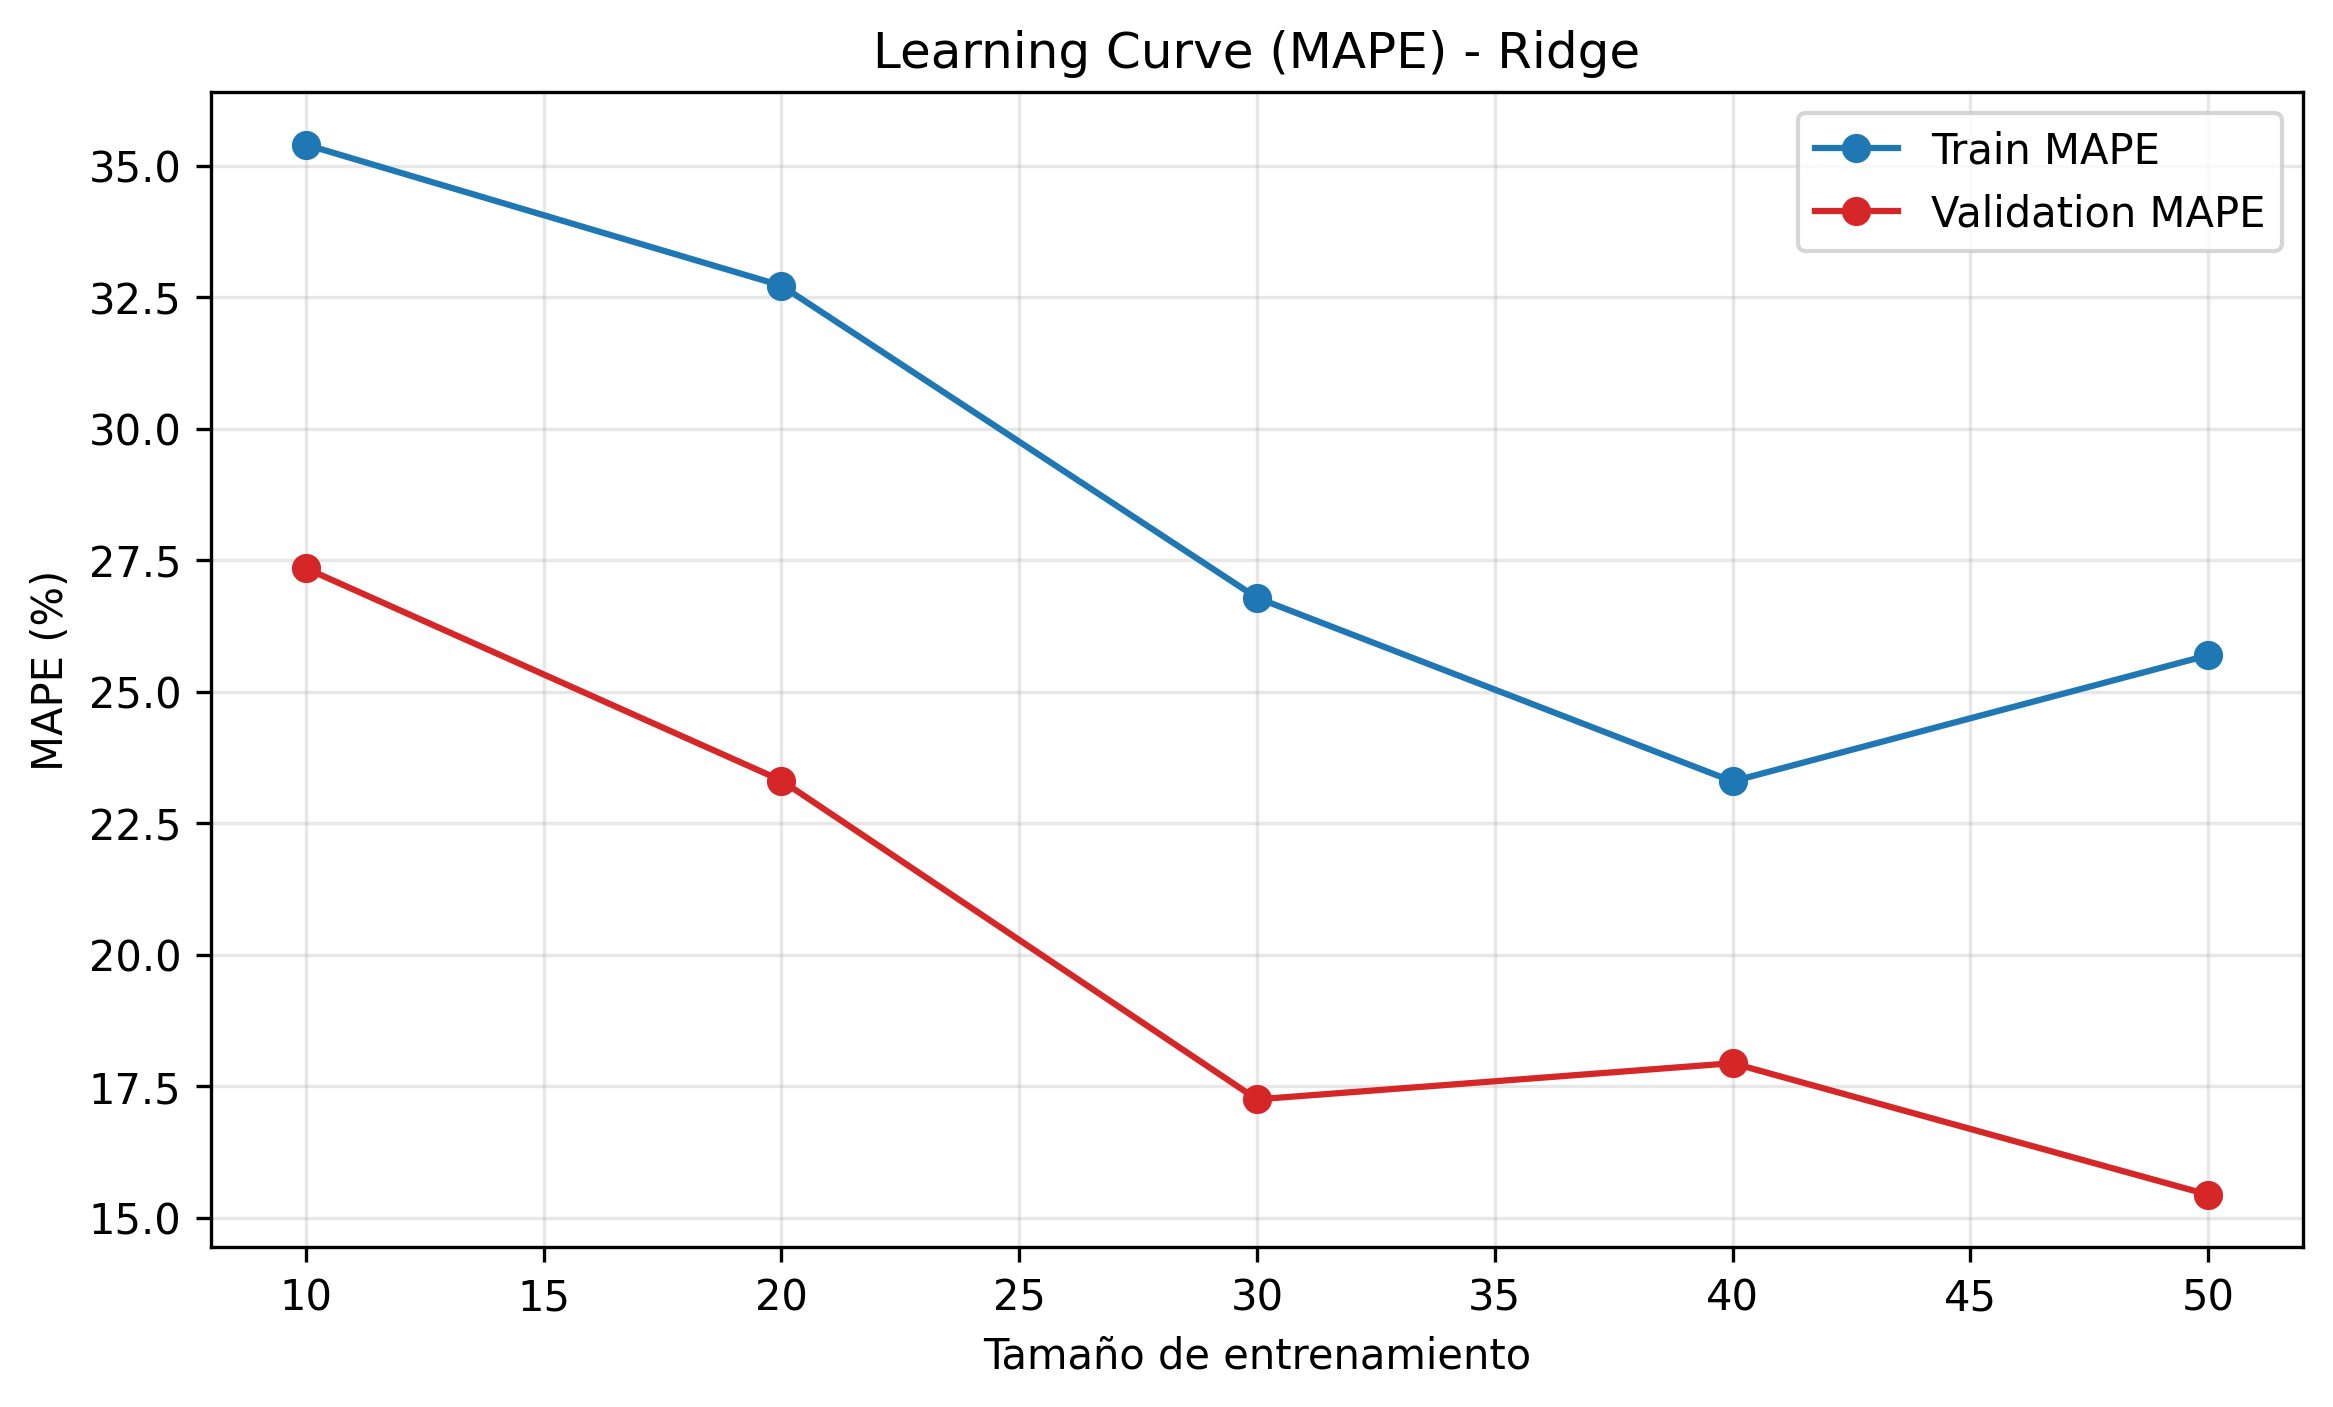

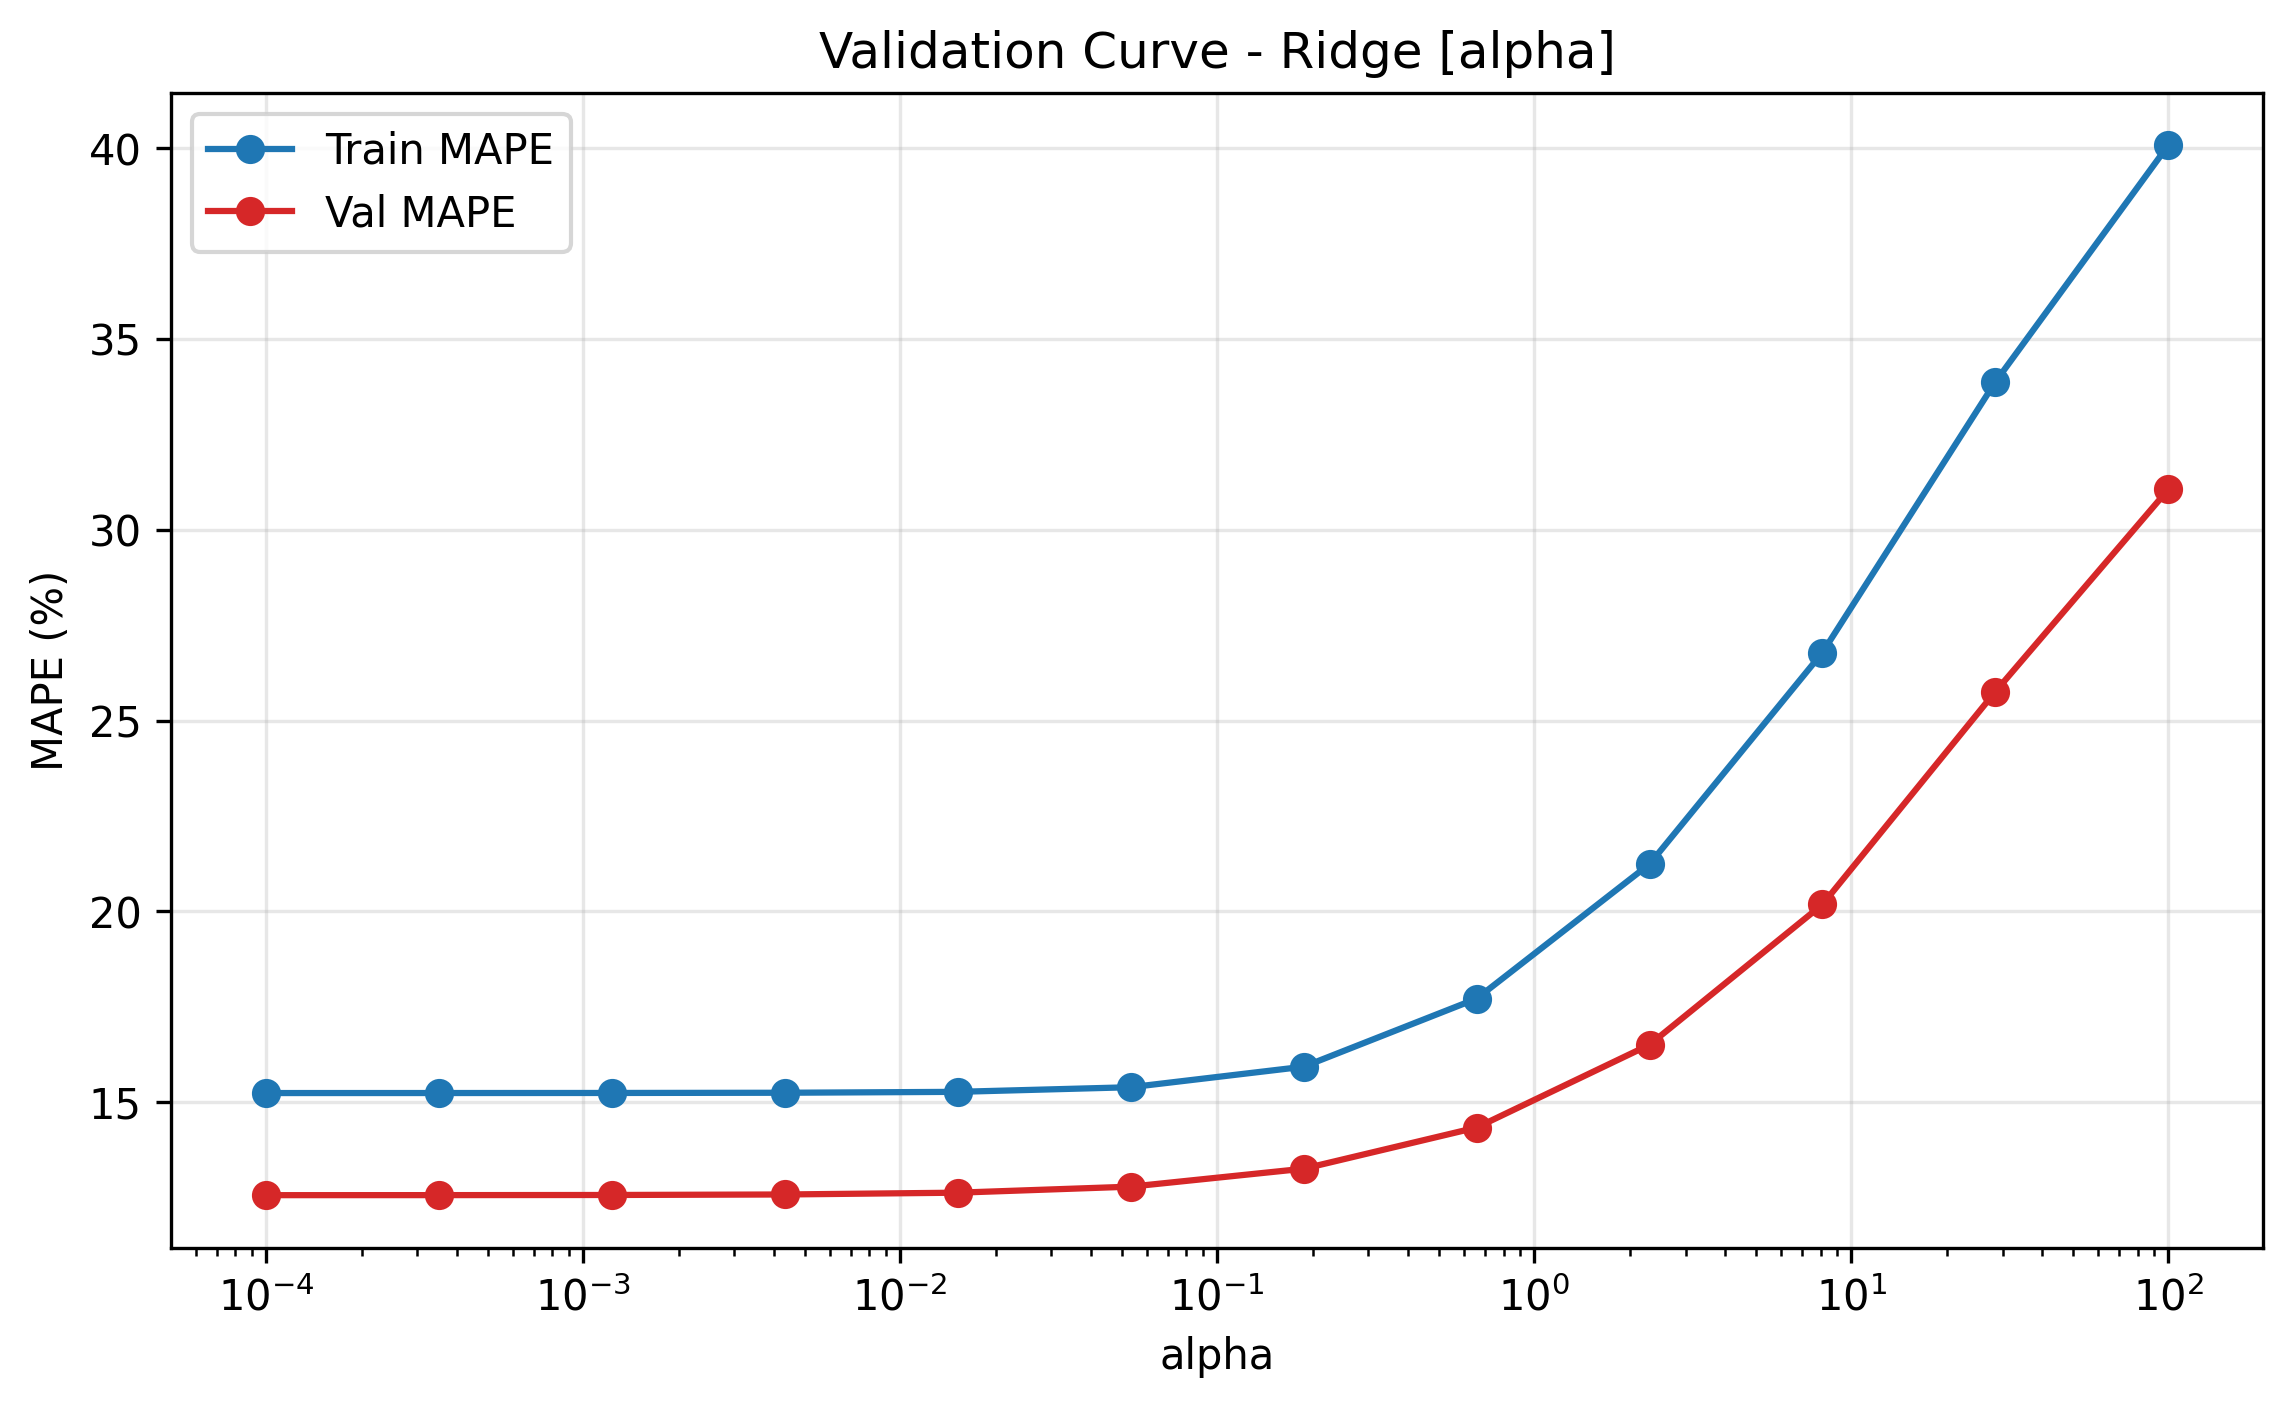

Ridge best params: {'alpha': np.float64(0.0001)}
Ridge (TEST) -> RMSE: 1.245 | MAE: 0.973 | MAPE: 11.25%


In [ ]:
ridge = Ridge(random_state=RANDOM_STATE)
ridge_grid = {'alpha': np.logspace(-4, 2, 12)}
ridge_gs = GridSearchCV(ridge, ridge_grid, cv=tscv, scoring=mape_scorer, n_jobs=-1)
plot_learning_curve_mape(ridge, X_train, y_train, tscv, "Ridge")
plot_validation_curve_mape(Ridge(), X_train, y_train, "alpha", ridge_grid['alpha'], tscv, "Ridge", log_scale=True)
ridge_gs.fit(X_train, y_train)
print("Ridge best params:", ridge_gs.best_params_)
y_pred_ridge = ridge_gs.predict(X_test)
ridge_metrics = report(y_test, y_pred_ridge, "Ridge (TEST)")

GRIDSEARCH - MLP

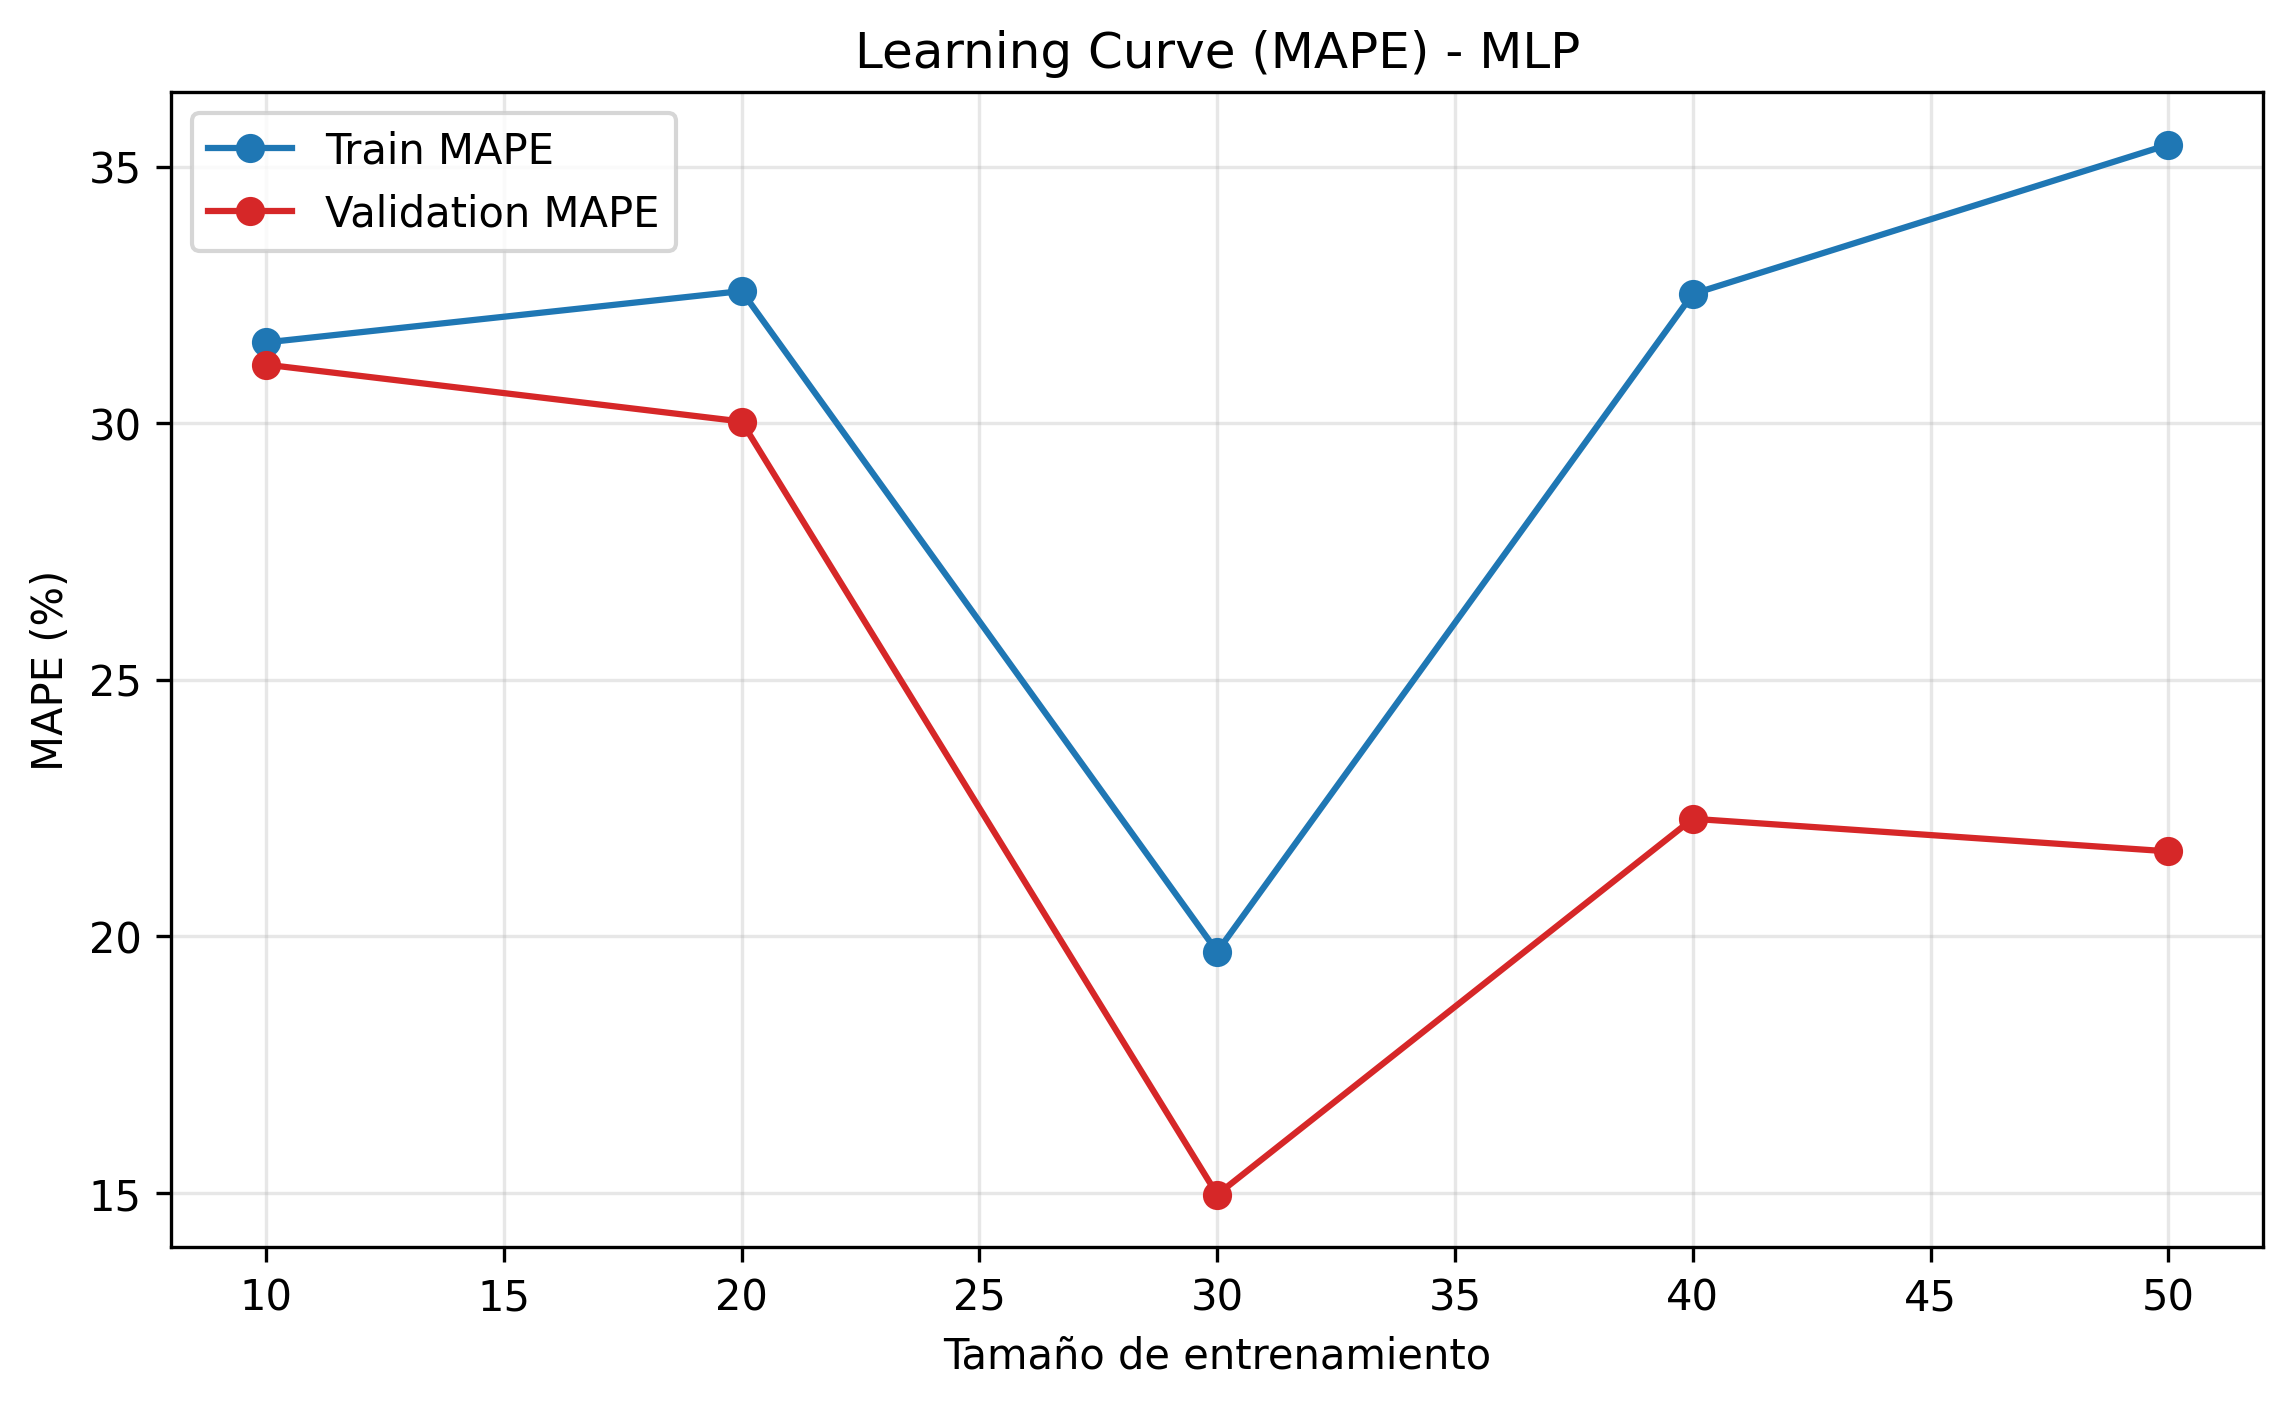

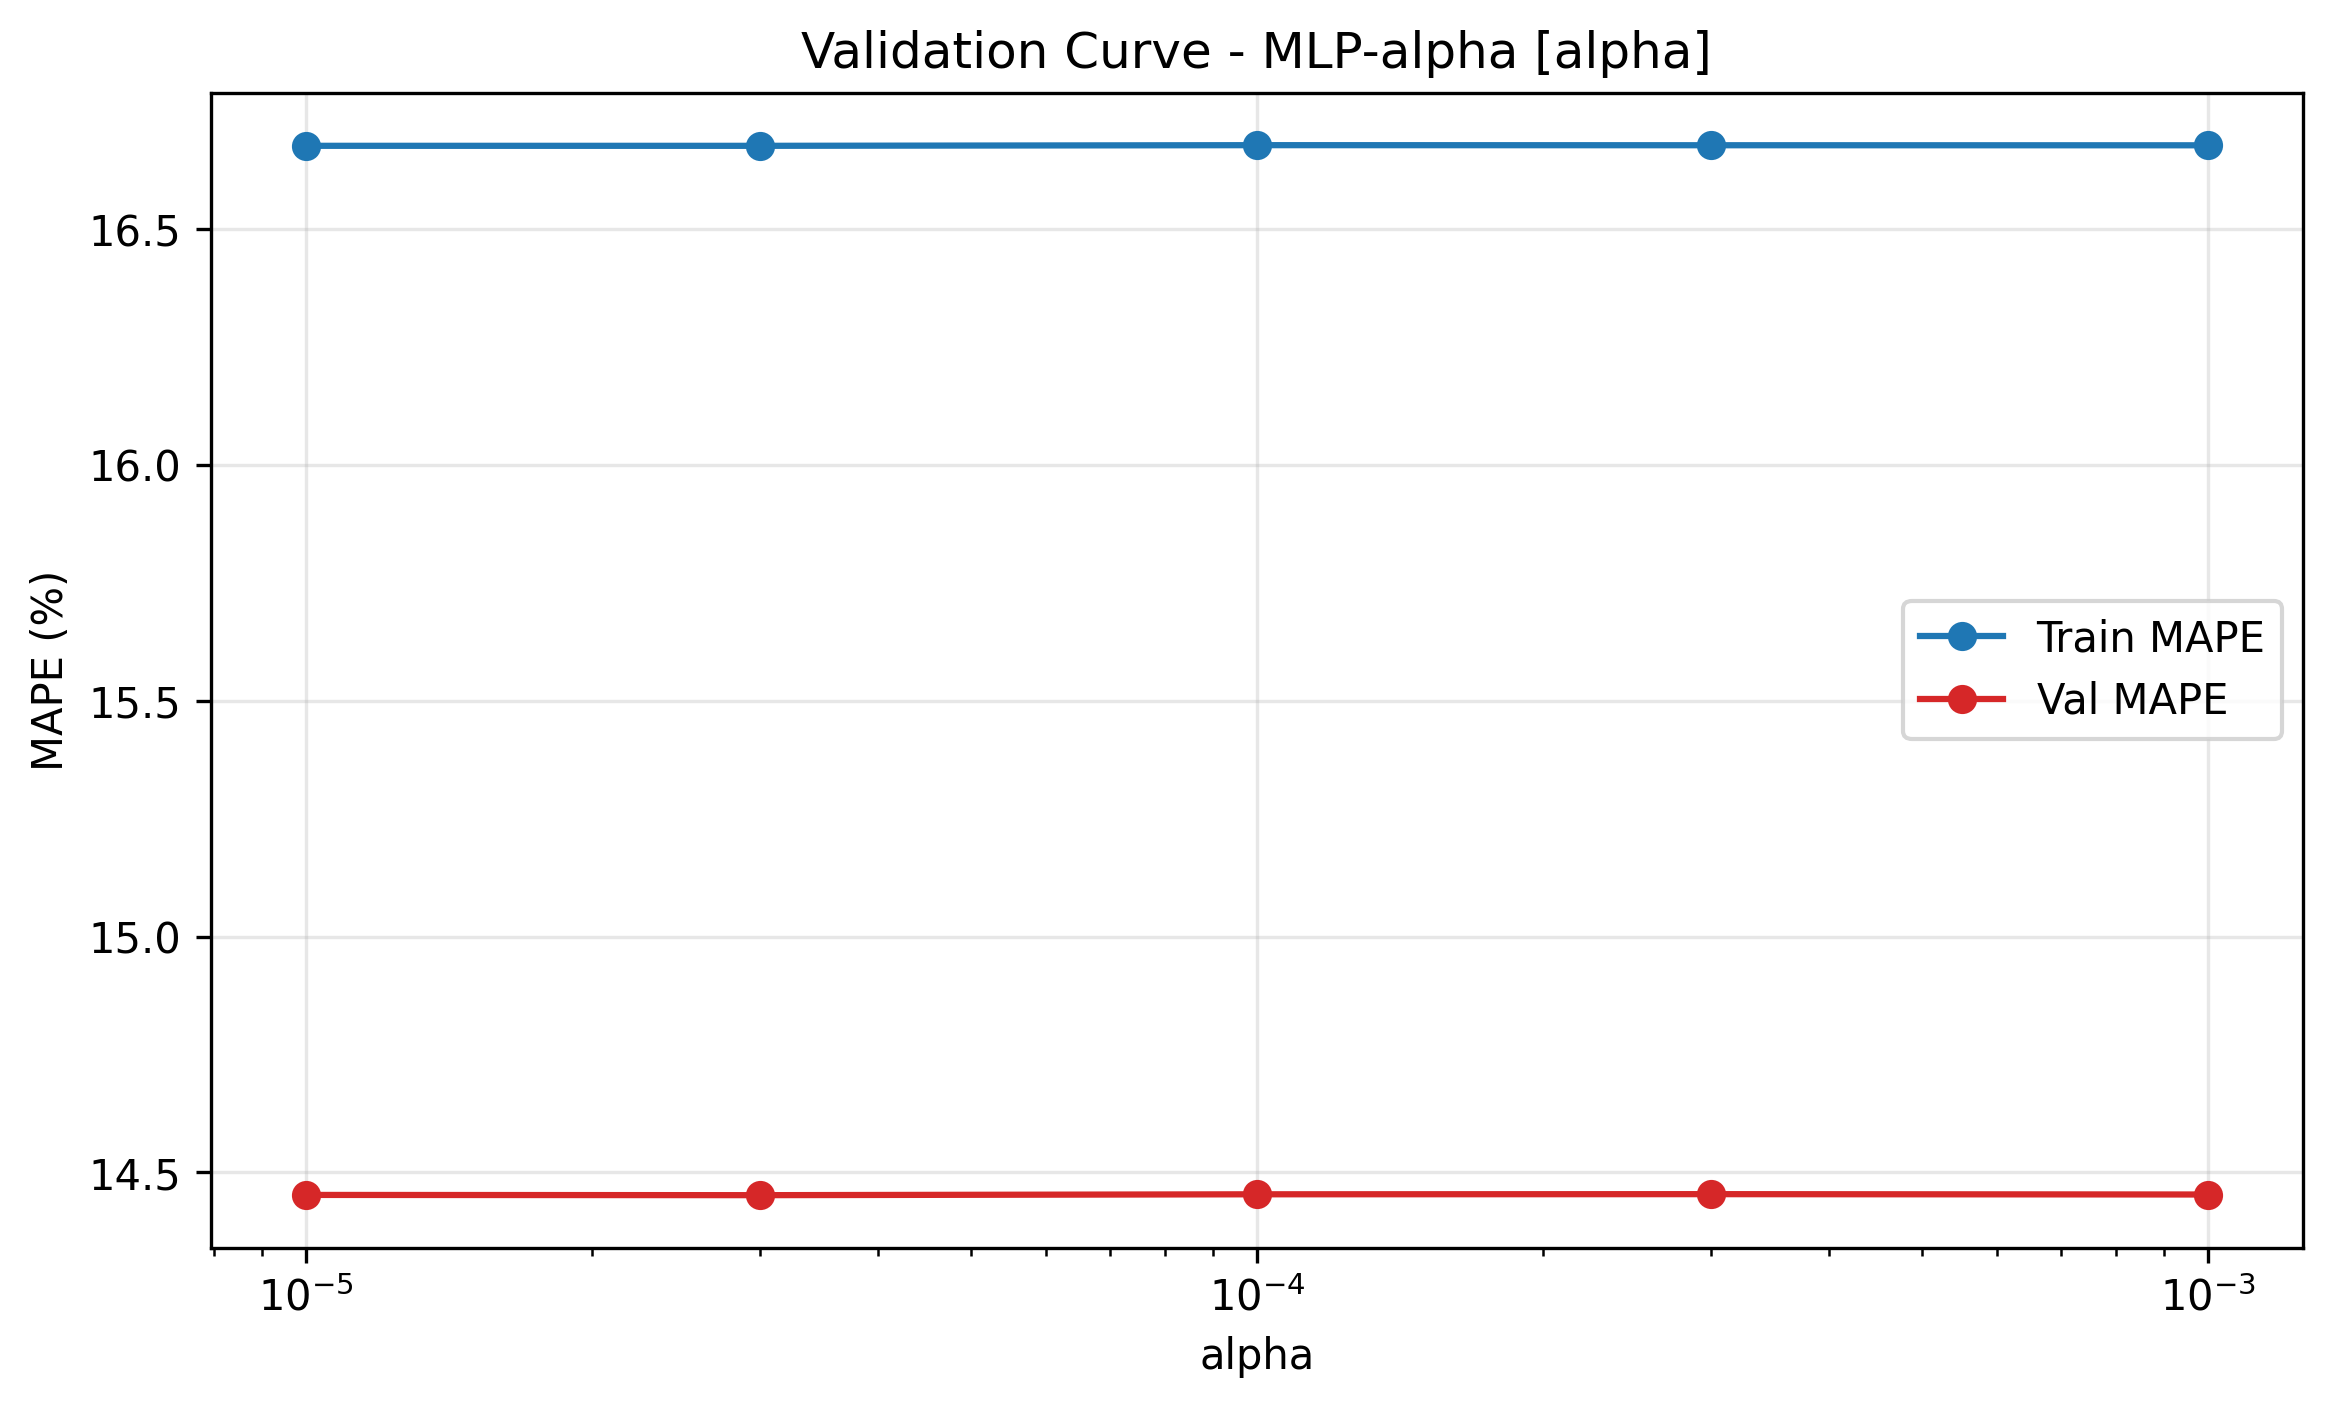

MLP best params: {'alpha': 3e-05, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.003}
MLP (TEST) -> RMSE: 1.439 | MAE: 1.150 | MAPE: 13.28%


In [ ]:
mlp = MLPRegressor(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True,
                   validation_fraction=0.15, n_iter_no_change=25)
mlp_grid = {
    'hidden_layer_sizes': [(32,32), (64,32), (64,64)],
    'alpha': [1e-5, 3e-5, 1e-4, 3e-4, 1e-3],
    'learning_rate_init': [1e-3, 3e-3, 1e-4]
}
plot_learning_curve_mape(mlp, X_train, y_train, tscv, "MLP")
plot_validation_curve_mape(MLPRegressor(max_iter=1000, random_state=RANDOM_STATE),
                           X_train, y_train, "alpha", mlp_grid['alpha'], tscv, "MLP-alpha", log_scale=True)
mlp_gs = GridSearchCV(mlp, mlp_grid, cv=tscv, scoring=mape_scorer, n_jobs=-1)
mlp_gs.fit(X_train, y_train)
print("MLP best params:", mlp_gs.best_params_)
y_pred_mlp = mlp_gs.predict(X_test)
mlp_metrics = report(y_test, y_pred_mlp, "MLP (TEST)")

GRIDSEARCH - XGBoost

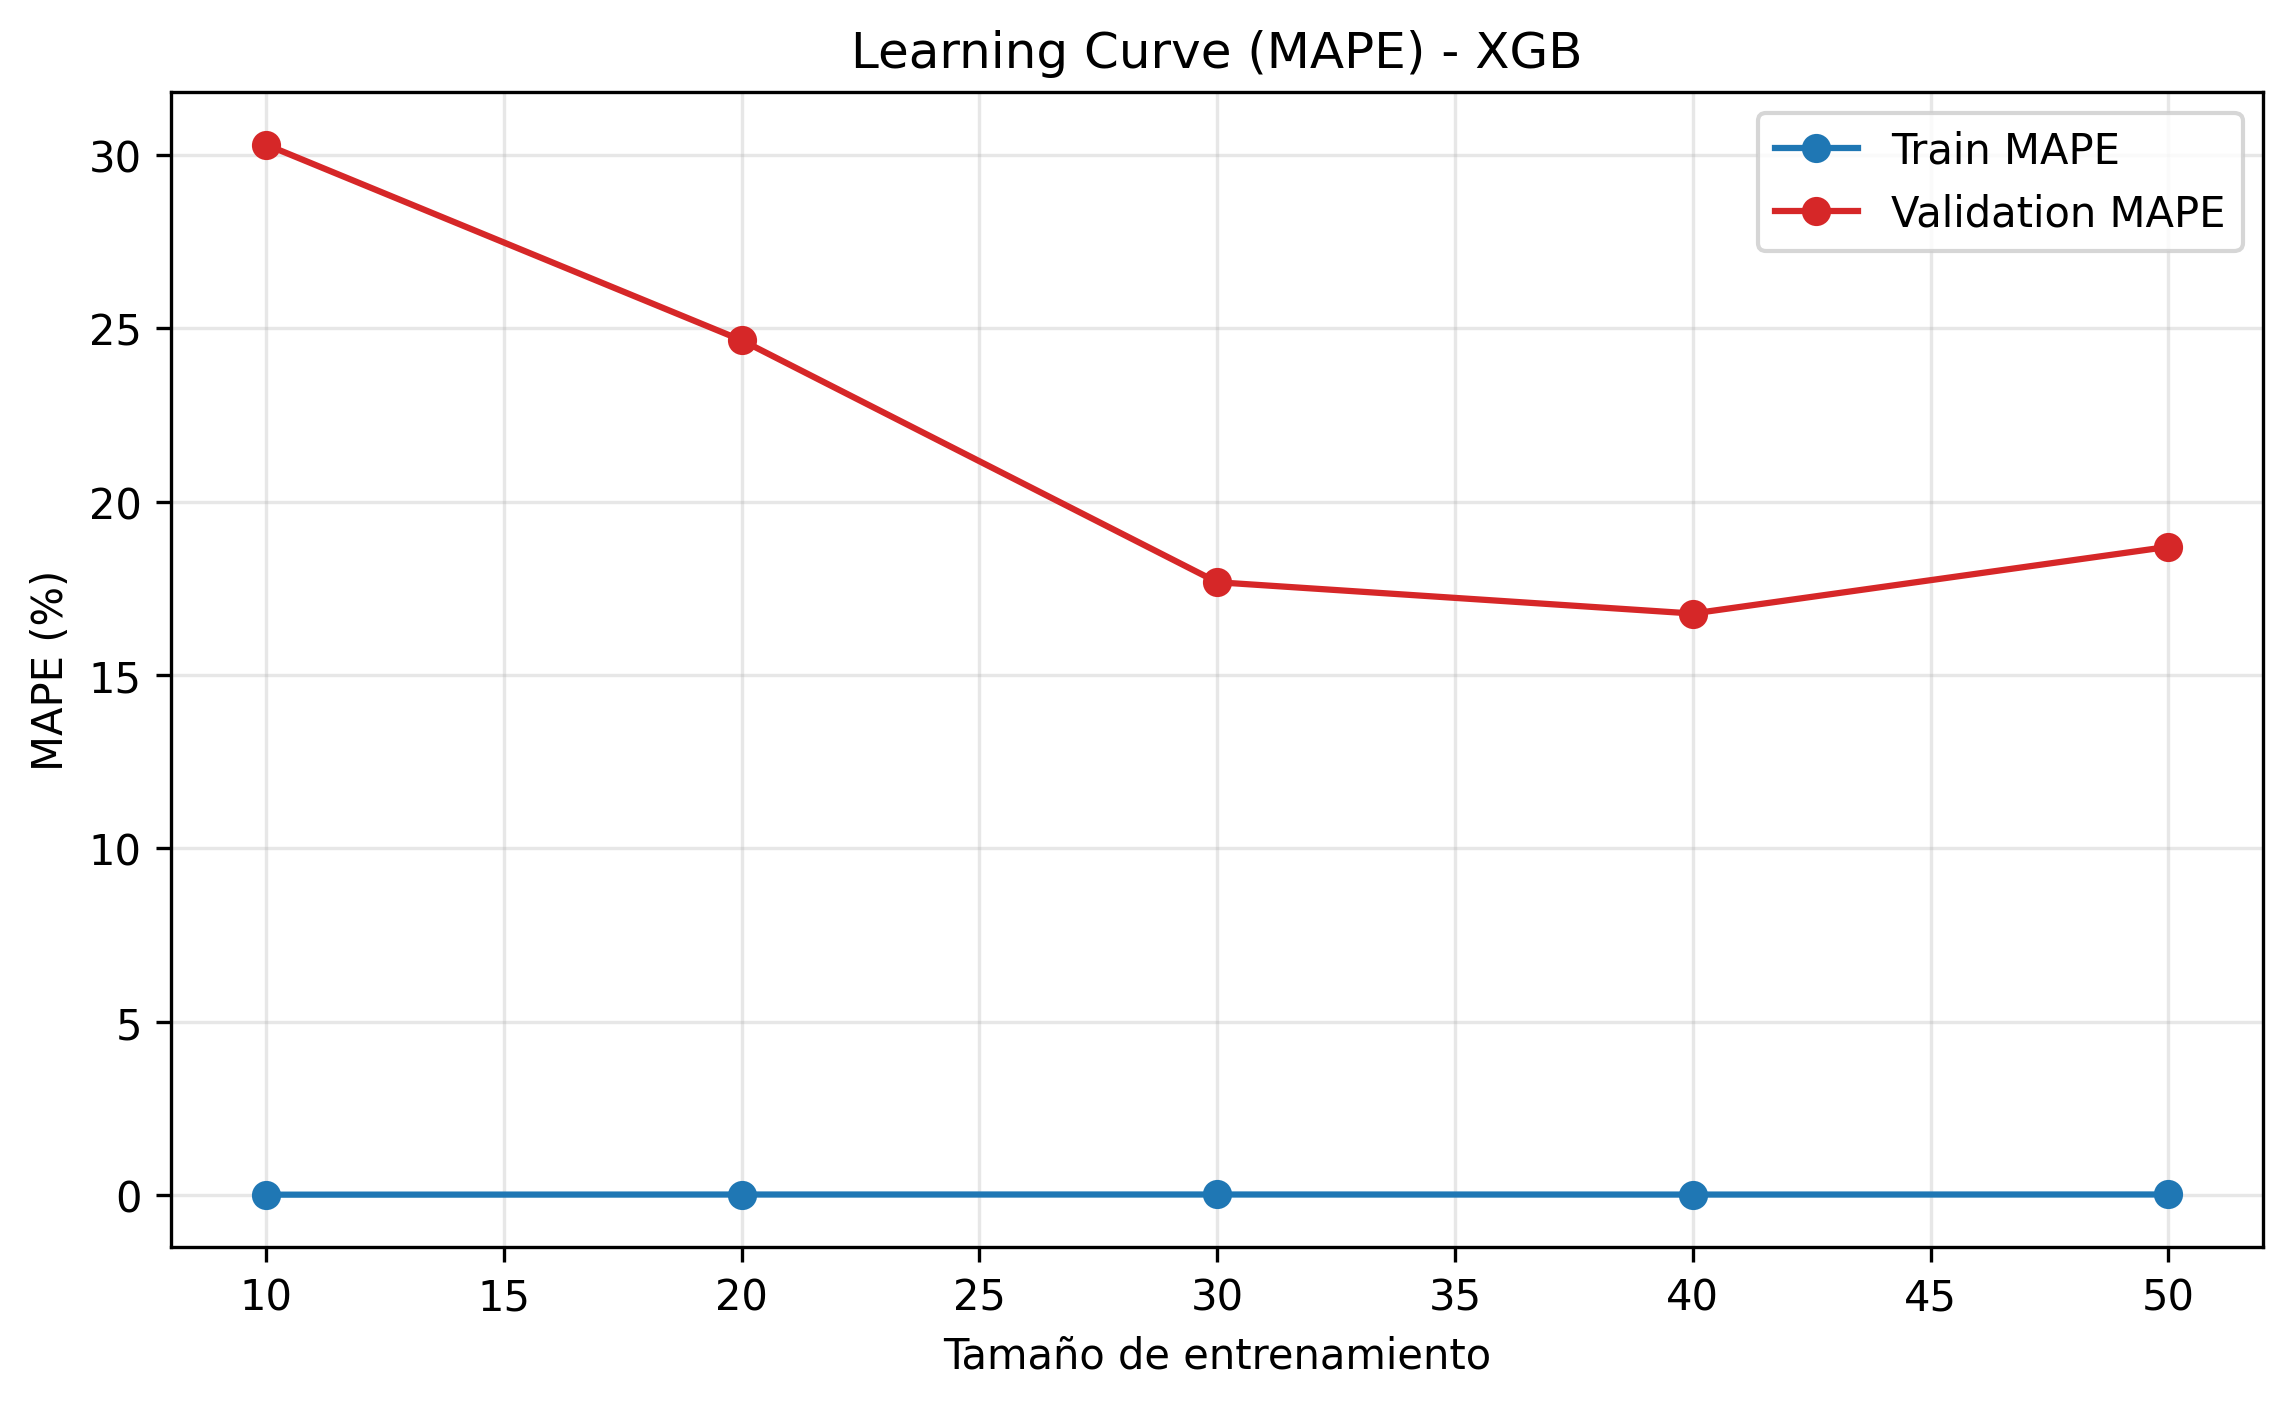

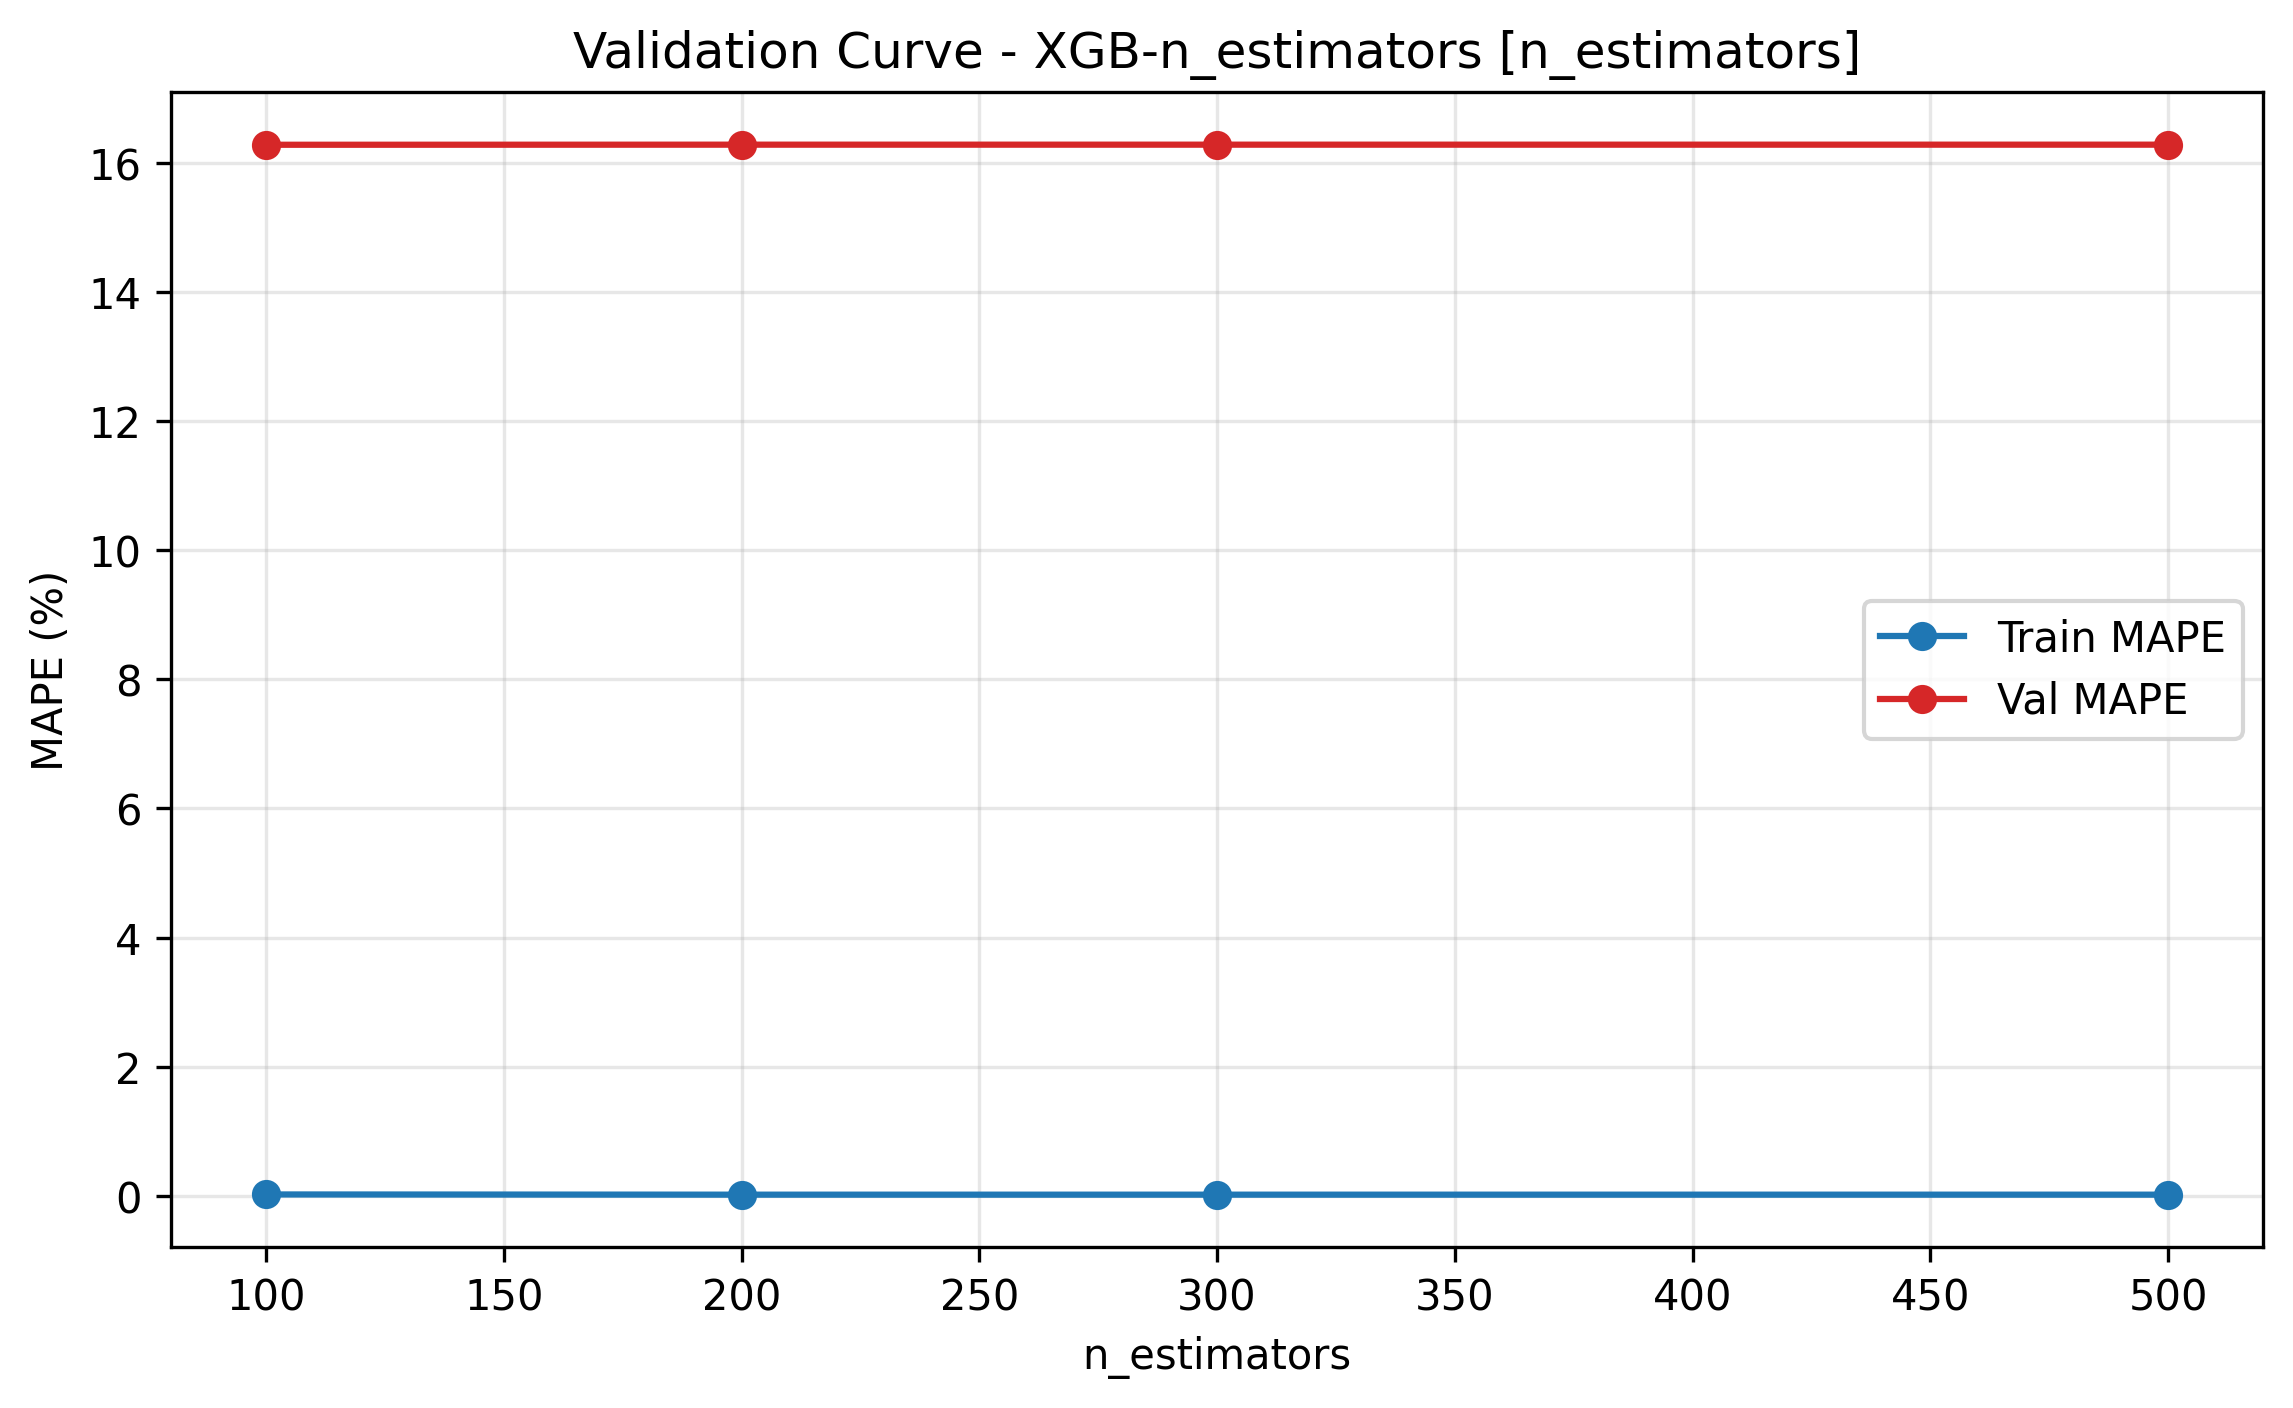

XGB best params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 2, 'subsample': 0.7}
XGB (TEST) -> RMSE: 1.407 | MAE: 1.147 | MAPE: 13.74%


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:22:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:22:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [06:22:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


In [ ]:
if HAS_XGB:
    # Detectar GPU
    use_gpu = False
    try:
        use_gpu = len(tf.config.list_physical_devices('GPU')) > 0
    except Exception:
        use_gpu = False

    xgb = XGBRegressor(
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        tree_method='gpu_hist' if use_gpu else 'hist',
        predictor='gpu_predictor' if use_gpu else 'auto',
        n_estimators=300
    )
    xgb_grid = {
        'max_depth': [2,3,4],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.7, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.9, 1.0]
    }
    plot_learning_curve_mape(xgb, X_train, y_train, tscv, "XGB")
    plot_validation_curve_mape(
        XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE,
                     tree_method='gpu_hist' if use_gpu else 'hist'),
        X_train, y_train, "n_estimators", [100, 200, 300, 500], tscv, "XGB-n_estimators", log_scale=False
    )
    xgb_gs = GridSearchCV(xgb, xgb_grid, cv=tscv, scoring=mape_scorer, n_jobs=-1)
    xgb_gs.fit(X_train, y_train)
    print("XGB best params:", xgb_gs.best_params_)
    y_pred_xgb = xgb_gs.predict(X_test)
    xgb_metrics = report(y_test, y_pred_xgb, "XGB (TEST)")
else:
    xgb_metrics = (np.nan, np.nan, np.nan)

GRIDSEARCH manual - LSTM (con callbacks)

In [ ]:
def make_lstm(n_units=64, dropout=0.2, lr=1e-3, input_steps=None):
    model = Sequential([
        Input(shape=(input_steps, 1)),
        LSTM(n_units, return_sequences=False),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model

# Reinterpretamos X como secuencias (timesteps=N_LAGS, features=1)
def to_seq(X): return X.reshape((X.shape[0], X.shape[1], 1))
X_tr_l, X_val_l, X_te_l = to_seq(X_train), to_seq(X_val), to_seq(X_test)

lstm_param_grid = {
    'n_units':  [32, 64],
    'dropout':  [0.1, 0.2],
    'lr':       [1e-3, 5e-4],
    'batch':    [16, 32],
    'epochs':   [60]  # early stopping corta antes si hace falta
}

best_lstm = None
best_val = np.inf
best_cfg = None

for n_units in lstm_param_grid['n_units']:
    for dr in lstm_param_grid['dropout']:
        for lr in lstm_param_grid['lr']:
            for batch in lstm_param_grid['batch']:
                model = make_lstm(n_units=n_units, dropout=dr, lr=lr, input_steps=X_tr_l.shape[1])
                cbs = [
                    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
                    ReduceLROnPlateau(factor=0.5, patience=7, verbose=0, monitor='val_loss')
                ]
                hist = model.fit(
                    X_tr_l, y_train,
                    validation_data=(X_val_l, y_val),
                    epochs=lstm_param_grid['epochs'][0],
                    batch_size=batch, verbose=0, callbacks=cbs
                )
                val_loss = min(hist.history['val_loss'])
                if val_loss < best_val:
                    best_val = val_loss
                    best_lstm = model
                    best_cfg = dict(n_units=n_units, dropout=dr, lr=lr, batch=batch)

print("LSTM best config:", best_cfg)
# Curva de entrenamiento del mejor LSTM (opcional: volver a entrenar para graficar)
# (aquí reutilizamos historia final de best_lstm no guardada; si quieres la curva,
# reentrena con las mejores cfg y guarda hist.history)

y_pred_lstm = best_lstm.predict(X_te_l).ravel()
lstm_metrics = report(y_test, y_pred_lstm, "LSTM (TEST)")


LSTM best config: {'n_units': 64, 'dropout': 0.1, 'lr': 0.001, 'batch': 16}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM (TEST) -> RMSE: 1.408 | MAE: 1.173 | MAPE: 14.20%


Resumen comparativo

In [ ]:
rows = [
    ("Ridge",) + ridge_metrics,
    ("MLP",)   + mlp_metrics,
    ("XGB",)   + xgb_metrics if HAS_XGB else ("XGB", np.nan, np.nan, np.nan),
    ("LSTM",)  + lstm_metrics
]
df_res = pd.DataFrame(rows, columns=["Modelo","RMSE","MAE","MAPE_%"]).sort_values("MAPE_%")
print("\n=== Resultados (ordenado por MAPE) ===")
print(df_res.to_string(index=False))



=== Resultados (ordenado por MAPE) ===
Modelo     RMSE      MAE    MAPE_%
 Ridge 1.245180 0.972794 11.252682
   MLP 1.438710 1.149878 13.278036
   XGB 1.407358 1.147296 13.738319
  LSTM 1.408152 1.173002 14.204896


# **Estrategia de mejora 2**

Cargar datos y utilidades

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from math import sqrt

# Modelos clásicos
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

# XGBoost (opcional con GPU)
HAS_XGB = True
try:
    from xgboost import XGBRegressor
except Exception:
    HAS_XGB = False
    print("⚠️ xgboost no disponible, se omitirá XGBRegressor.")

# LSTM (Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# (Opcional) Si estás en Colab y subirás el Excel manualmente:
# from google.colab import files
# uploaded = files.upload()  # sube 'precio_ecuador.xlsx'

# Carga de datos
df = pd.read_excel('precio_ecuador.xlsx')

Métricas y funciones auxiliares

In [ ]:
def MAPE(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    denom = np.maximum(np.abs(y_true), eps)        # evita división por cero
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

mape_scorer = make_scorer(MAPE, greater_is_better=False)

def report(y_true, y_pred, tag):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = MAPE(y_true, y_pred)
    print(f"{tag} -> RMSE: {rmse:.3f} | MAE: {mae:.3f} | MAPE: {mape:.2f}%")
    return rmse, mae, mape

def plot_learning_curve_mape(model, X, y, tscv, title):
    ts, tr_scores, va_scores = learning_curve(
        model, X, y, cv=tscv, scoring=mape_scorer,
        train_sizes=np.linspace(0.2, 1.0, 5), n_jobs=-1, shuffle=False
    )
    tr = -tr_scores.mean(axis=1); tr_std = tr_scores.std(axis=1)
    va = -va_scores.mean(axis=1); va_std = va_scores.std(axis=1)

    plt.figure(figsize=(9,5), dpi=300)
    plt.plot(ts, tr, 'o-', label='Train MAPE', color='C0')
    plt.plot(ts, va, 'o-', label='Validation MAPE', color='C3')
    plt.fill_between(ts, -tr_scores.mean(axis=1)-tr_std, -tr_scores.mean(axis=1)+tr_std, color='C0', alpha=0.1)
    plt.fill_between(ts, -va_scores.mean(axis=1)-va_std, -va_scores.mean(axis=1)+va_std, color='C3', alpha=0.1)
    plt.title(f"Learning Curve (MAPE) - {title}")
    plt.xlabel("Tamaño de entrenamiento"); plt.ylabel("MAPE (%)")
    plt.grid(alpha=0.3); plt.legend(); plt.show()

def plot_validation_curve_mape(model, X, y, param_name, param_range, tscv, title, log_scale=True):
    tr_scores, va_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range,
        cv=tscv, scoring=mape_scorer, n_jobs=-1
    )
    tr = -tr_scores.mean(axis=1)
    va = -va_scores.mean(axis=1)

    plt.figure(figsize=(9,5), dpi=300)
    plt.plot(param_range, tr, 'o-', label='Train MAPE', color='C0')
    plt.plot(param_range, va, 'o-', label='Val MAPE', color='C3')
    if log_scale: plt.xscale('log')
    plt.title(f"Validation Curve - {title} [{param_name}]")
    plt.xlabel(param_name); plt.ylabel("MAPE (%)")
    plt.grid(alpha=0.3); plt.legend(); plt.show()

Preparación de datos (Fecha, lags parametrizables, split 70/15/15)

In [ ]:
assert {'Año','Semana','Precio'}.issubset(df.columns), "Faltan columnas requeridas"

# Fecha (lunes de cada semana), ordenar
df['Fecha'] = pd.to_datetime(df['Año'].astype(str) + df['Semana'].astype(str) + '1', format='%G%V%u')
df = df.sort_values('Fecha').reset_index(drop=True)

# Parametriza N_LAGS aquí
N_LAGS = 5  # ← cambia a 3, 7, etc. si quieres experimentar
for i in range(1, N_LAGS+1):
    df[f'Precio_t-{i}'] = df['Precio'].shift(i)
df = df.dropna().reset_index(drop=True)

features = [c for c in df.columns if c.startswith('Precio_t-')]
target   = 'Precio'

# Escalar SOLO X (no y para no distorsionar MAPE)
scaler_X = MinMaxScaler()
X_all = scaler_X.fit_transform(df[features])
y_all = df[target].values.astype(float)

# Split temporal 70/15/15
n = len(df)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)
X_train, X_val, X_test = X_all[:train_end], X_all[train_end:val_end], X_all[val_end:]
y_train, y_val, y_test = y_all[:train_end], y_all[train_end:val_end], y_all[val_end:]

print(f"Splits -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
tscv = TimeSeriesSplit(n_splits=5)

Splits -> Train: (305, 5), Val: (66, 5), Test: (66, 5)


GRIDSEARCH - RIDGE (regularización L2)

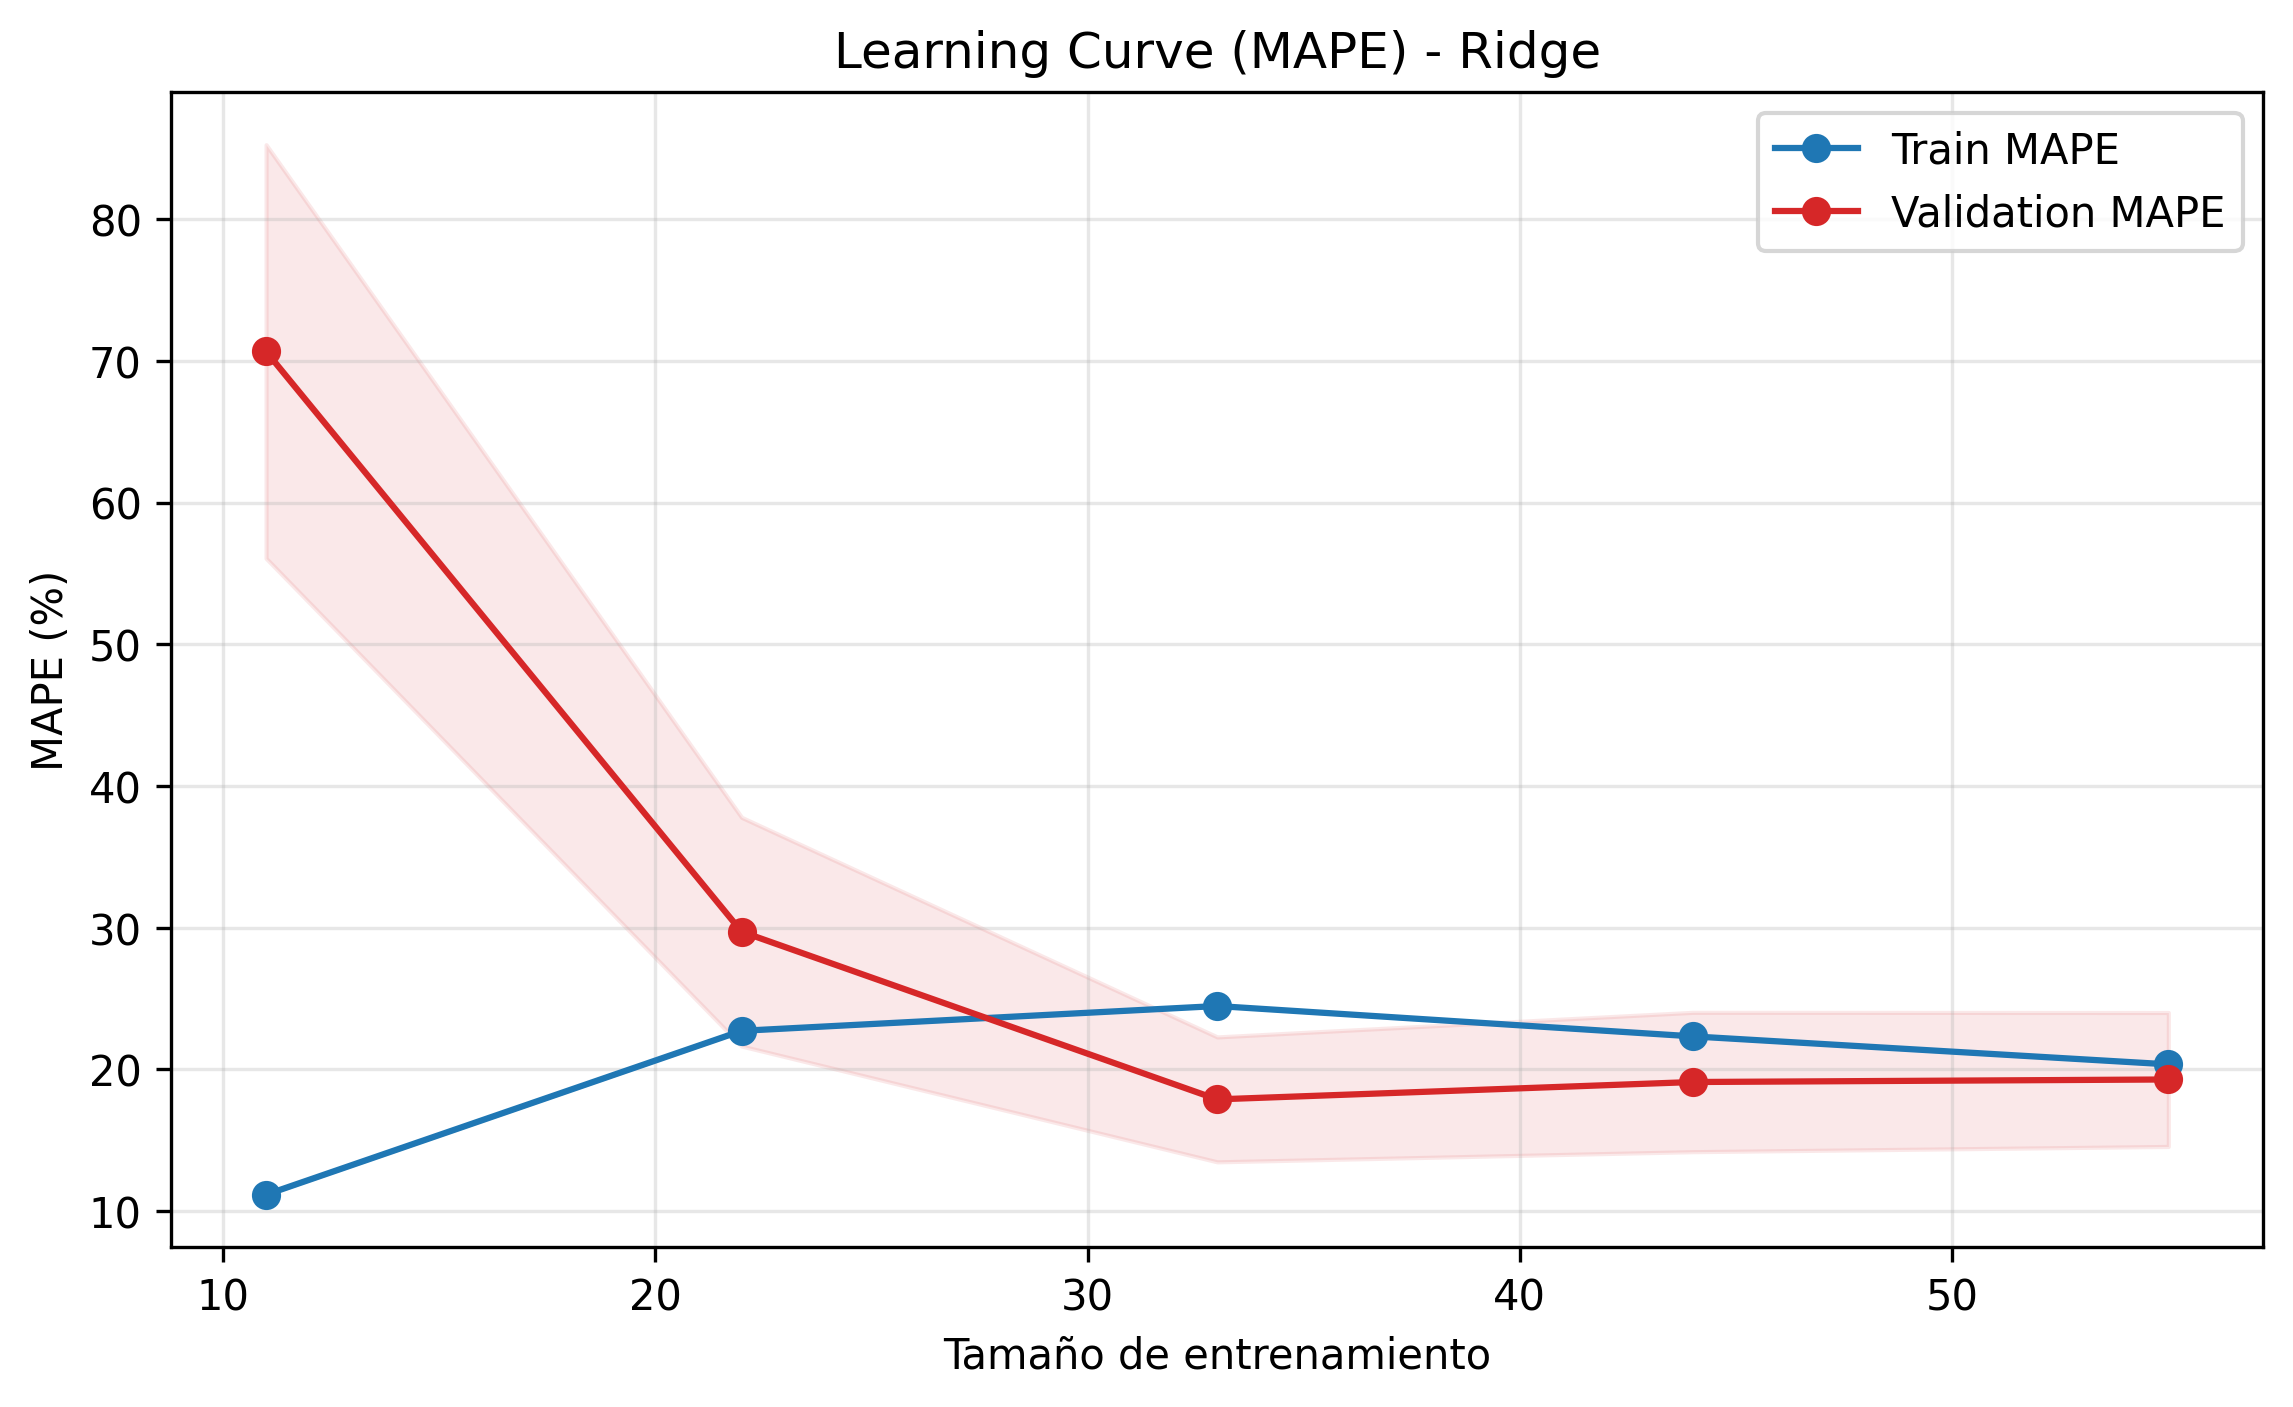

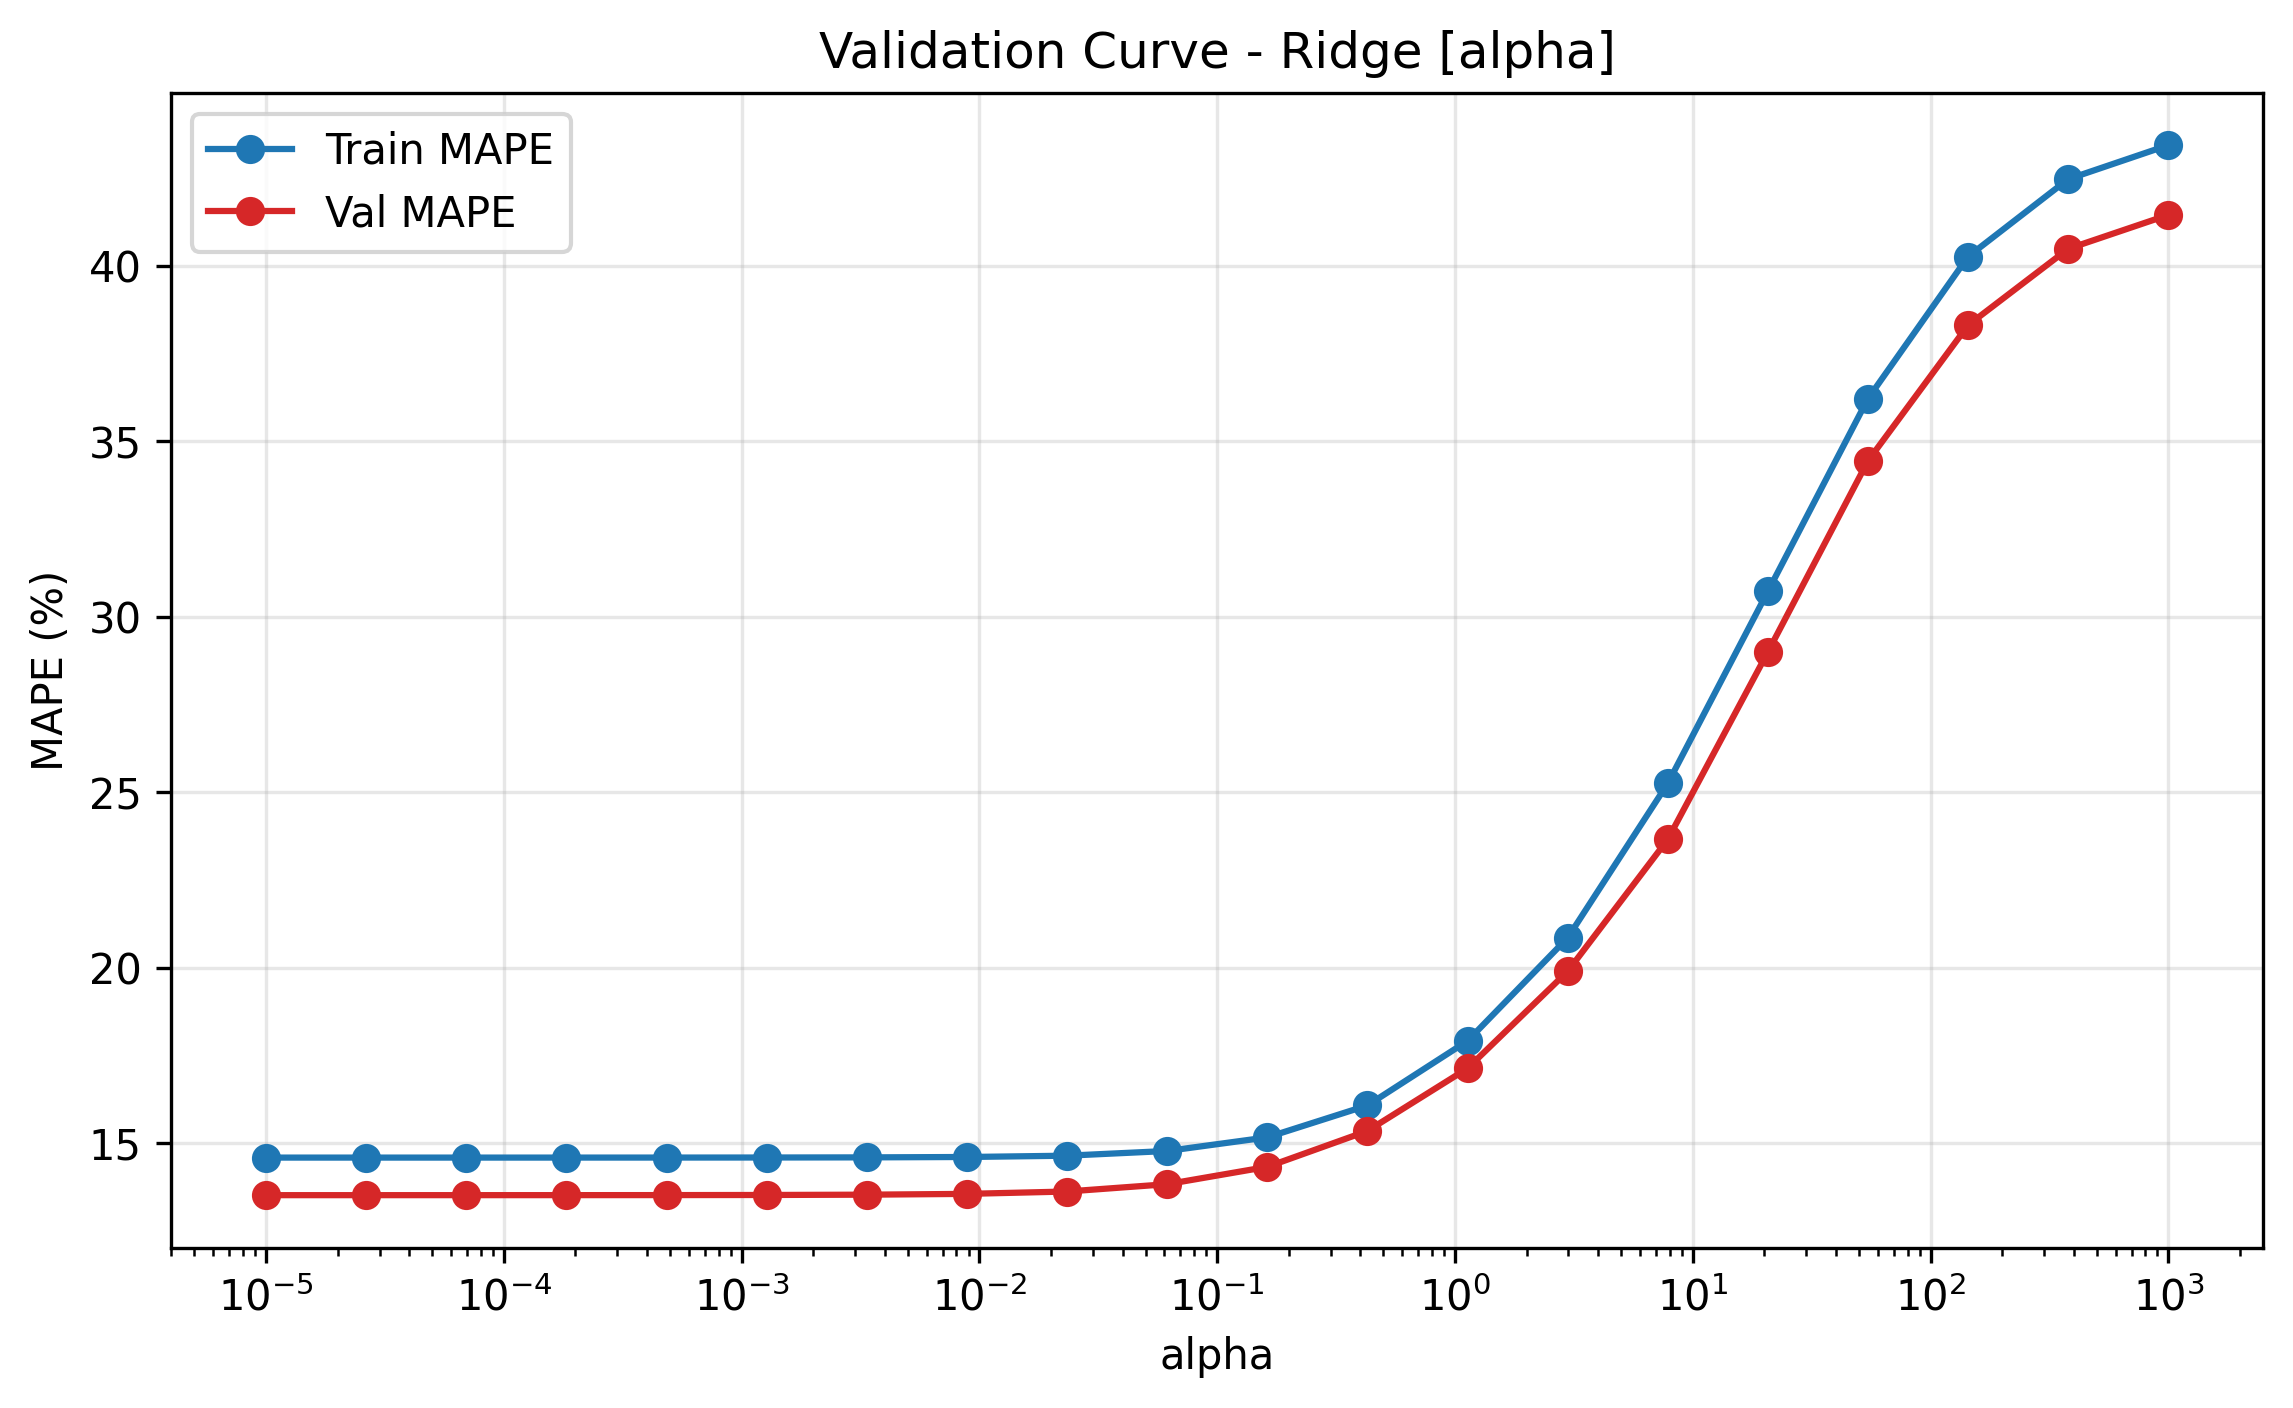

Ridge best params: {'alpha': np.float64(9.999999999999999e-06)}
Ridge (TEST) -> RMSE: 1.225 | MAE: 0.959 | MAPE: 11.15%


In [ ]:
ridge = Ridge(random_state=RANDOM_STATE)
ridge_grid = {'alpha': np.logspace(-5, 3, 20)}
plot_learning_curve_mape(ridge, X_train, y_train, tscv, "Ridge")
plot_validation_curve_mape(Ridge(), X_train, y_train, "alpha", ridge_grid['alpha'], tscv, "Ridge", log_scale=True)

ridge_gs = GridSearchCV(ridge, ridge_grid, cv=tscv, scoring=mape_scorer, n_jobs=-1)
ridge_gs.fit(X_train, y_train)
print("Ridge best params:", ridge_gs.best_params_)
y_pred_ridge = ridge_gs.predict(X_test)
ridge_metrics = report(y_test, y_pred_ridge, "Ridge (TEST)")

GRIDSEARCH – MLP (regularización, LR, arquitectura)

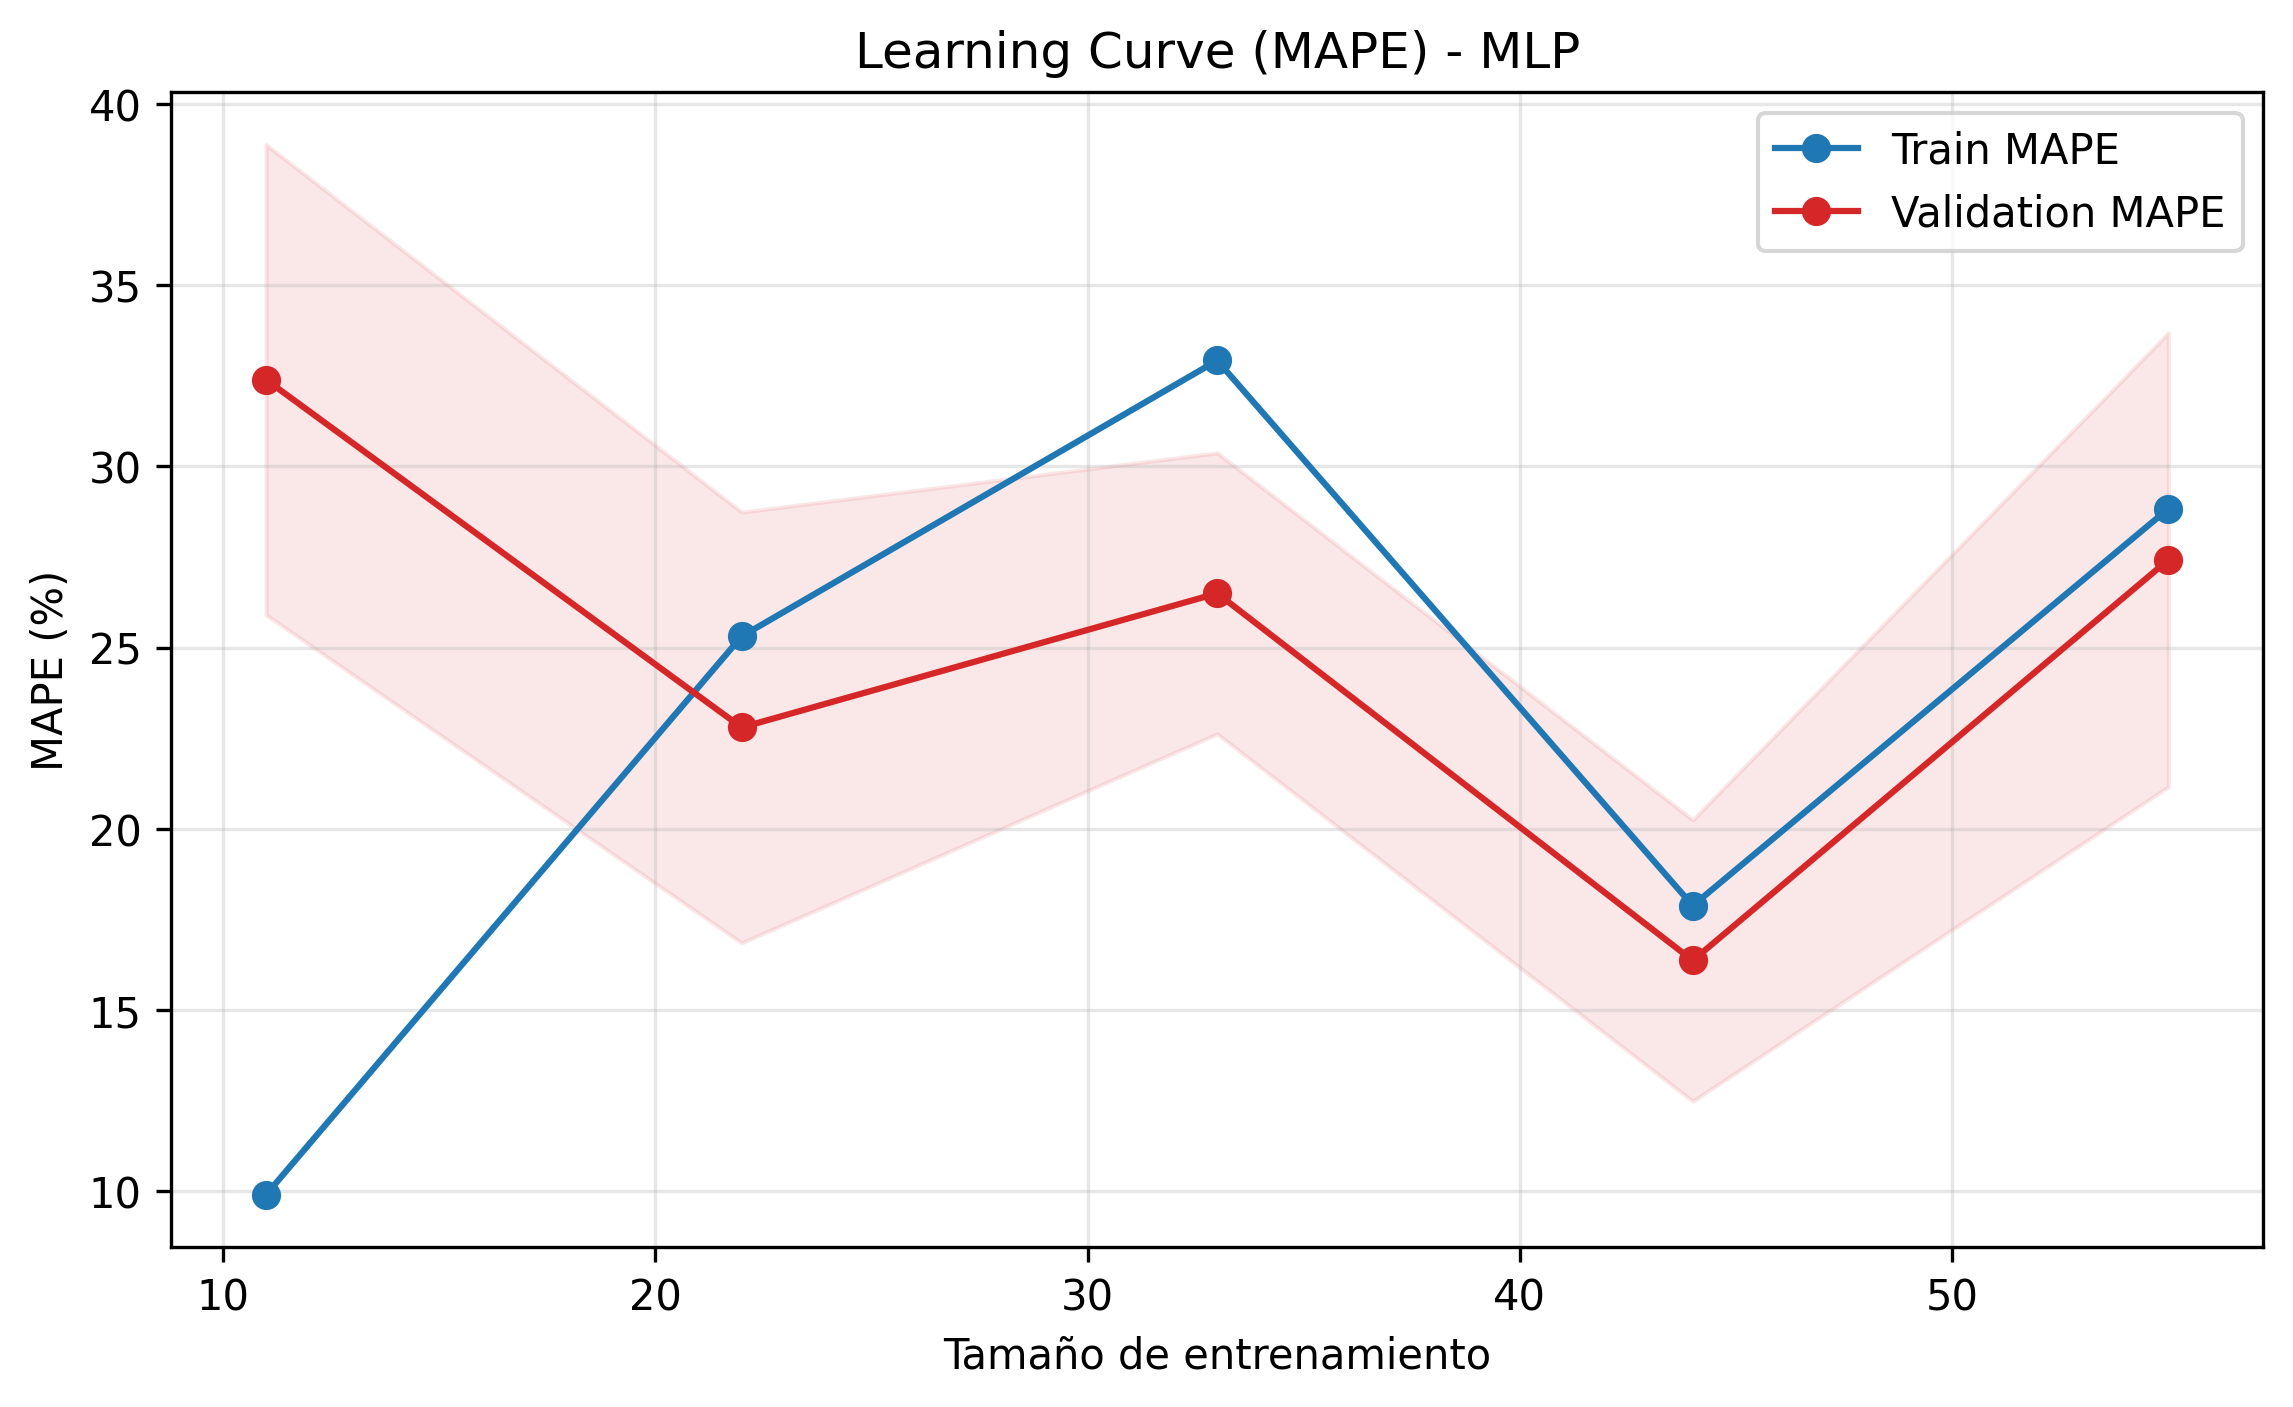

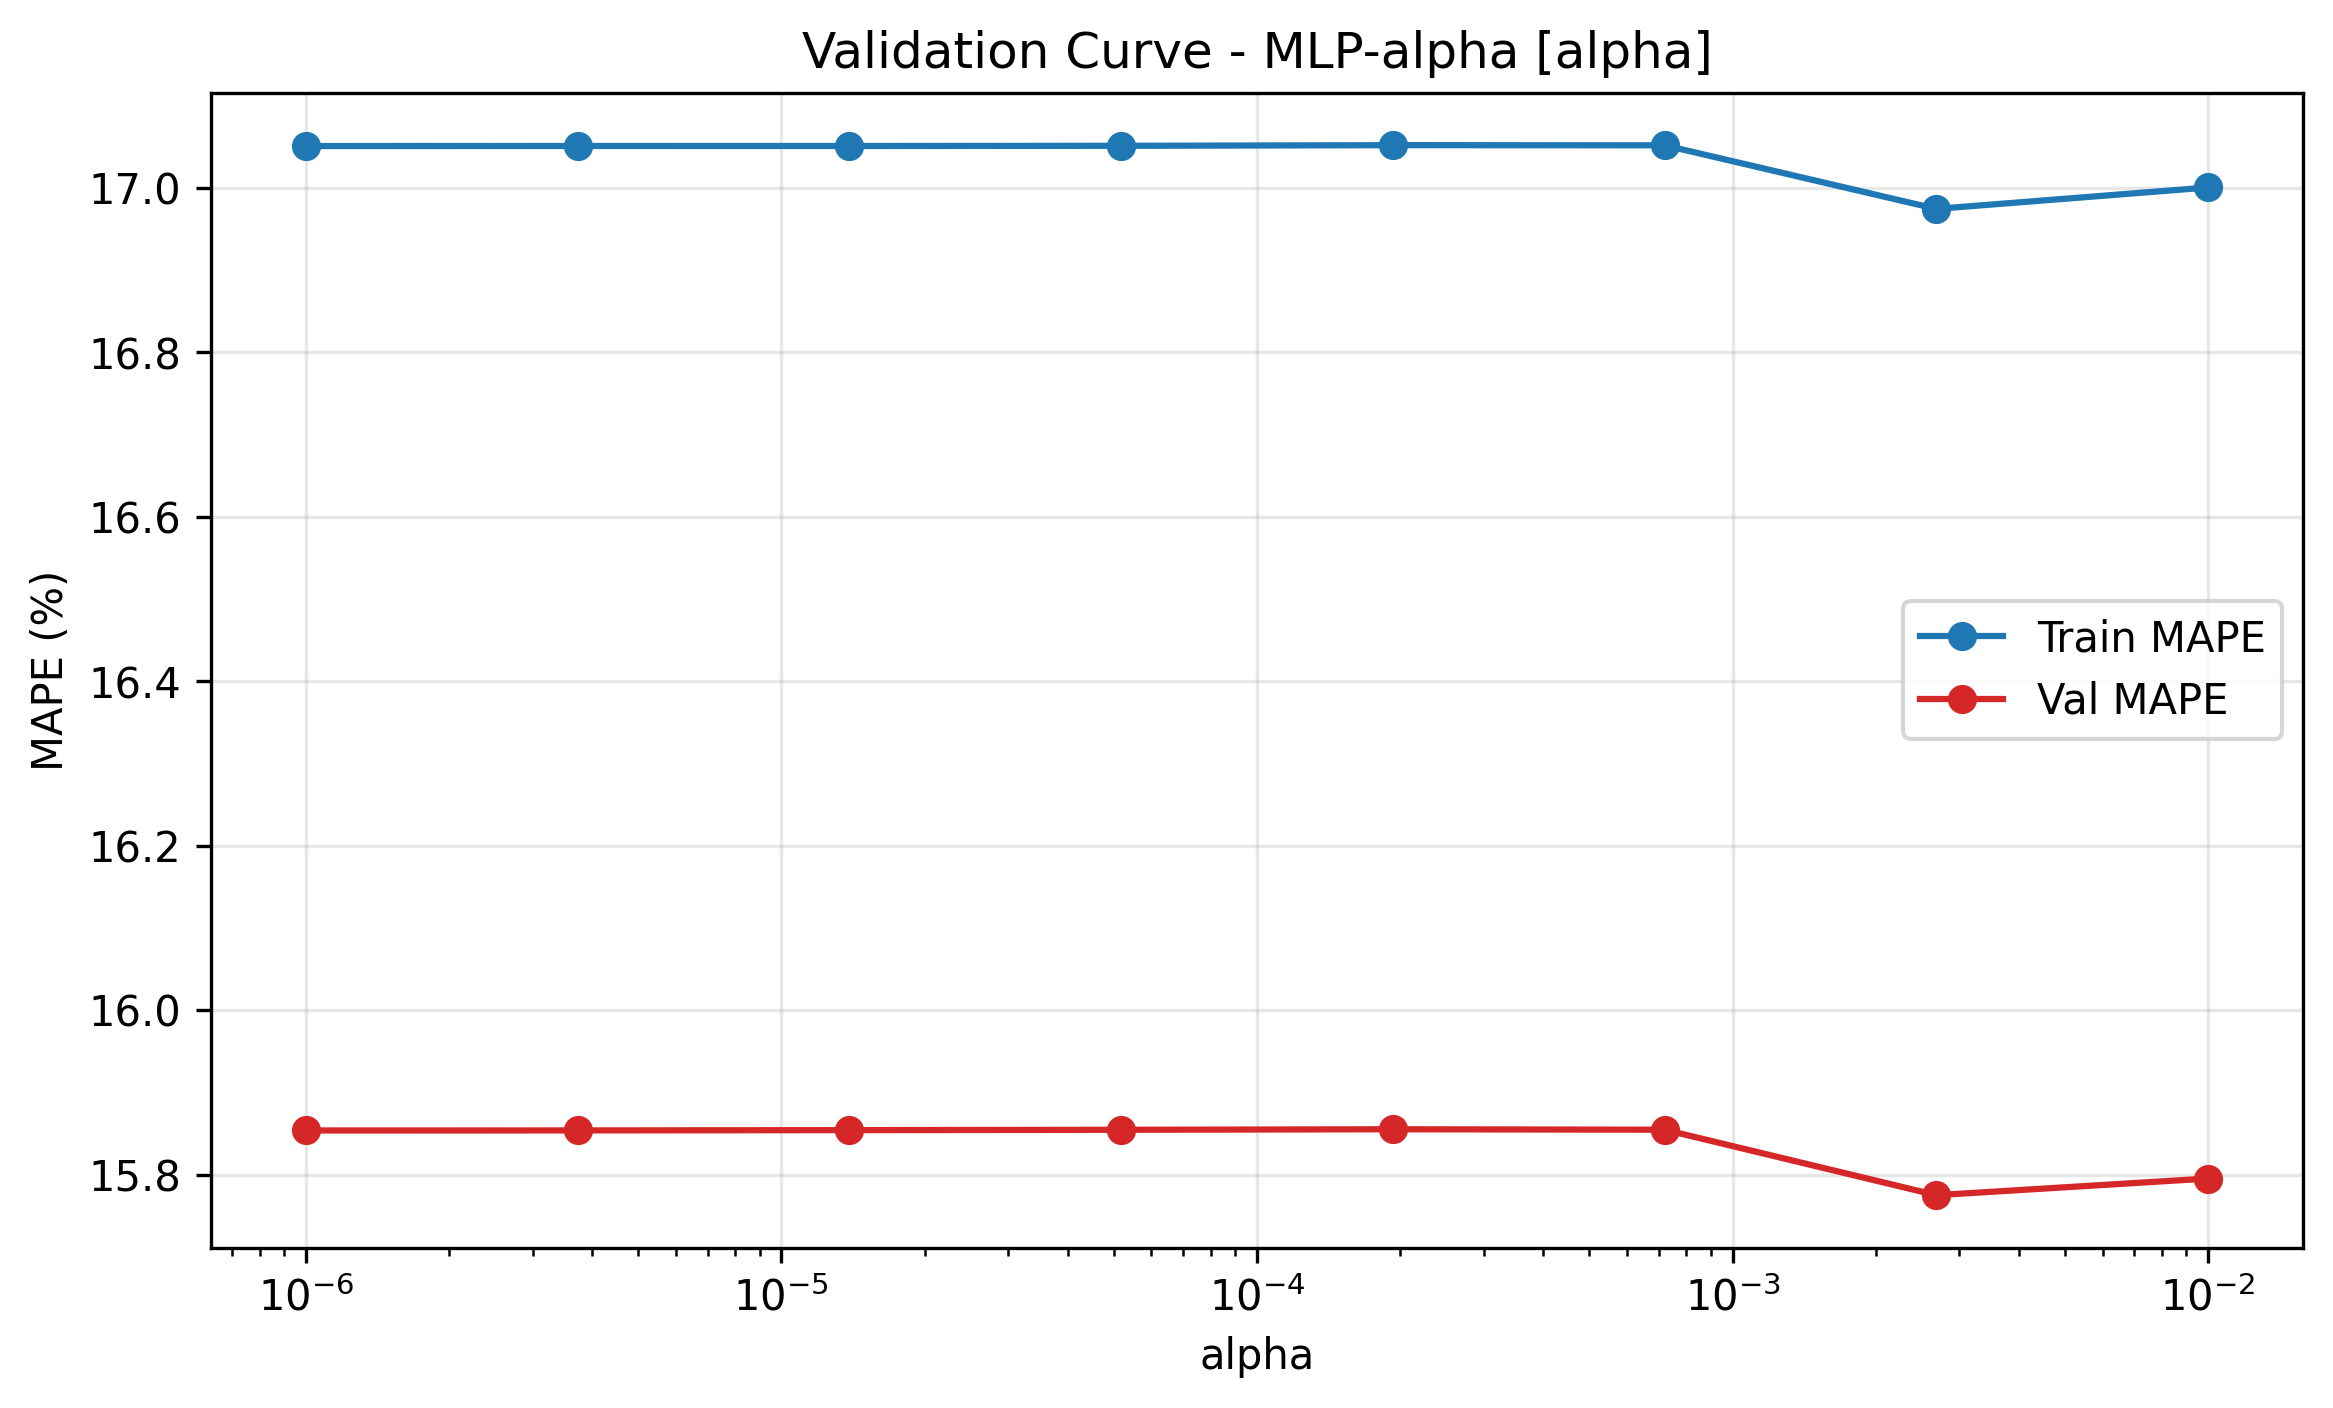

MLP best params: {'activation': 'tanh', 'alpha': np.float64(1e-06), 'hidden_layer_sizes': (64, 64), 'learning_rate_init': 0.003}
MLP (TEST) -> RMSE: 1.241 | MAE: 1.013 | MAPE: 12.03%


In [ ]:
mlp = MLPRegressor(
    random_state=RANDOM_STATE, max_iter=3000,
    early_stopping=True, validation_fraction=0.15, n_iter_no_change=30
)
mlp_grid = {
    'hidden_layer_sizes': [(32,32), (64,32), (64,64), (128,64)],
    'alpha': np.logspace(-6, -2, 8),
    'learning_rate_init': [1e-4, 3e-4, 1e-3, 3e-3],
    'activation': ['relu','tanh']
}
plot_learning_curve_mape(mlp, X_train, y_train, tscv, "MLP")
plot_validation_curve_mape(MLPRegressor(max_iter=1000, random_state=RANDOM_STATE),
                           X_train, y_train, "alpha", mlp_grid['alpha'], tscv, "MLP-alpha", log_scale=True)

mlp_gs = GridSearchCV(mlp, mlp_grid, cv=tscv, scoring=mape_scorer, n_jobs=-1)
mlp_gs.fit(X_train, y_train)
print("MLP best params:", mlp_gs.best_params_)
y_pred_mlp = mlp_gs.predict(X_test)
mlp_metrics = report(y_test, y_pred_mlp, "MLP (TEST)")

GRIDSEARCH - XGBoost (regularizaciones + estructura)

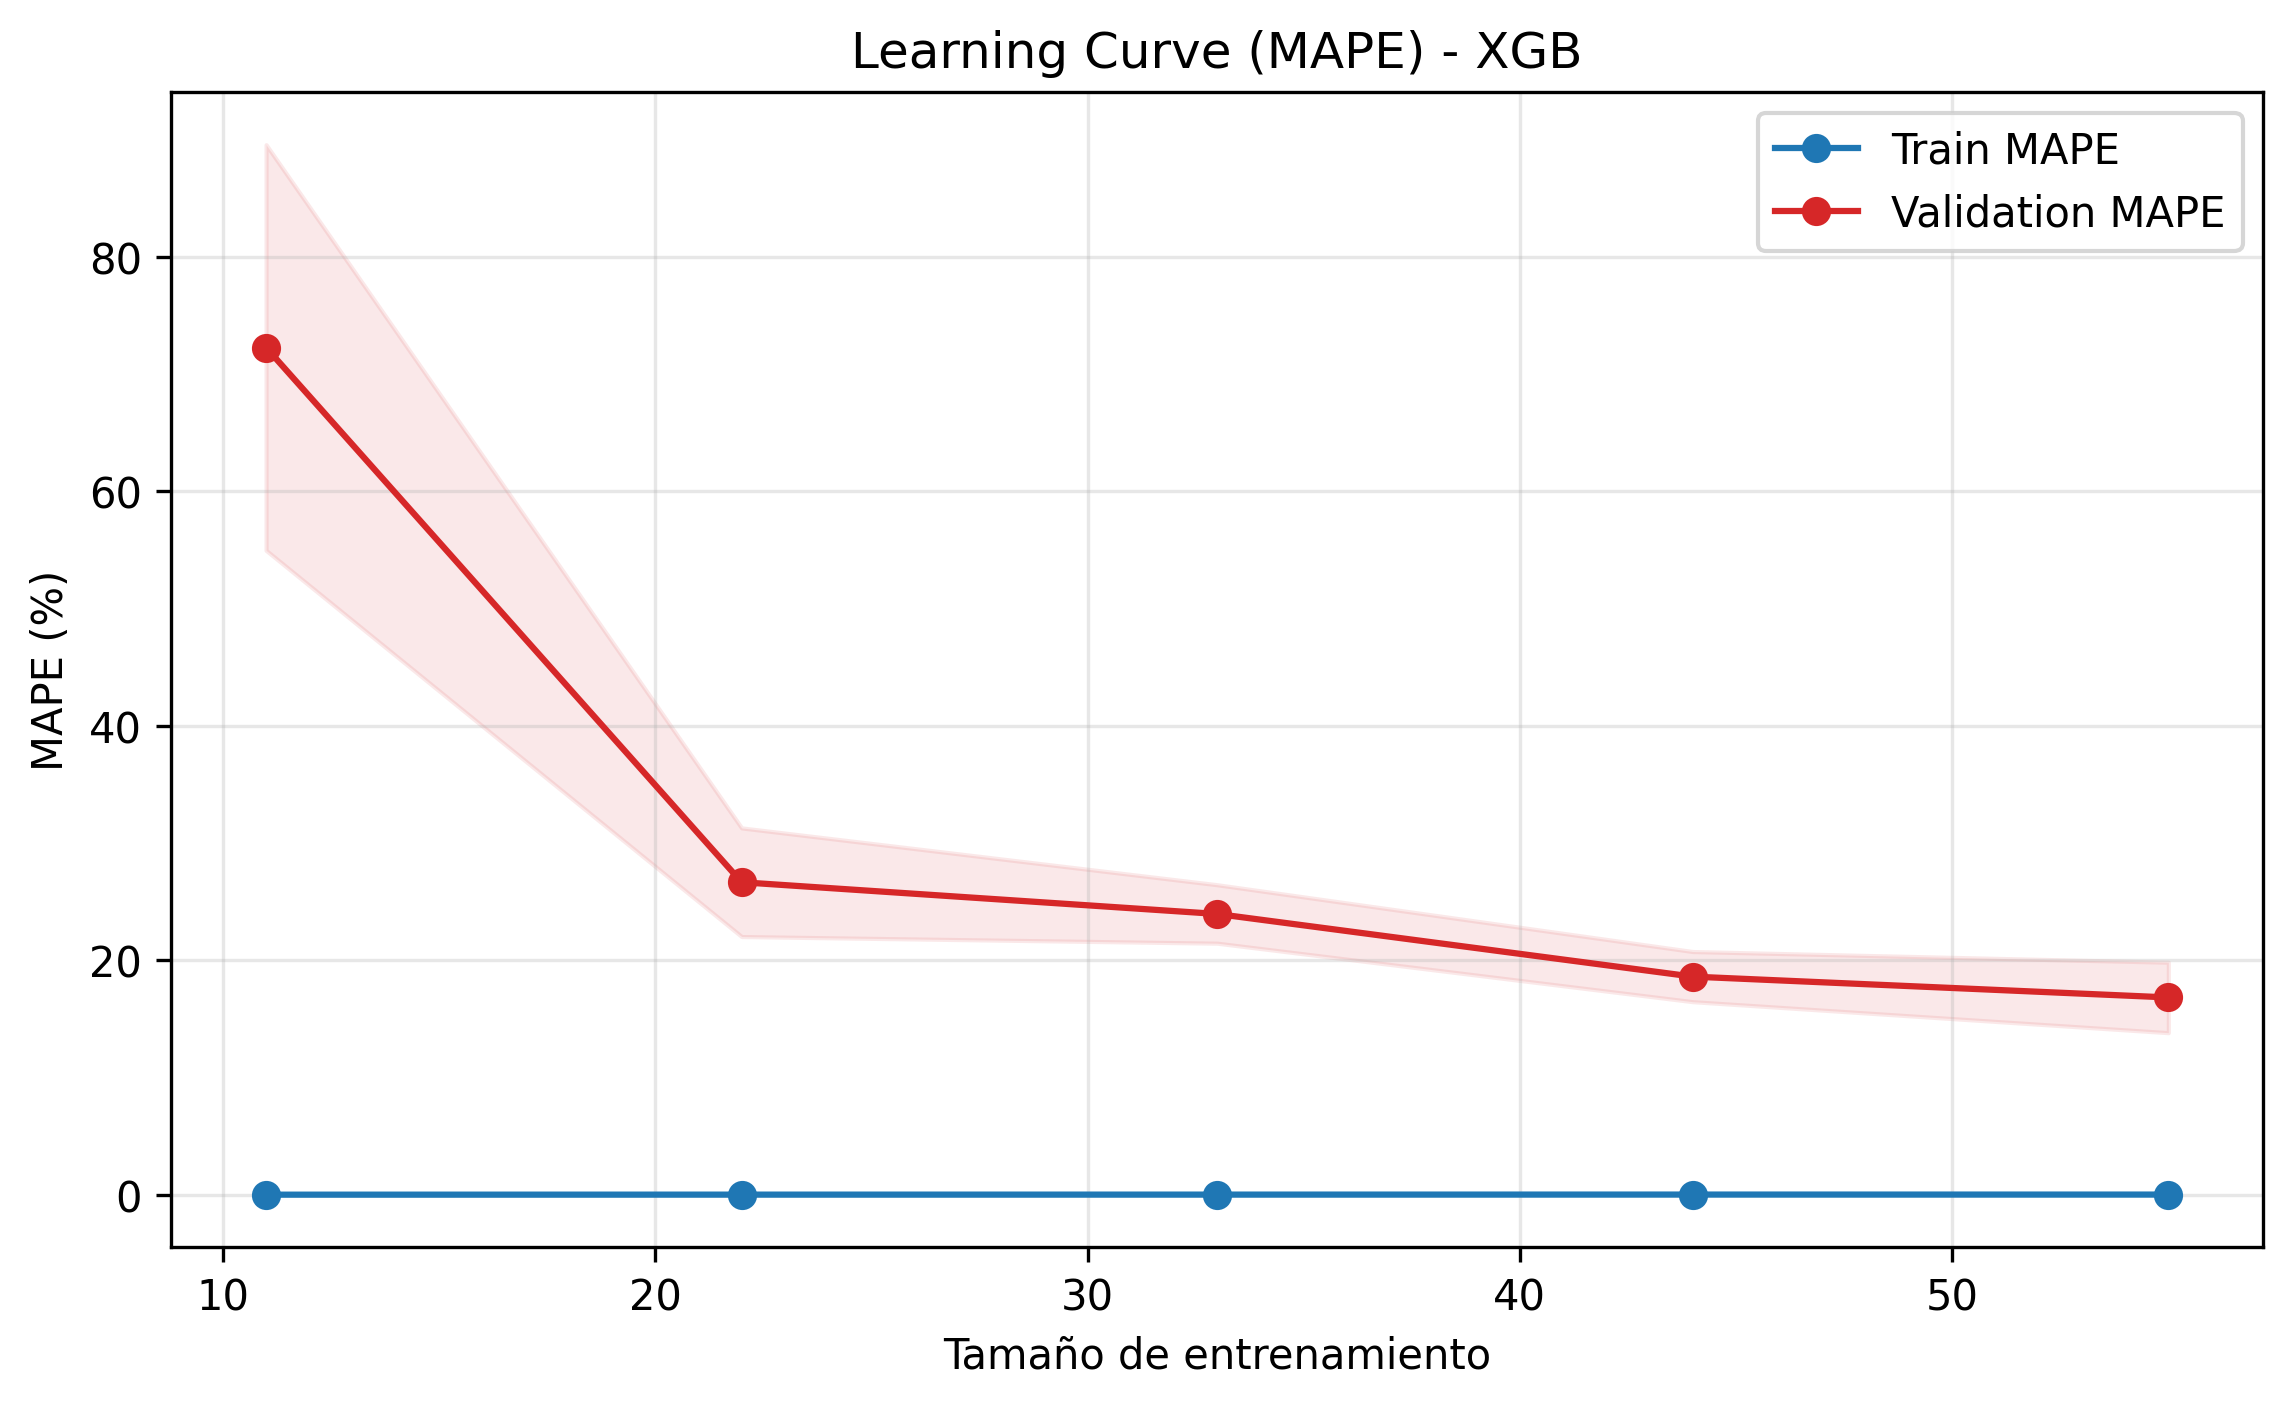

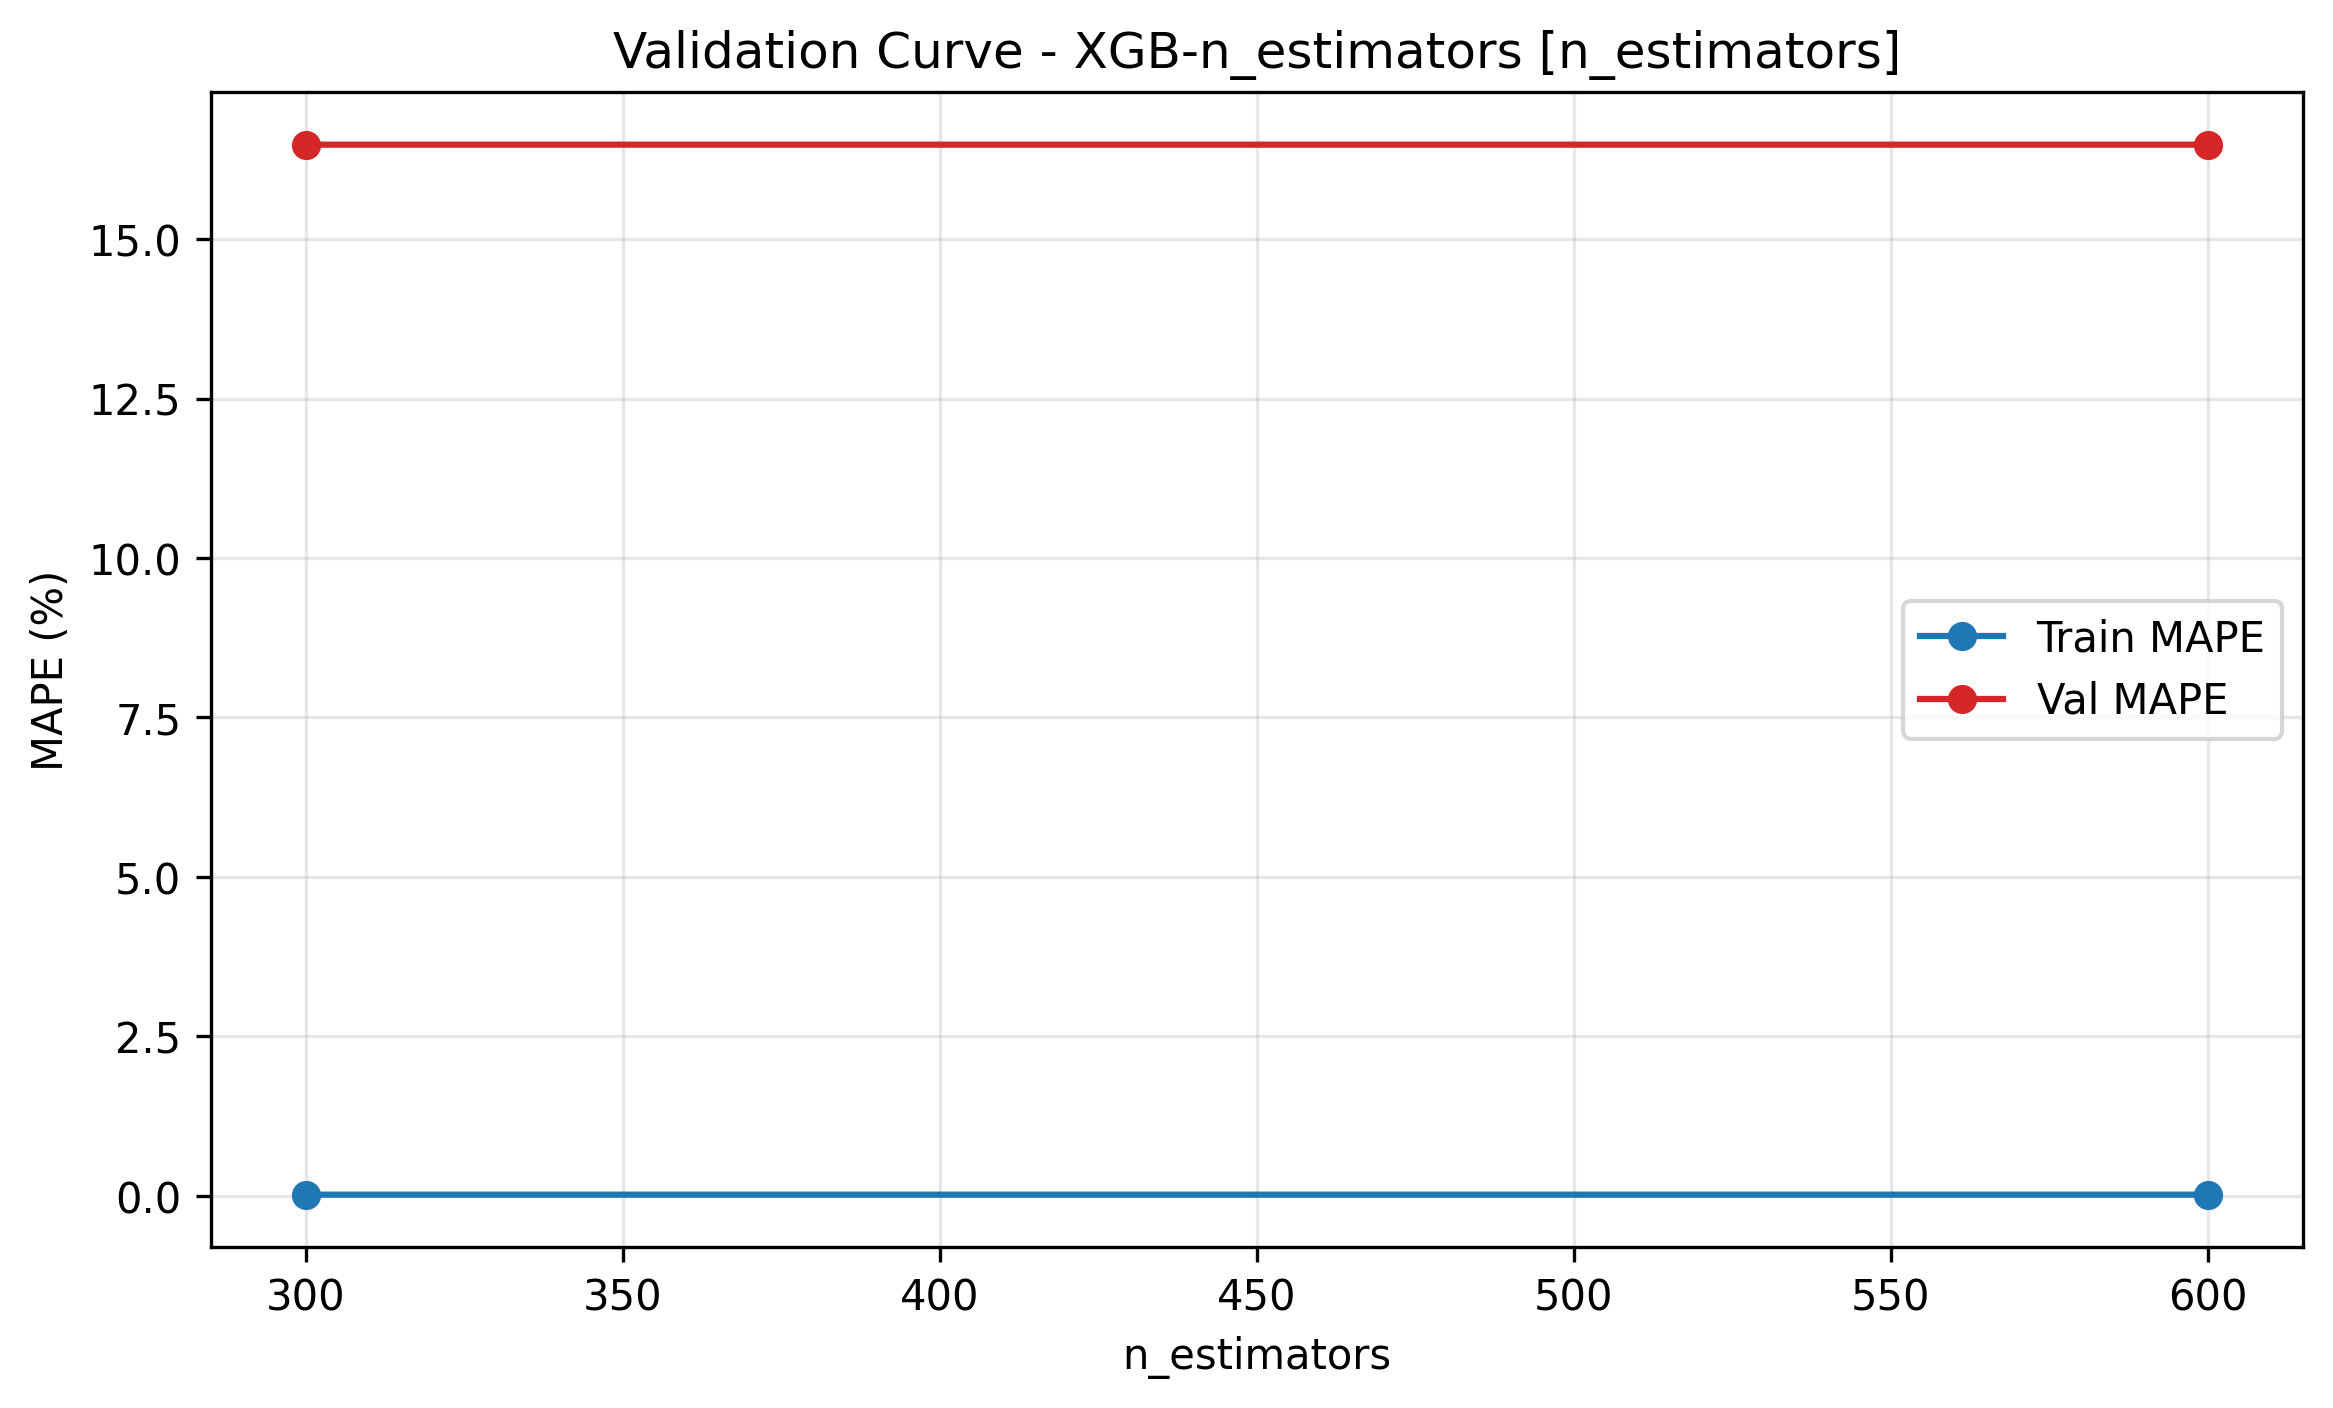

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:09:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:09:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB best params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.001, 'reg_lambda': 5, 'subsample': 1.0}
XGB (TEST) -> RMSE: 1.409 | MAE: 1.163 | MAPE: 14.06%


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [07:09:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


In [ ]:
if HAS_XGB:
    use_gpu = False
    try:
        use_gpu = len(tf.config.list_physical_devices('GPU')) > 0
    except Exception:
        use_gpu = False

    xgb = XGBRegressor(
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        tree_method='gpu_hist' if use_gpu else 'hist',
        predictor='gpu_predictor' if use_gpu else 'auto'
    )

    # Grid exhaustivo pero acotado (2^8 = 256 combinaciones)
    xgb_grid = {
        'n_estimators':     [300, 600],
        'max_depth':        [3, 4],
        'learning_rate':    [0.03, 0.06],
        'subsample':        [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_lambda':       [1, 5],
        'reg_alpha':        [0, 1e-3],
        'gamma':            [0, 0.1],
    }

    plot_learning_curve_mape(
        XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE,
                     tree_method='gpu_hist' if use_gpu else 'hist'),
        X_train, y_train, tscv, "XGB"
    )
    plot_validation_curve_mape(
        XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE,
                     tree_method='gpu_hist' if use_gpu else 'hist'),
        X_train, y_train, "n_estimators", xgb_grid['n_estimators'], tscv, "XGB-n_estimators", log_scale=False
    )

    xgb_gs = GridSearchCV(xgb, xgb_grid, cv=tscv, scoring=mape_scorer, n_jobs=-1)
    xgb_gs.fit(X_train, y_train)
    print("XGB best params:", xgb_gs.best_params_)
    y_pred_xgb = xgb_gs.predict(X_test)
    xgb_metrics = report(y_test, y_pred_xgb, "XGB (TEST)")
else:
    xgb_metrics = (np.nan, np.nan, np.nan)

GRIDSEARCH “manual” – LSTM (unidad, dropout, LR, batch)

In [ ]:
def make_lstm(n_units=64, dropout=0.2, lr=1e-3, input_steps=None):
    model = Sequential([
        Input(shape=(input_steps, 1)),
        LSTM(n_units, return_sequences=False),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model

# Reinterpretamos X como secuencias (timesteps=N_LAGS, features=1)
def to_seq(X): return X.reshape((X.shape[0], X.shape[1], 1))
X_tr_l, X_val_l, X_te_l = to_seq(X_train), to_seq(X_val), to_seq(X_test)

lstm_param_grid = {
    'n_units':  [32, 64, 96],
    'dropout':  [0.1, 0.2, 0.3],
    'lr':       [1e-3, 5e-4],
    'batch':    [16, 32],
    'epochs':   [120]  # EarlyStopping cortará antes si hace falta
}

best_lstm = None
best_val = np.inf
best_cfg = None

for n_units in lstm_param_grid['n_units']:
    for dr in lstm_param_grid['dropout']:
        for lr in lstm_param_grid['lr']:
            for batch in lstm_param_grid['batch']:
                model = make_lstm(n_units=n_units, dropout=dr, lr=lr, input_steps=X_tr_l.shape[1])
                cbs = [
                    EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss'),
                    ReduceLROnPlateau(factor=0.5, patience=8, verbose=0, monitor='val_loss')
                ]
                hist = model.fit(
                    X_tr_l, y_train,
                    validation_data=(X_val_l, y_val),
                    epochs=lstm_param_grid['epochs'][0],
                    batch_size=batch, verbose=0, callbacks=cbs
                )
                val_loss = min(hist.history['val_loss'])
                if val_loss < best_val:
                    best_val = val_loss
                    best_lstm = model
                    best_cfg = dict(n_units=n_units, dropout=dr, lr=lr, batch=batch)

print("LSTM best config:", best_cfg)
# Predicción en test con el mejor LSTM
y_pred_lstm = best_lstm.predict(X_te_l, verbose=0).ravel()
lstm_metrics = report(y_test, y_pred_lstm, "LSTM (TEST)")

# (Opcional) vuelve a entrenar con best_cfg para graficar su curva si quieres verla:
# hist_best = best_lstm.fit(X_tr_l, y_train, validation_data=(X_val_l, y_val),
#                           epochs=80, batch_size=best_cfg['batch'], verbose=0,
#                           callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
# plt.figure(figsize=(8,4), dpi=300)
# plt.plot(hist_best.history['loss'], label='Train Loss'); plt.plot(hist_best.history['val_loss'], label='Val Loss')
# plt.title("Curva de entrenamiento - Mejor LSTM"); plt.xlabel("Época"); plt.ylabel("MSE")
# plt.grid(alpha=0.3); plt.legend(); plt.show()

Resumen Comparativo

Splits -> Train: (313, 5), Val: (67, 5), Test: (68, 5)


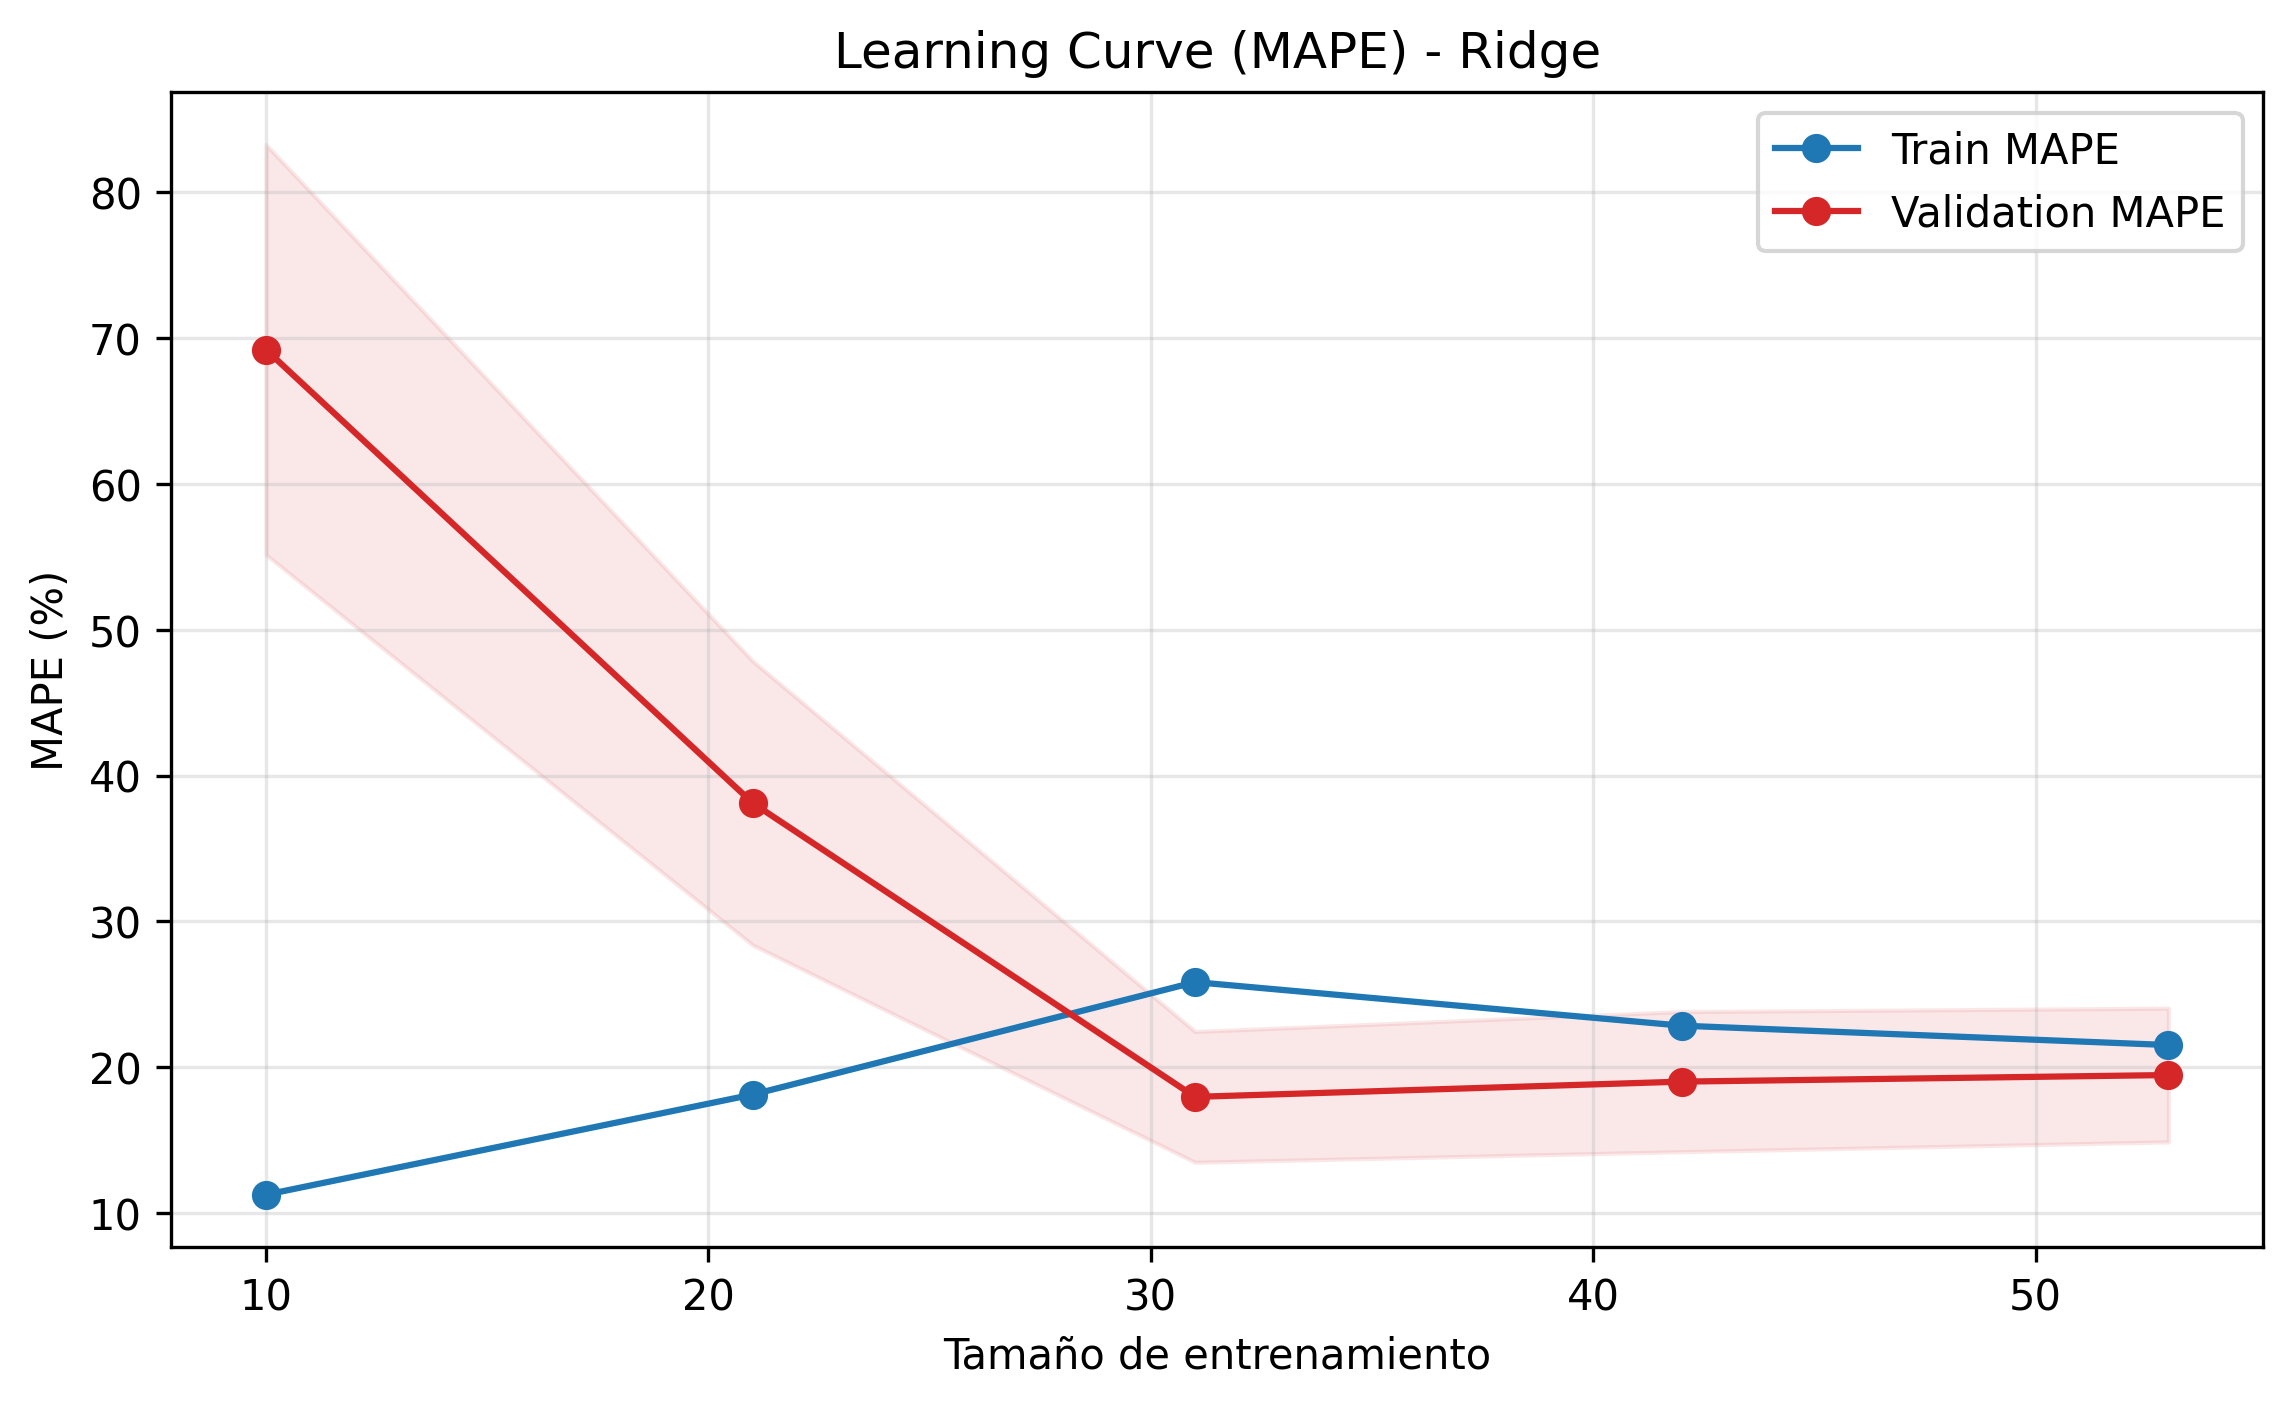

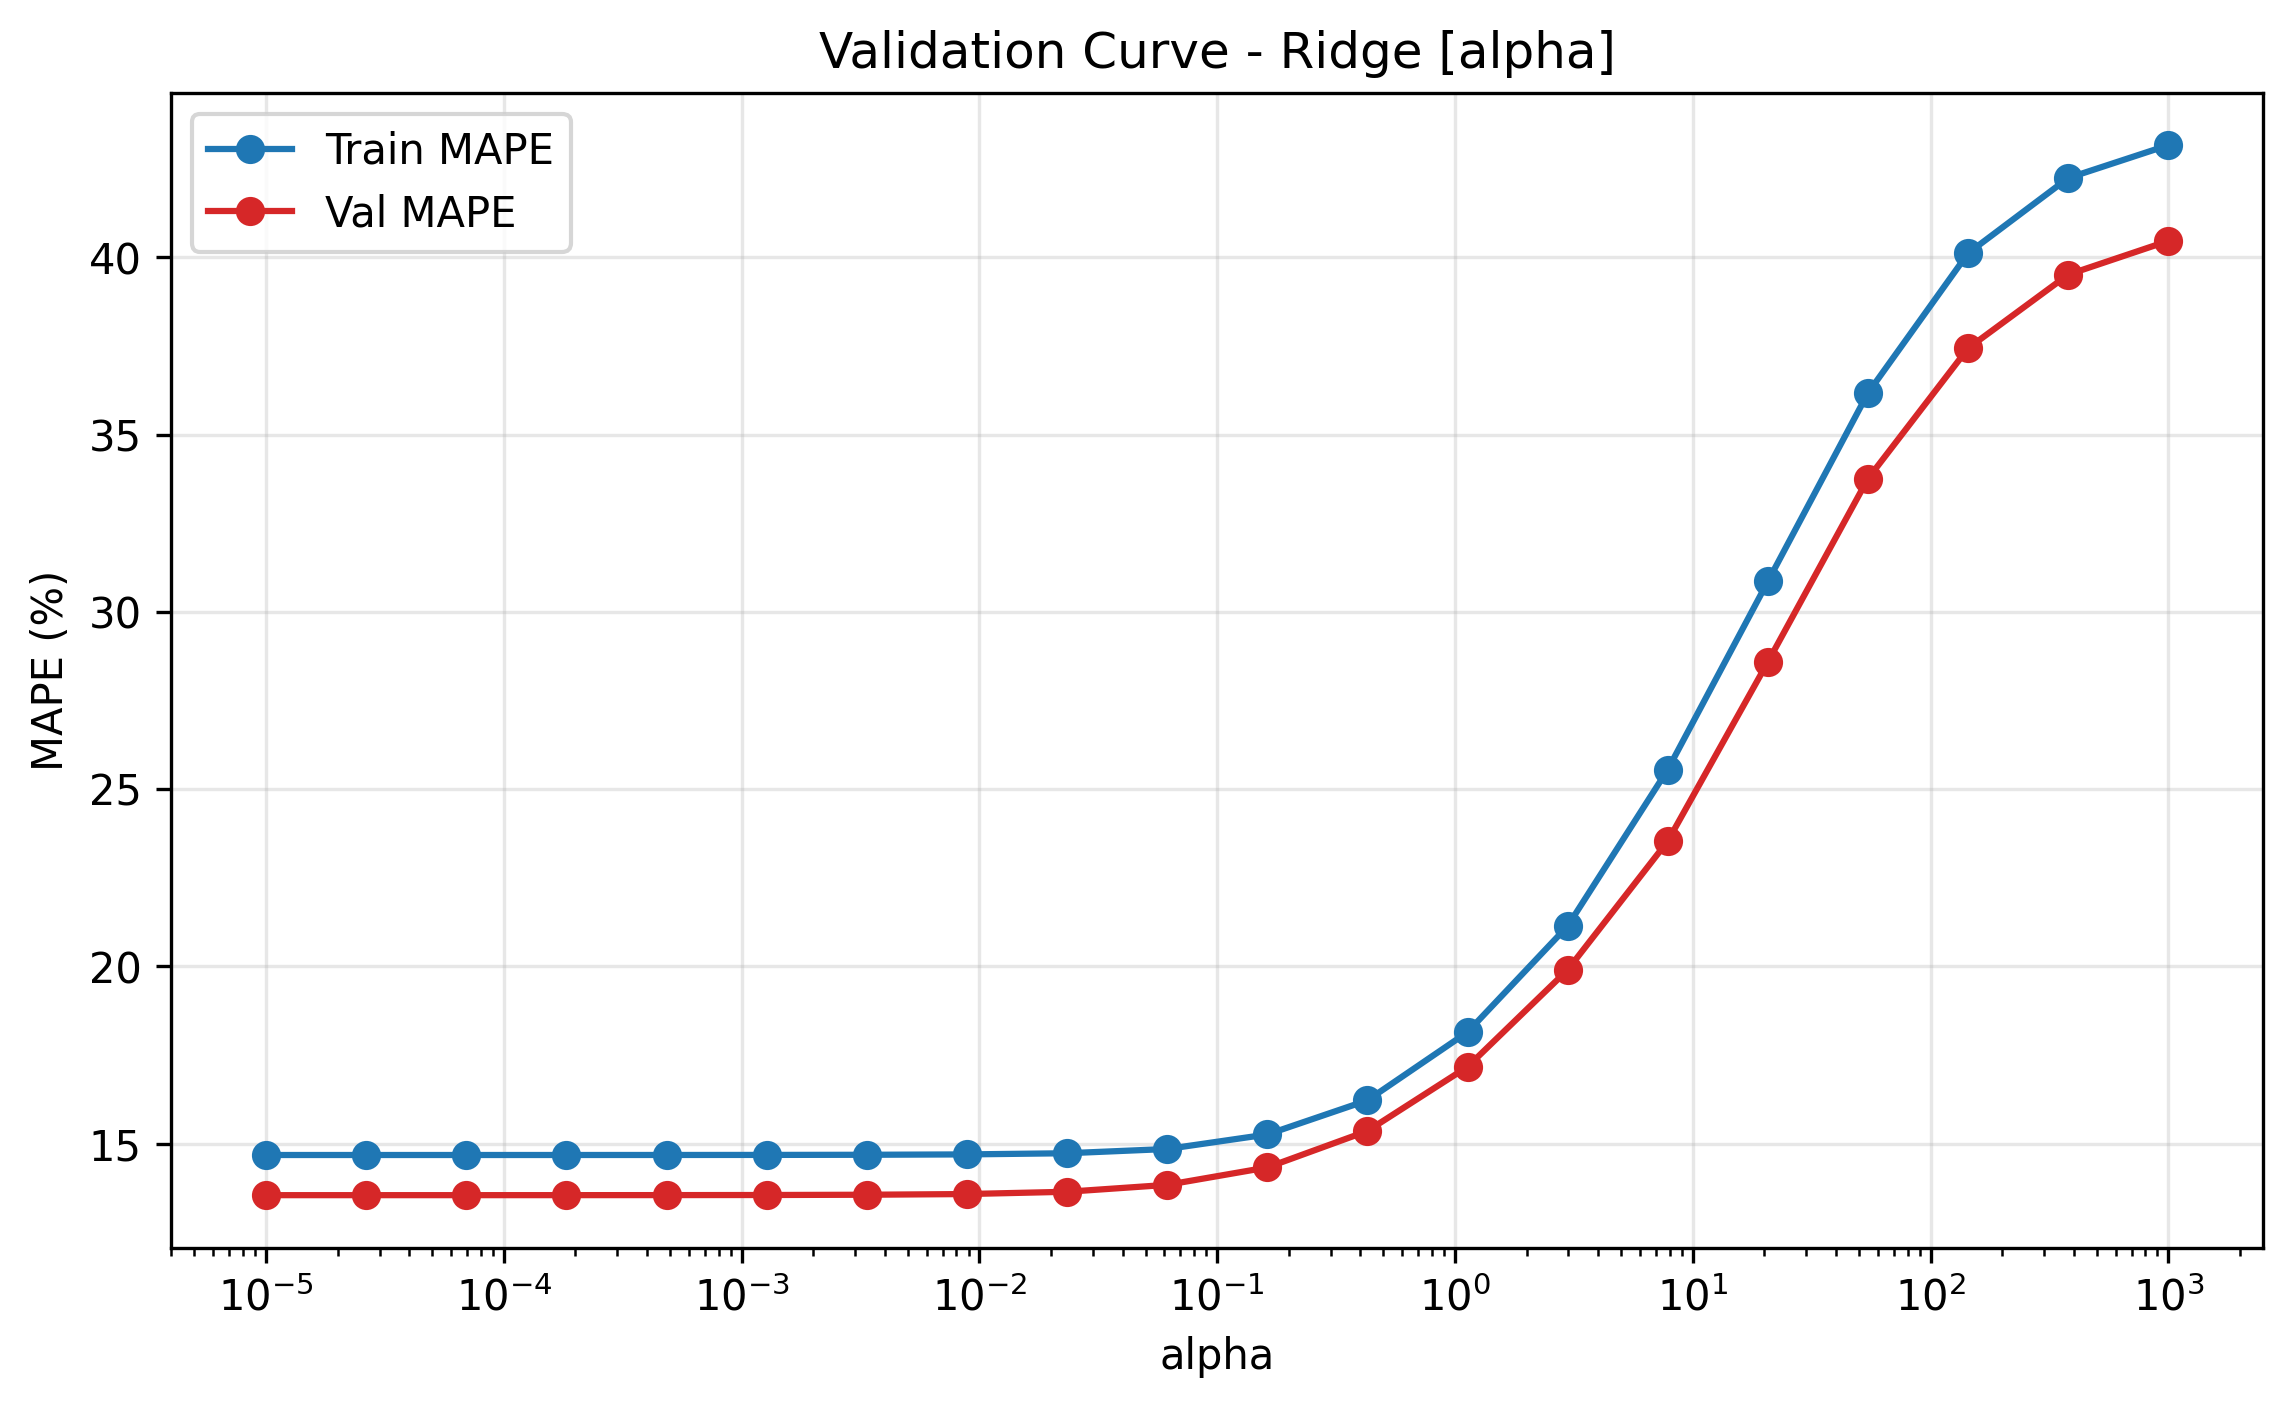

Ridge best params: {'alpha': np.float64(9.999999999999999e-06)}
Ridge (TEST) -> RMSE: 1.261 | MAE: 1.021 | MAPE: 11.42%


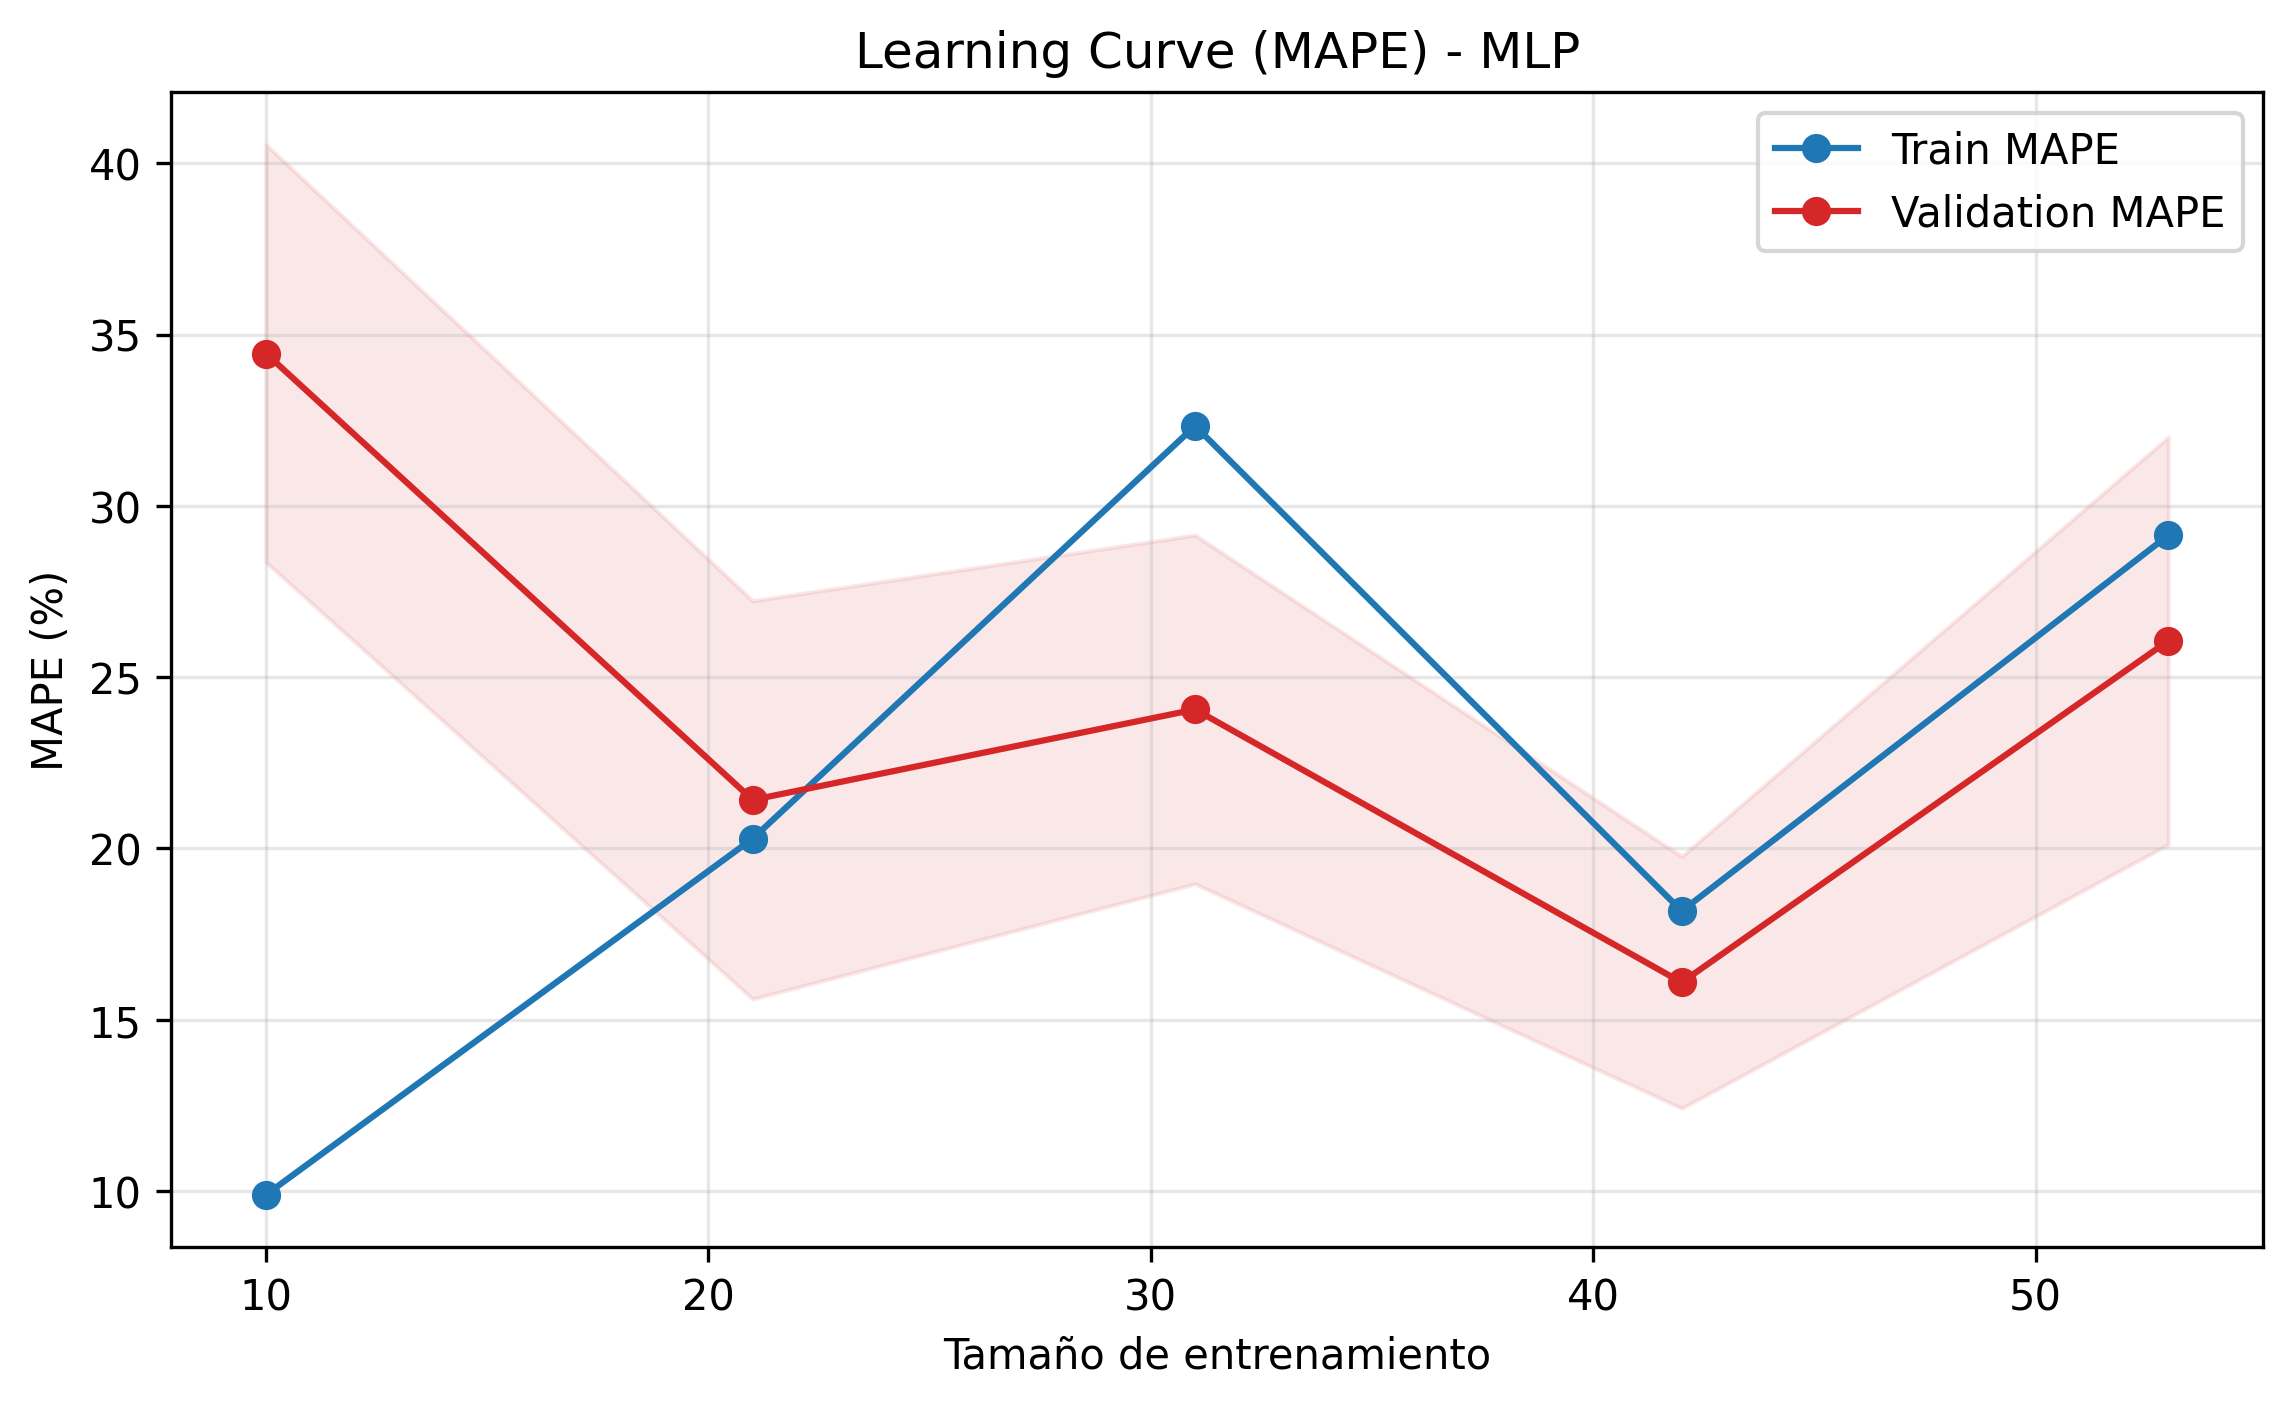

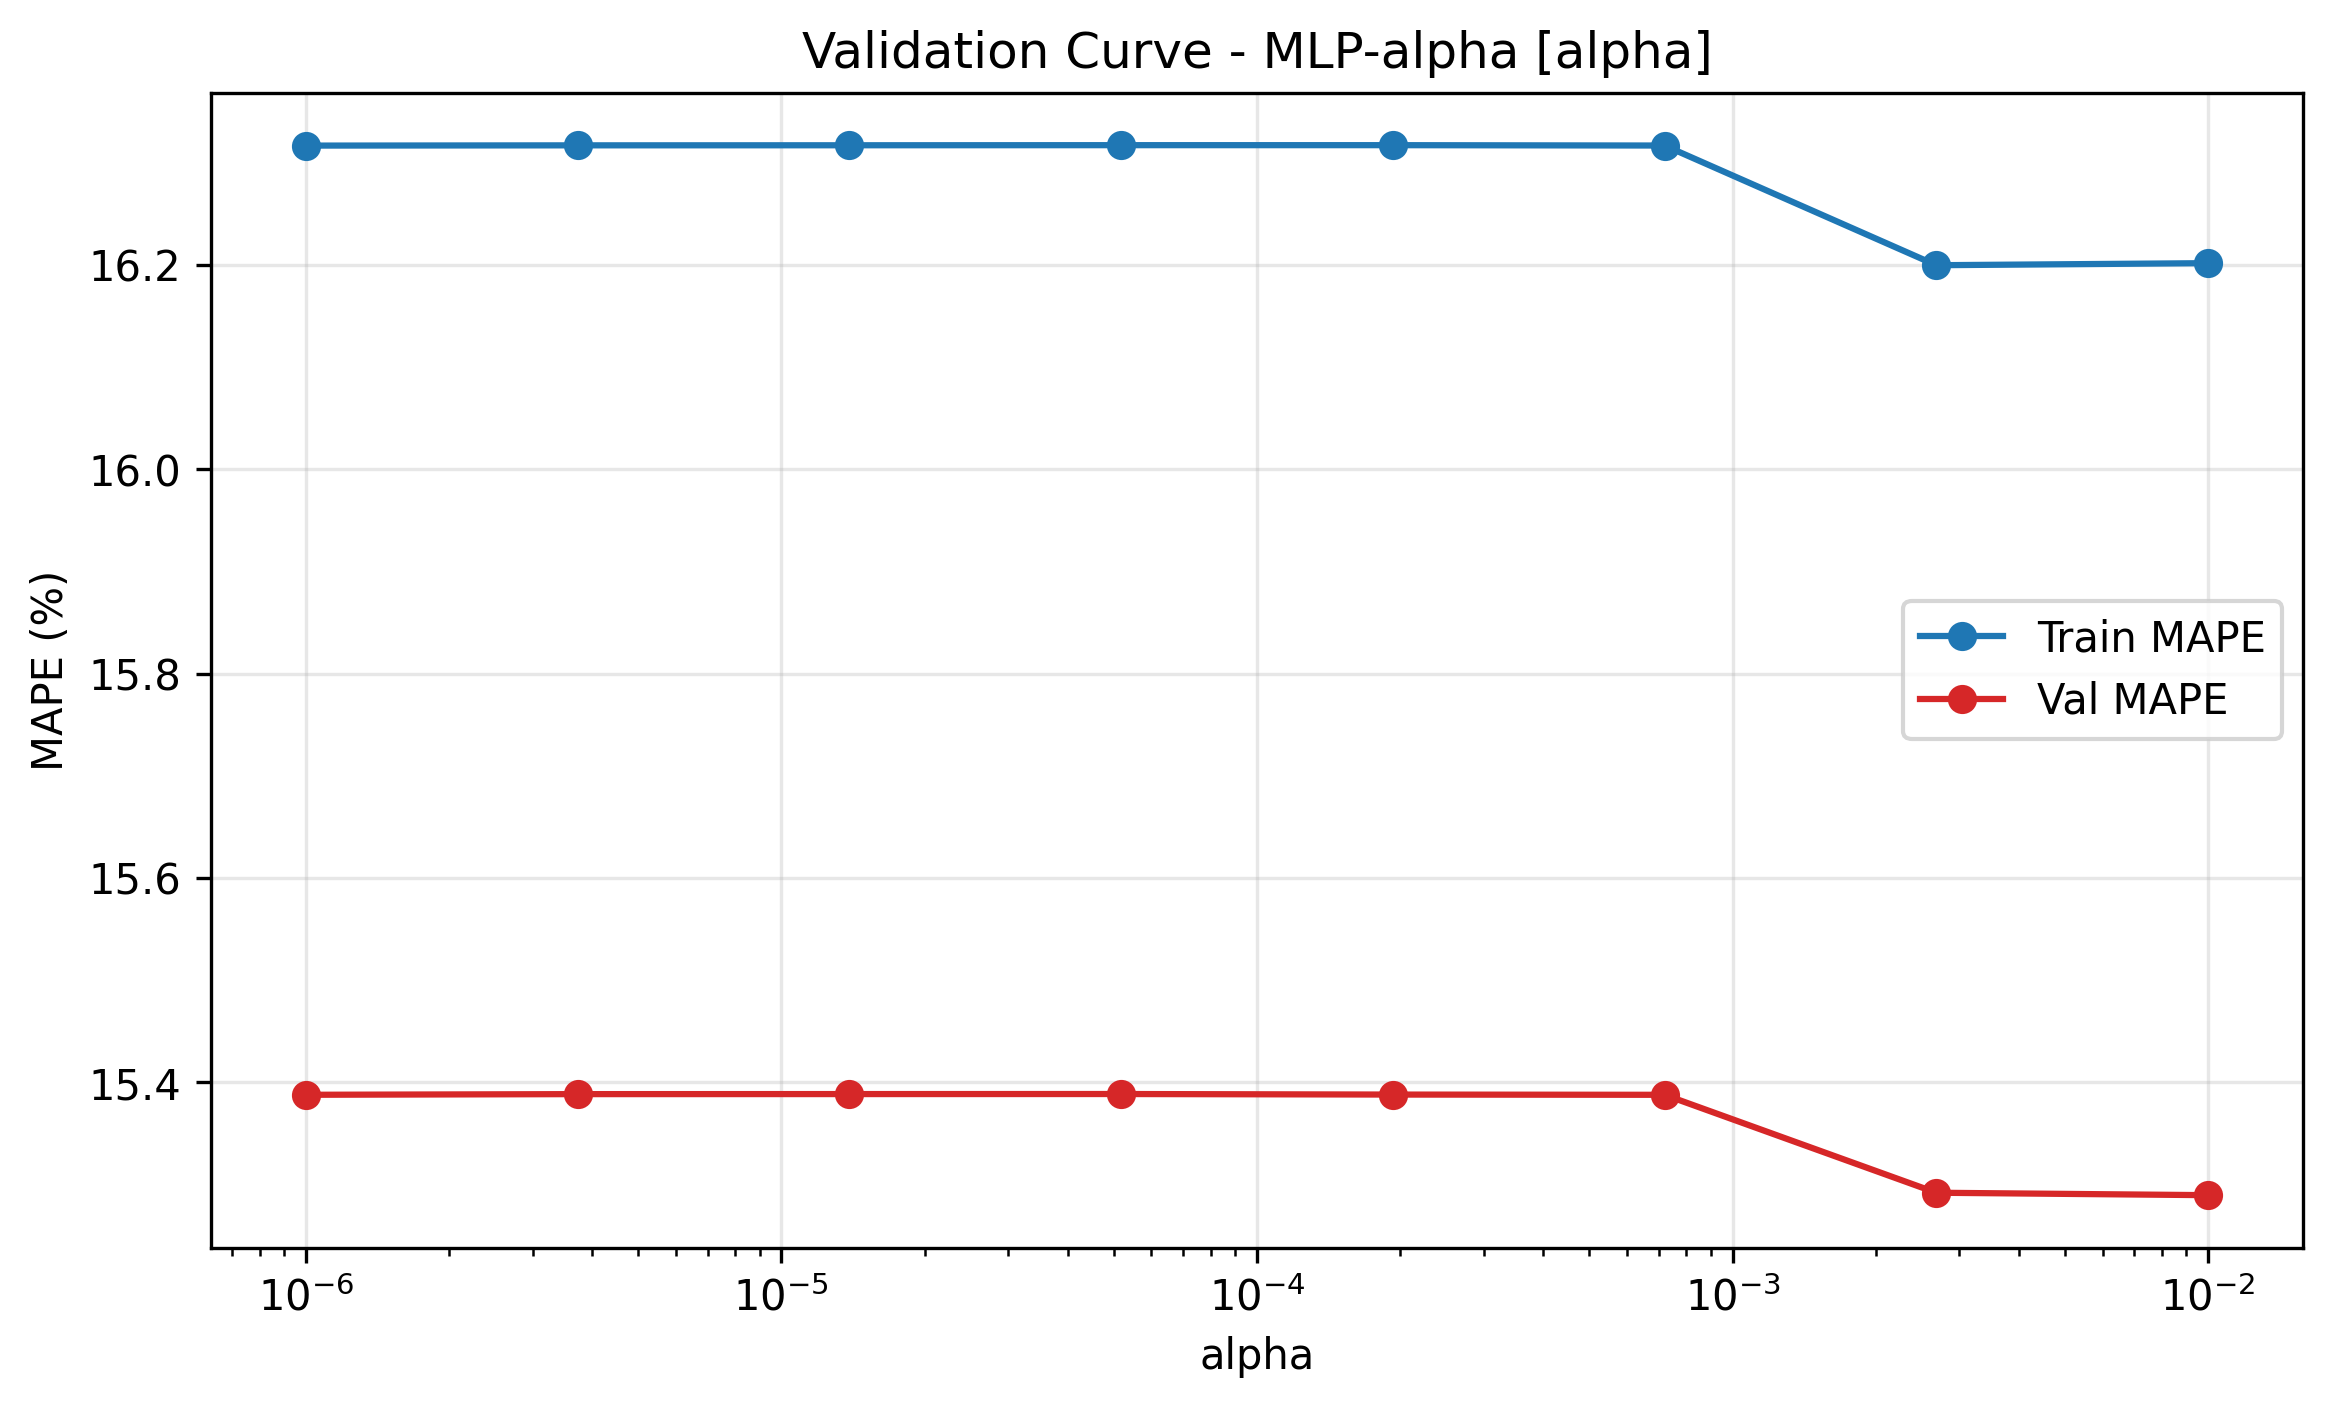

MLP best params: {'activation': 'tanh', 'alpha': np.float64(1e-06), 'hidden_layer_sizes': (64, 64), 'learning_rate_init': 0.003}
MLP (TEST) -> RMSE: 1.219 | MAE: 1.027 | MAPE: 11.79%


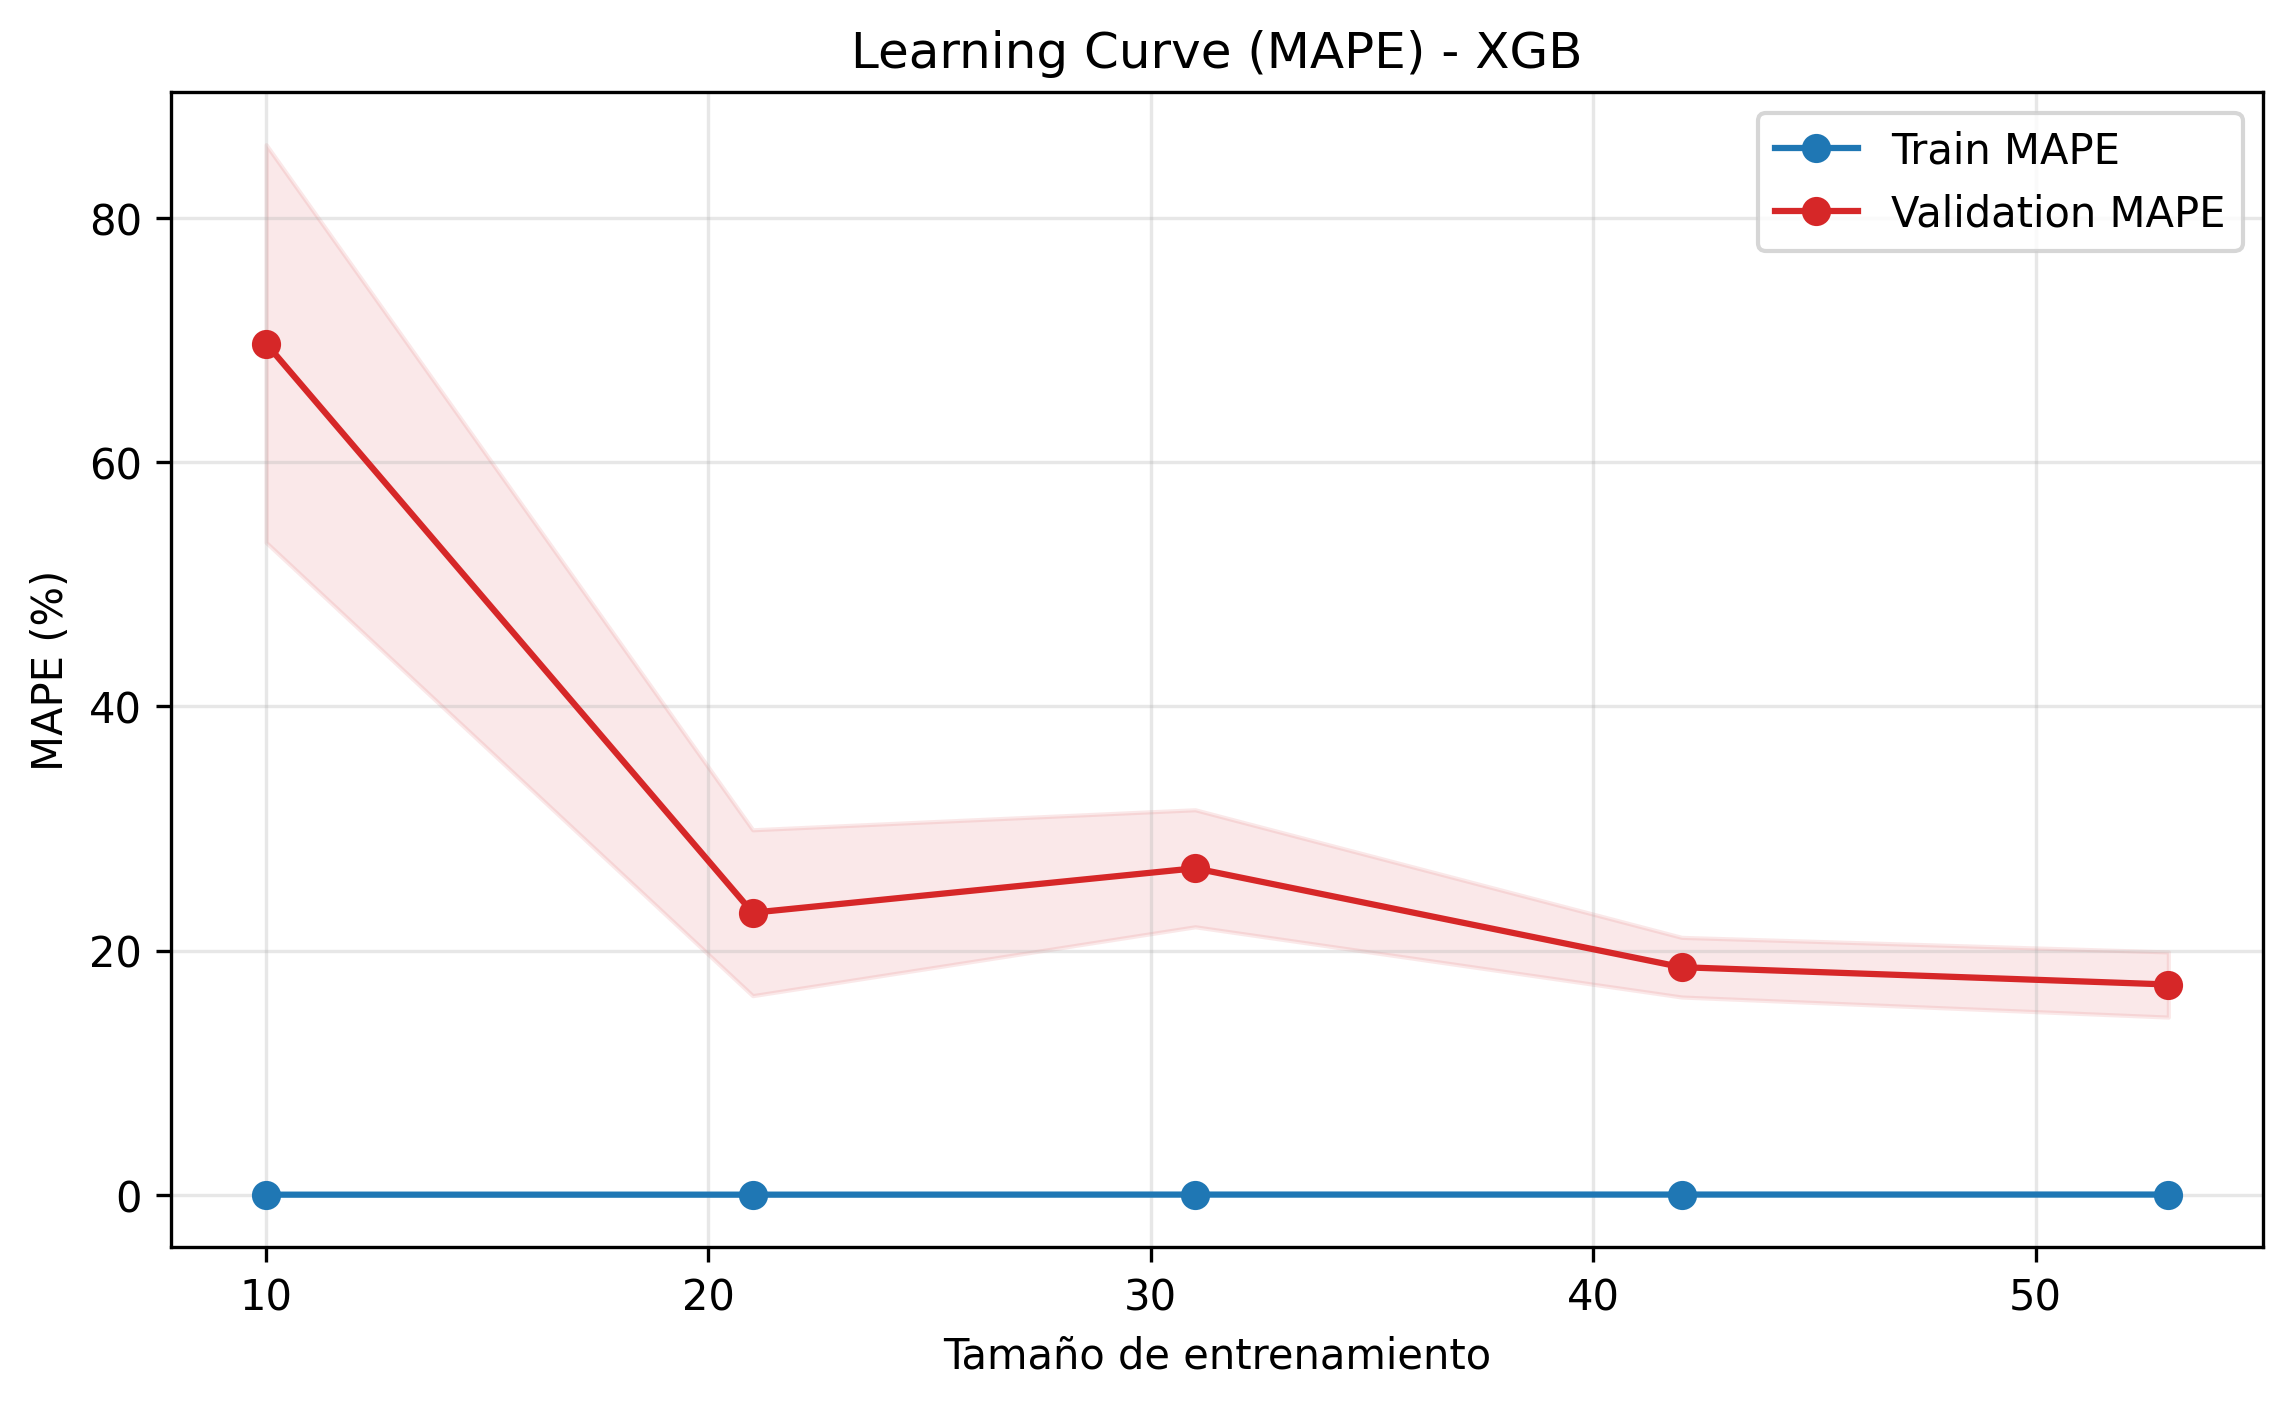

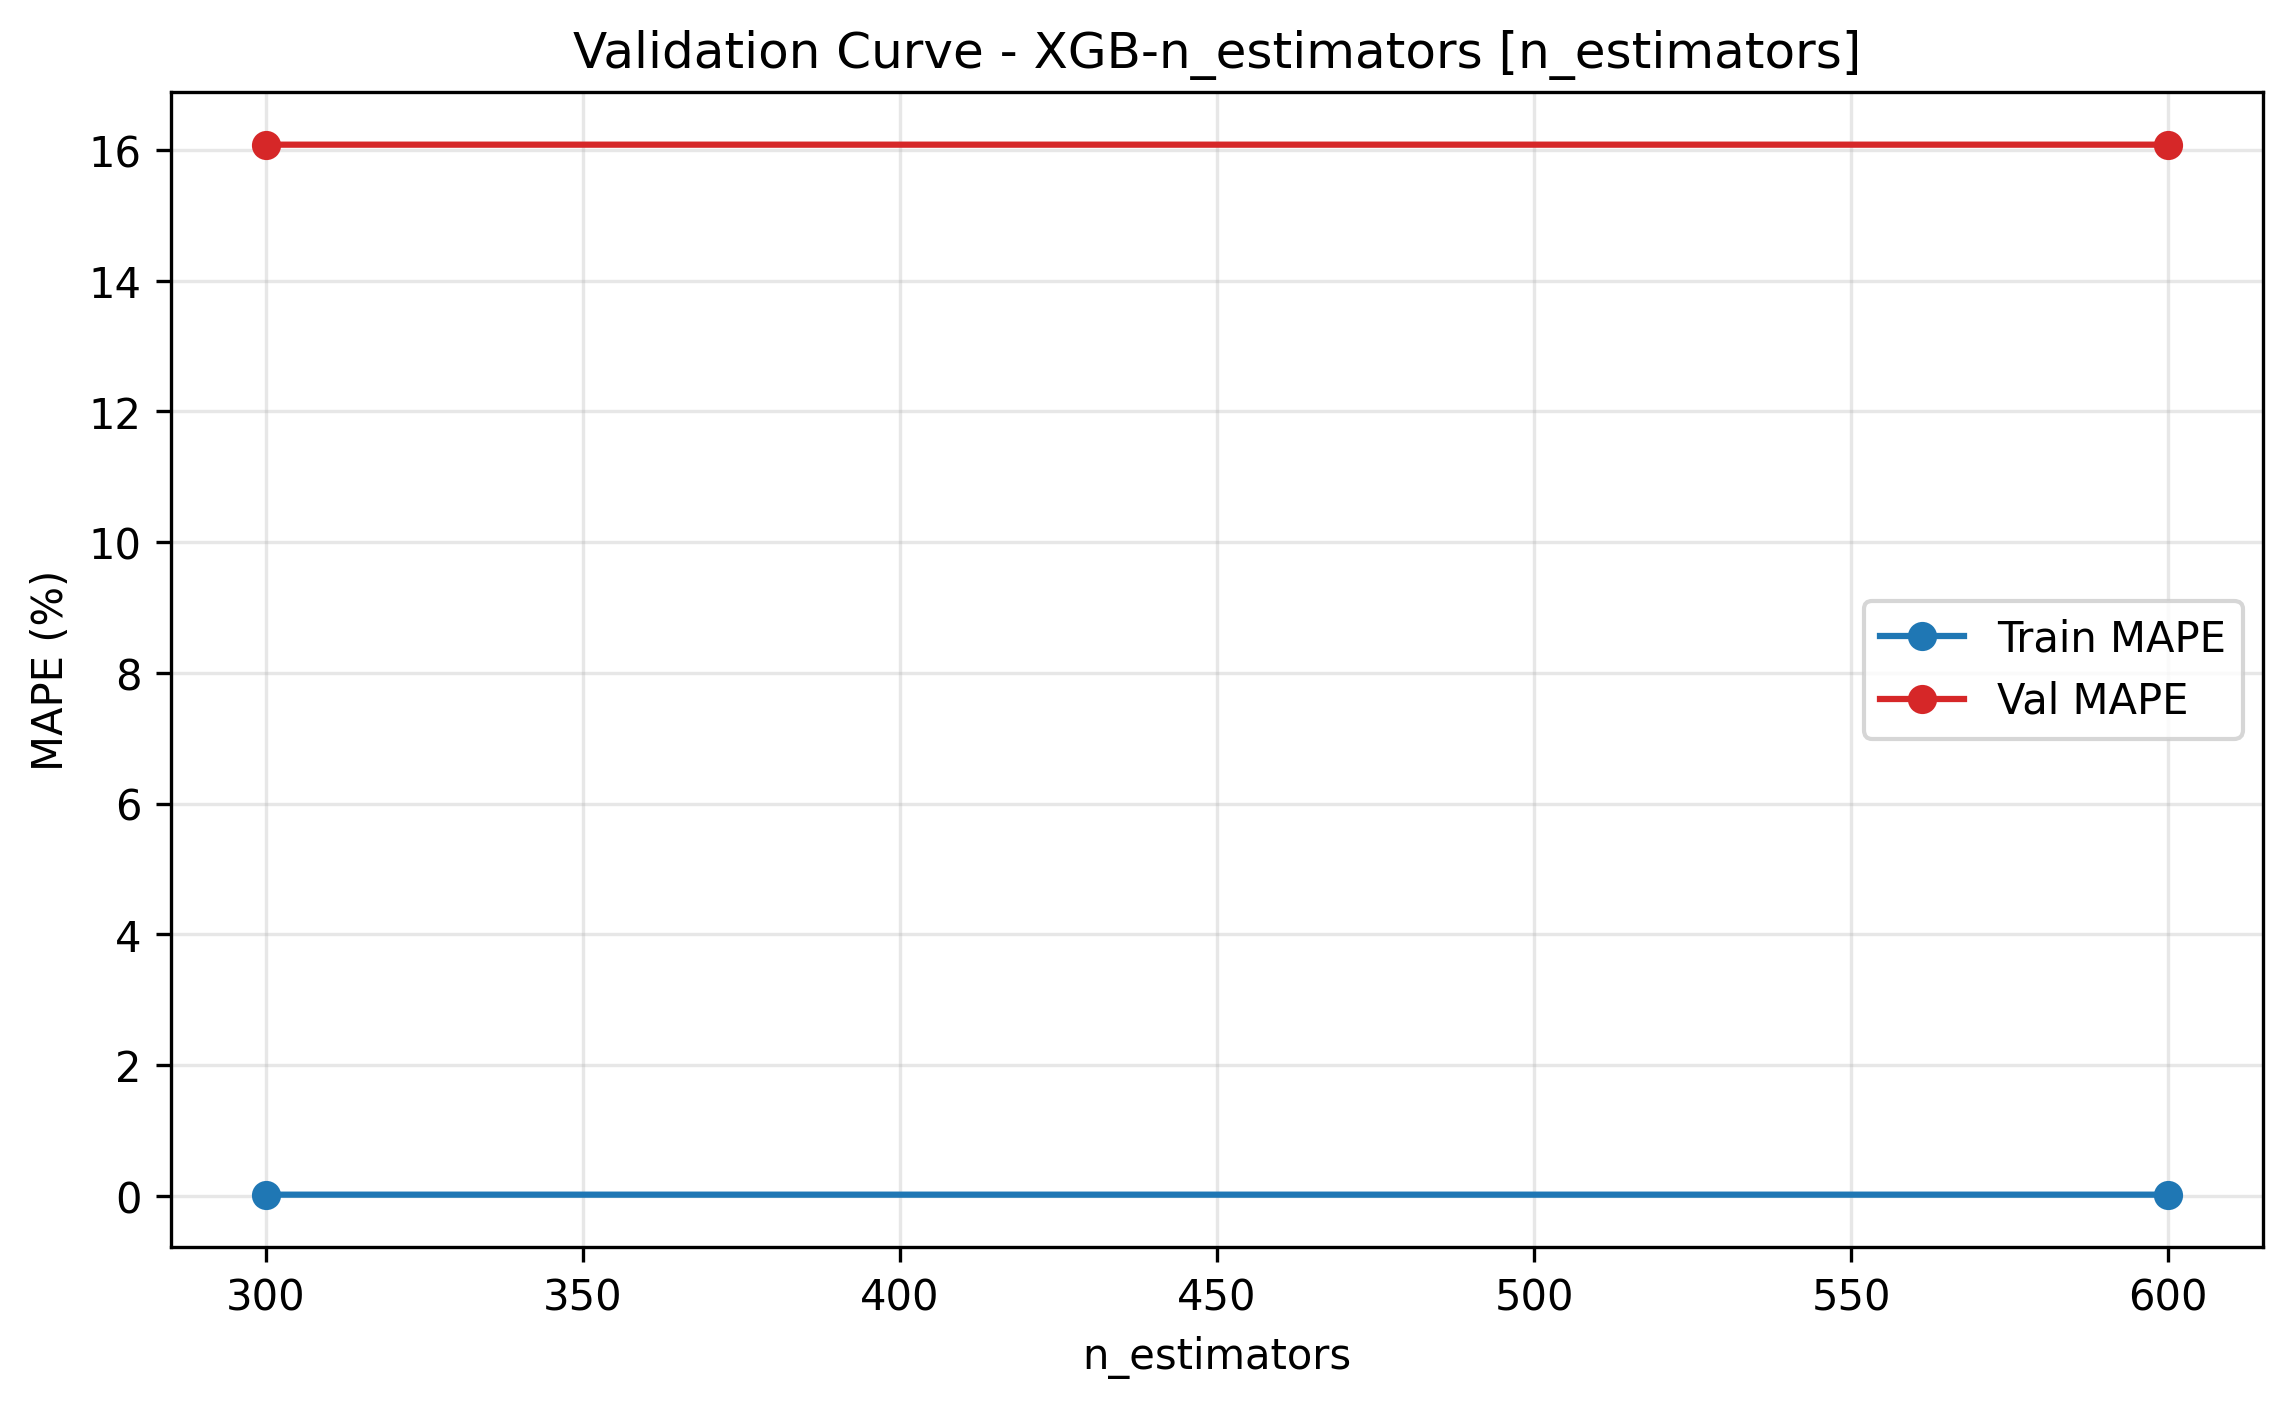

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:39:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:39:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [01:39:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


XGB best params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.001, 'reg_lambda': 1, 'subsample': 0.8}
XGB (TEST) -> RMSE: 1.440 | MAE: 1.180 | MAPE: 13.72%


LSTM best config: {'n_units': 96, 'dropout': 0.3, 'lr': 0.001, 'batch': 16}


LSTM (TEST) -> RMSE: 1.434 | MAE: 1.185 | MAPE: 13.58%

=== Resultados (ordenado por MAPE) ===
Modelo     RMSE      MAE    MAPE_%
 Ridge 1.260637 1.020874 11.423158
   MLP 1.219465 1.027246 11.792251
  LSTM 1.434137 1.184895 13.579797
   XGB 1.439735 1.180436 13.720187


In [ ]:
rows = [
    ("Ridge",) + ridge_metrics,
    ("MLP",)   + mlp_metrics,
    ("XGB",)   + xgb_metrics if HAS_XGB else ("XGB", np.nan, np.nan, np.nan),
    ("LSTM",)  + lstm_metrics
]
df_res = pd.DataFrame(rows, columns=["Modelo","RMSE","MAE","MAPE_%"]).sort_values("MAPE_%")
print("\n=== Resultados (ordenado por MAPE) ===")
print(df_res.to_string(index=False))


# **Exploración de modelo de ensamble Super Learner**

Cargar datos y utilidades

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Funciones auxiliares

def MAPE(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def report_model(y_true, y_pred, tag):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = MAPE(y_true, y_pred)
    print(f"{tag} -> RMSE: {rmse:.3f} | MAE: {mae:.3f} | MAPE: {mape:.2f}%")
    return rmse, mae, mape

Entrenar modelos base

In [ ]:
# Ridge
ridge = Ridge(alpha=0.0001)
ridge.fit(X_train, y_train)
ridge_val = ridge.predict(X_val)
ridge_test = ridge.predict(X_test)

# MLP
mlp = MLPRegressor(hidden_layer_sizes=(64,64), alpha=0.0003,
                   learning_rate_init=0.003, max_iter=2000, random_state=42)
mlp.fit(X_train, y_train)
mlp_val = mlp.predict(X_val)
mlp_test = mlp.predict(X_test)

# XGBoost
xgb = XGBRegressor(
    max_depth=2,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=1.0,
    n_estimators=300,
    objective='reg:squarederror',
    tree_method='gpu_hist' if tf.config.list_physical_devices('GPU') else 'hist',
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_val = xgb.predict(X_val)
xgb_test = xgb.predict(X_test)

# LSTM (usando secuencias)
def to_seq(X): return X.reshape((X.shape[0], X.shape[1], 1))
X_tr_l, X_val_l, X_te_l = to_seq(X_train), to_seq(X_val), to_seq(X_test)

lstm = Sequential([
    Input(shape=(X_tr_l.shape[1], 1)),
    LSTM(96, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
cb = [EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
      ReduceLROnPlateau(factor=0.5, patience=7, verbose=0)]
lstm.fit(X_tr_l, y_train, validation_data=(X_val_l, y_val),
         epochs=60, batch_size=16, verbose=0, callbacks=cb)
lstm_val = lstm.predict(X_val_l).ravel()
lstm_test = lstm.predict(X_te_l).ravel()

Construcción modelo de ensamble SuperLearner (stacking)

In [ ]:
# Crear conjunto meta con predicciones de validación
meta_X_val = np.vstack([ridge_val, mlp_val, xgb_val, lstm_val]).T
meta_X_test = np.vstack([ridge_test, mlp_test, xgb_test, lstm_test]).T

# Entrenar meta-modelo (Ridge o LinearRegression)
meta_model = Ridge(alpha=0.01)  # puedes cambiar a LinearRegression()
meta_model.fit(meta_X_val, y_val)

# Predicción final del SuperLearner
super_pred = meta_model.predict(meta_X_test)

Evaluación

In [ ]:
ridge_metrics = report_model(y_test, ridge_test, "Ridge (TEST)")
mlp_metrics   = report_model(y_test, mlp_test,   "MLP (TEST)")
xgb_metrics   = report_model(y_test, xgb_test,   "XGB (TEST)")
lstm_metrics  = report_model(y_test, lstm_test,  "LSTM (TEST)")
super_metrics = report_model(y_test, super_pred, "SuperLearner (TEST)")

# Comparación
df_comp = pd.DataFrame([
    ["Ridge"] + list(ridge_metrics),
    ["MLP"] + list(mlp_metrics),
    ["XGB"] + list(xgb_metrics),
    ["LSTM"] + list(lstm_metrics),
    ["SuperLearner"] + list(super_metrics),
], columns=["Modelo", "RMSE", "MAE", "MAPE_%"]).sort_values("MAPE_%")
print("\n=== Comparación Final ===")
print(df_comp.to_string(index=False))

Visualización Real vs Predicho

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:58:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [01:58:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Ridge (TEST) -> RMSE: 1.261 | MAE: 1.021 | MAPE: 11.42%
MLP (TEST) -> RMSE: 1.293 | MAE: 1.059 | MAPE: 11.79%
XGB (TEST) -> RMSE: 1.439 | MAE: 1.186 | MAPE: 13.76%
LSTM (TEST) -> RMSE: 1.464 | MAE: 1.225 | MAPE: 14.23%
SuperLearner (TEST) -> RMSE: 1.551 | MAE: 1.277 | MAPE: 14.36%

=== Comparación Final ===
      Modelo     RMSE      MAE    MAPE_%
       Ridge 1.260653 1.020887 11.423309
         MLP 1.293067 1.058620 11.794271
         XGB 1.439064 1.185596 13.763440
        LSTM 1.464434 1.224626 14.230352
SuperLearner 1.550696 1.277102 14.359860


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


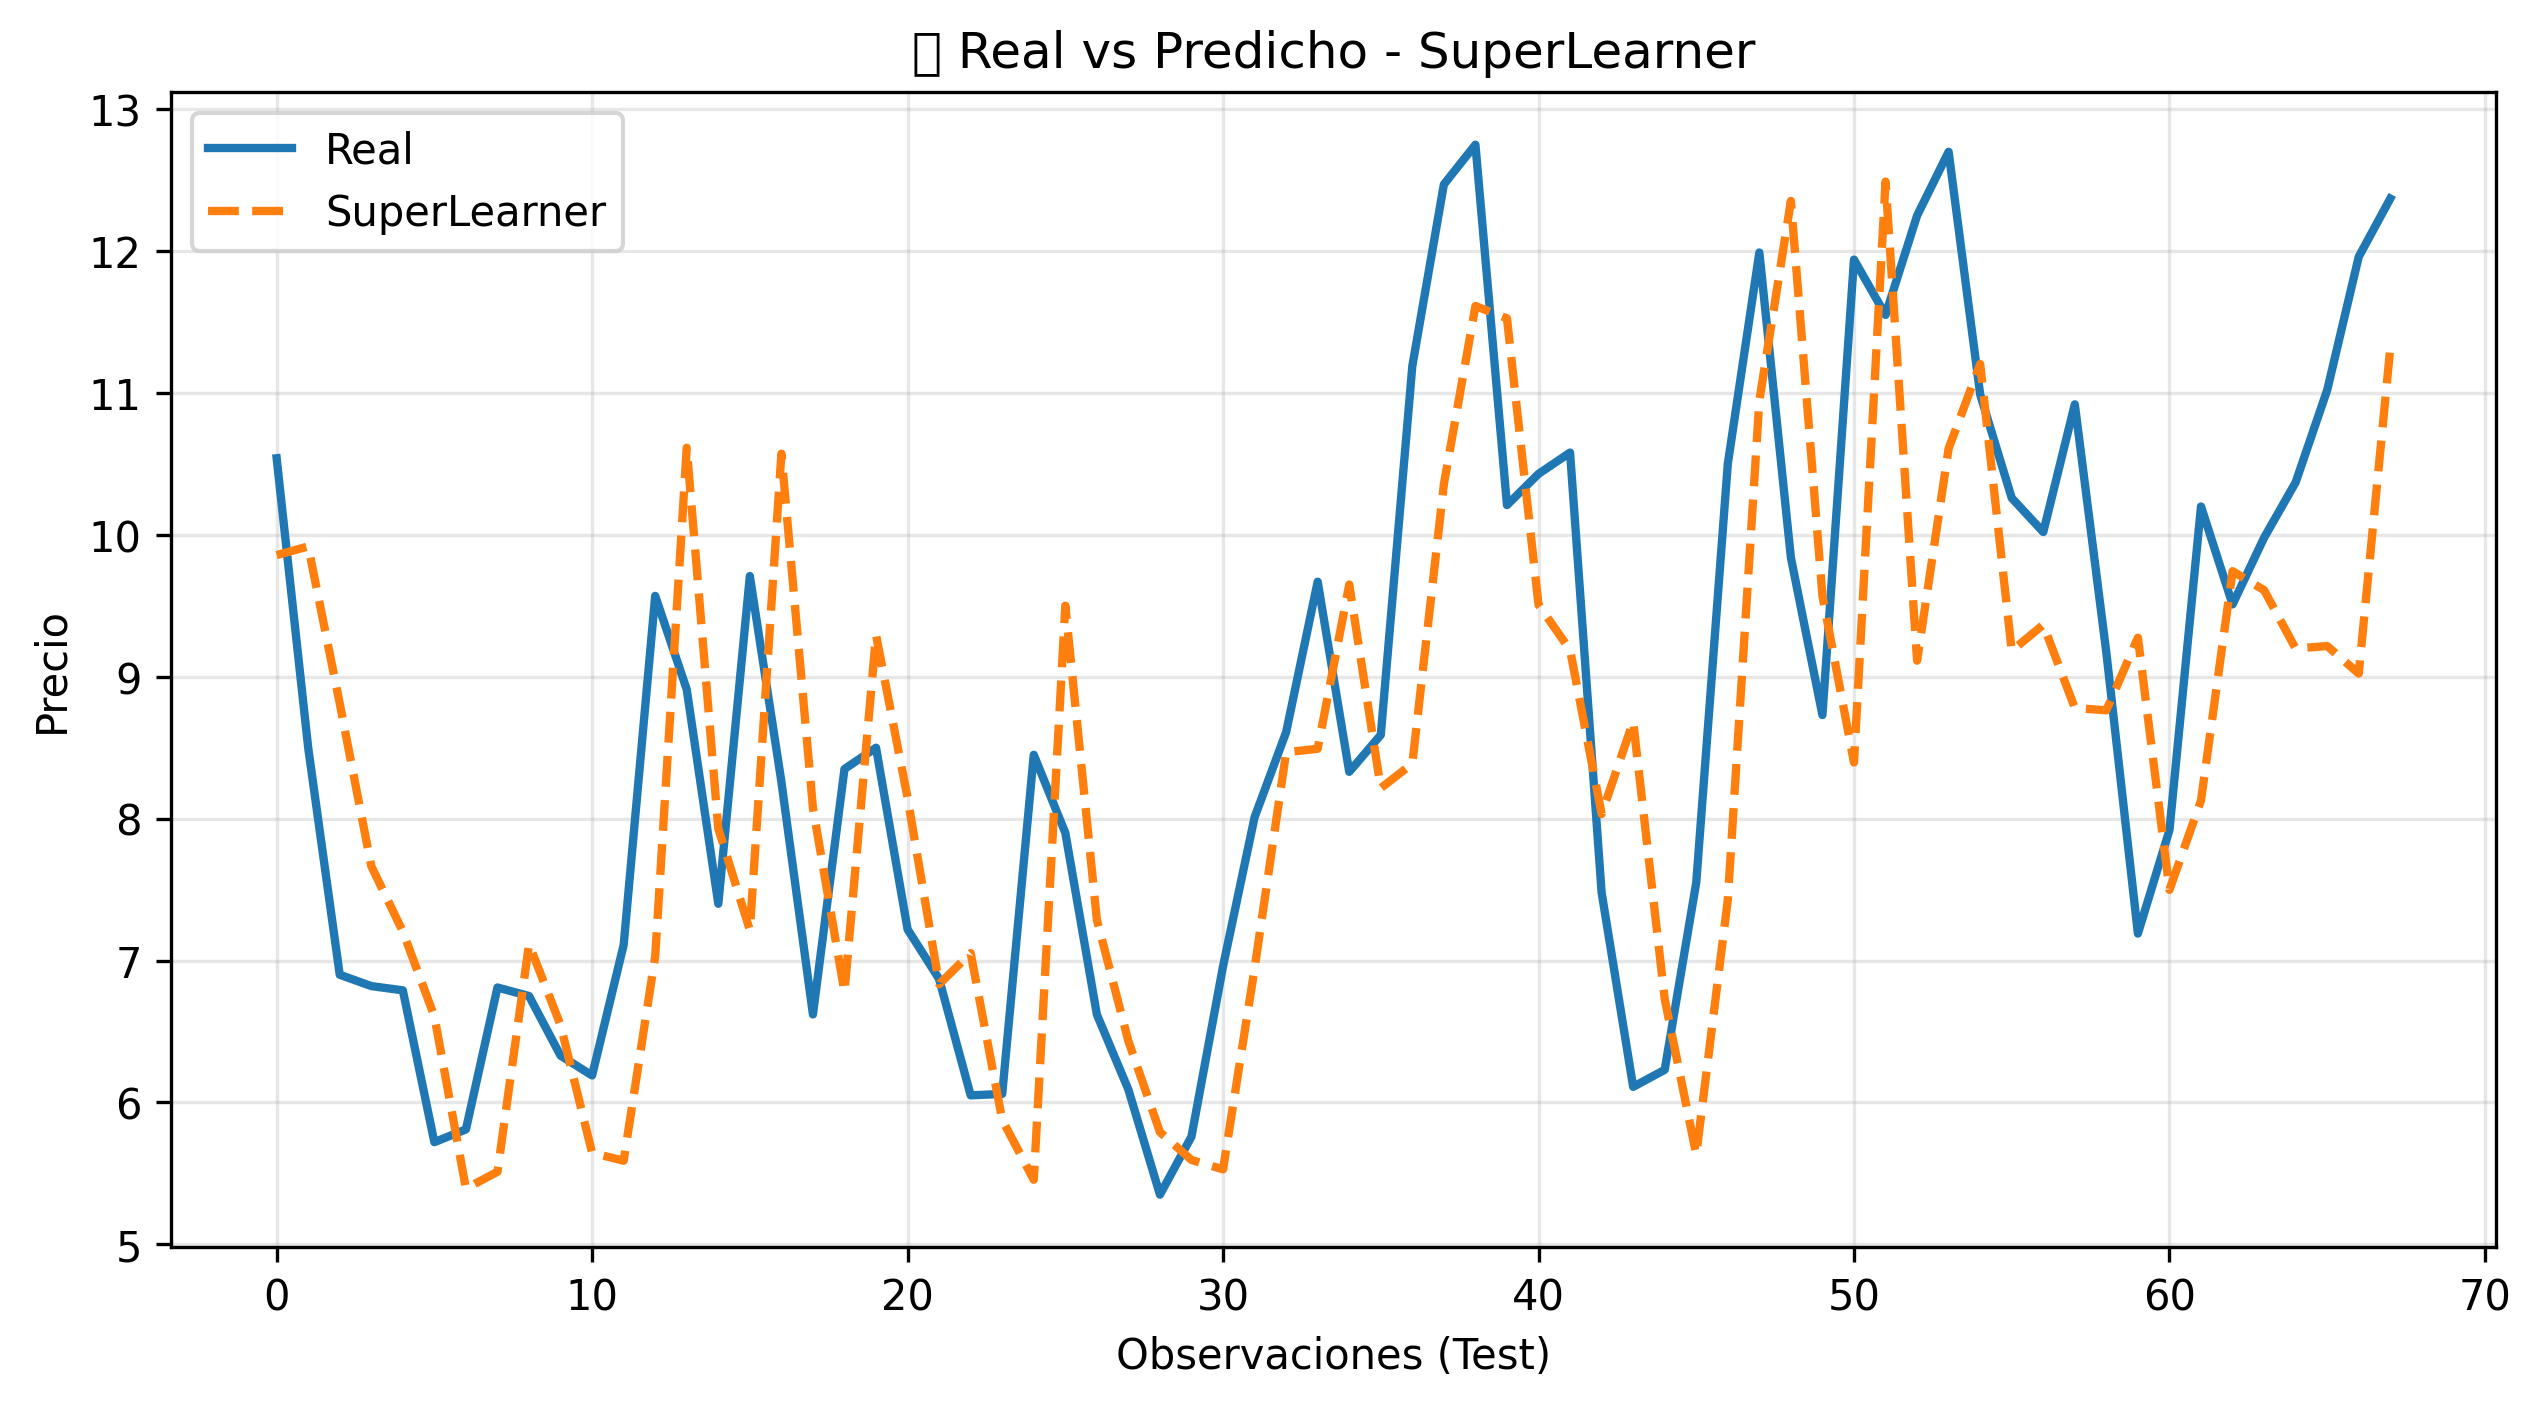

In [ ]:
plt.figure(figsize=(10,5), dpi=300)
plt.plot(y_test, label='Real', linewidth=2)
plt.plot(super_pred, label='SuperLearner', linestyle='--', linewidth=2)
plt.title("📈 Real vs Predicho - SuperLearner")
plt.xlabel("Observaciones (Test)")
plt.ylabel("Precio")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# **Mejora de modelo SuperLearner**

Predicciones OOF para meta-modelo

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import RidgeCV

tscv = TimeSeriesSplit(n_splits=5)
oof_preds = []
oof_y = []

for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_tr, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Entrenar cada modelo base en fold
    ridge_fold = Ridge(alpha=0.0001).fit(X_tr, y_tr)
    mlp_fold = MLPRegressor(hidden_layer_sizes=(64,64), alpha=0.0003,
                            learning_rate_init=0.003, max_iter=2000).fit(X_tr, y_tr)
    xgb_fold = XGBRegressor(max_depth=2, learning_rate=0.05,
                            subsample=0.9, colsample_bytree=1.0,
                            n_estimators=300, objective='reg:squarederror').fit(X_tr, y_tr)

    lstm_fold = Sequential([
        Input(shape=(X_tr.shape[1], 1)),
        LSTM(96, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    lstm_fold.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
    lstm_fold.fit(to_seq(X_tr), y_tr, epochs=60, batch_size=16, verbose=0,
                  validation_data=(to_seq(X_val_fold), y_val_fold))

    # Predicciones en fold
    preds_fold = np.vstack([
        ridge_fold.predict(X_val_fold),
        mlp_fold.predict(X_val_fold),
        xgb_fold.predict(X_val_fold),
        lstm_fold.predict(to_seq(X_val_fold)).ravel()
    ]).T

    oof_preds.append(preds_fold)
    oof_y.append(y_val_fold)

# Concatenar predicciones OOF
meta_X = np.vstack(oof_preds)
meta_y = np.concatenate(oof_y)

Entrenamiento de meta-modelo con regularización

In [ ]:
meta_model = RidgeCV(alphas=np.logspace(-4, 2, 20), cv=tscv)
meta_model.fit(meta_X, meta_y)

Reentrenamiento de modelos base con Train+Val y predecir en Test

In [ ]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

ridge.fit(X_train_full, y_train_full)
mlp.fit(X_train_full, y_train_full)
xgb.fit(X_train_full, y_train_full)
lstm.fit(to_seq(X_train_full), y_train_full, epochs=60, batch_size=16, verbose=0)

meta_X_test = np.vstack([
    ridge.predict(X_test),
    mlp.predict(X_test),
    xgb.predict(X_test),
    lstm.predict(to_seq(X_test)).ravel()
]).T

super_pred = meta_model.predict(meta_X_test)

Evaluación Final

In [ ]:
super_metrics = report_model(y_test, super_pred, "SuperLearner Mejorado (TEST)")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:59:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
SuperLearner Mejorado (TEST) -> RMSE: 1.308 | MAE: 1.057 | MAPE: 11.73%


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [02:00:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
